In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize
import prettytable
import plotly.graph_objects as go
import os
import math
import plotly.express as px
from google.colab import files
from scipy.stats import pearsonr

random.seed(0) # Setting random seed to 0
%matplotlib inline

#Defining the risk free rate as in H1
risk_free_rate = 0.035


### Sustainable and Entrepreneurial Finance

#### Assignment 2 - Portfolio decarbonization

##### Group 8 - Energy Firms With Available Scope 1 to 3 emissions (TRUCOST)

- Charlotte Ahrens
- David Campbell
- Guillaume Rico
- Per Christian Wessel


### Our coding principles

- We always comment our code
- We use functions when we can
- When we create plots, we remember  to write a little description in markdown  of what it shows
- We try to use the same design and colorshcemes when creating plots

### 0 Importing and preparing datasets

In [ ]:
# Setting path names
github_path = 'https://github.com/percw/Sustainable_and_Entrepreneurial_Finance/blob/master'

# Scope 1-3 Intensity Paths
path_scope1_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope1intensity.xlsx?raw=true'
path_scope2_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope2intensity.xlsx?raw=true'
path_scope3_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope3intensity.xlsx?raw=true'

# Reading df's
df_scope1_intensity = pd.read_excel(path_scope1_intensity)
df_scope2_intensity = pd.read_excel(path_scope2_intensity)
df_scope3_intensity = pd.read_excel(path_scope3_intensity)

# Dataframe created during Homework 1 (corresponding to Q2 First df)
path_all_energy_monthly_yearly_returns_cap = f'{github_path}/output/all_energy_monthly_yearly_returns_cap.csv?raw=true'
df_all_energy_monthly_yearly_returns_cap = pd.read_csv(path_all_energy_monthly_yearly_returns_cap)

# Dataframe created during Homework 1 (corresponding to Q2 Second, comparison df with value weighted and equally weighted portfolio)
path_all_energy_monthly_yearly_returns_cap_vw = f'{github_path}/output/df_all_energy_monthly_yearly_returns_cap_vw.csv?raw=true'
df_all_energy_monthly_yearly_returns_cap_vw = pd.read_csv(path_all_energy_monthly_yearly_returns_cap_vw)


A little cleaning of the double index column, thus removing `Unnamed: 0`.

In [ ]:
df_all_energy_monthly_yearly_returns_cap.drop(columns={'Unnamed: 0'}, inplace=True)
display(df_all_energy_monthly_yearly_returns_cap.head())

date  year  month          ISIN  monthly_return  market_cap  \
0  2005-01-31  2005      1  AN8068571086          0.0126         NaN   
1  2005-02-28  2005      2  AN8068571086          0.0635         NaN   
2  2005-03-31  2005      3  AN8068571086          0.0930         NaN   
3  2005-04-30  2005      4  AN8068571086         -0.0384         NaN   
4  2005-05-31  2005      5  AN8068571086         -0.0271         NaN   

   annual_returns  
0          0.4680  
1          0.4680  
2          0.4680  
3          0.4680  
4          0.4680

Checking out the intensity data and removing the x in the column name

In [ ]:
df_scope1_intensity.describe()

# Replacing the x before every year
df_scope1_intensity.columns = df_scope1_intensity.columns.str.replace('x','')
display(df_scope1_intensity.head())
display(df_scope1_intensity.shape)
df_scope1_intensity.isna().sum()

ISIN                                  NAME  1999  2000  2001  2002  \
0  AEA000201011                   ABU DHABI COML.BANK   NaN   NaN   NaN   NaN   
1  AEA000701010                          WAHA CAPITAL   NaN   NaN   NaN   NaN   
2  AEA000801018                ABU DHABI ISLAMIC BANK   NaN   NaN   NaN   NaN   
3  AEA001201010                         AMLAK FINANCE   NaN   NaN   NaN   NaN   
4  AEA001501013  ARABTEC HOLDING SUSP - SUSP.30/09/20   NaN   NaN   NaN   NaN   

   2003  2004  2005  2006  ...  2011  2012    2013    2014    2015    2016  \
0   NaN   NaN   NaN   NaN  ...   NaN   NaN  0.6355  0.6089  0.6282  0.5702   
1   NaN   NaN   NaN   NaN  ...   NaN   NaN 19.1956 18.8418 18.8540 18.3326   
2   NaN   NaN   NaN   NaN  ...   NaN   NaN     NaN     NaN     NaN     NaN   
3   NaN   NaN   NaN   NaN  ...   NaN   NaN     NaN     NaN     NaN  0.5386   
4   NaN   NaN   NaN   NaN  ...   NaN   NaN 26.4743 24.9629 25.0330 24.4321   

      2017    2018    2019  2020  
0   0.5491  0.4410  0.3935   NaN  
1  17.8478 17.3512 17.5759   NaN  
2      NaN  0.9946  0.8984   NaN  
3   5.7591  6.6385  5.6038   NaN  
4 124.4146 63.5043 61.4214   NaN  

[5 rows x 24 columns]

(17610, 24)

ISIN        0
NAME        0
1999    17610
2000    17610
2001    17610
2002    17610
2003    17610
2004    17610
2005    13854
2006    13571
2007    13435
2008    13455
2009    13168
2010    12997
2011    12897
2012    12860
2013    11982
2014    11586
2015    11496
2016     4108
2017     3210
2018     2522
2019     1947
2020    17487
dtype: int64

We can see that up until 2005 we have only NaNs. The same goes for 2020.

In [ ]:
df_scope1_intensity.drop(axis=1, columns=['2020'], inplace=True)


Lets create a function that takes in a dataframe and transforms all the different year columns into one column named year, and let each ISIN/company have as many observations as years.

In [ ]:
def transform_emission_dataframe(df: pd.DataFrame, id_vars: list, var_name: str, value_name: str) -> pd.DataFrame:
    '''
    Function that takes in a df frame and melts it on given column names
    Returns a dataframe
    '''
    # Melt the dataframe to convert it from wide to long format
    df_long = df.melt(id_vars=id_vars,
                      var_name=var_name, value_name=value_name)

    # Convert the year column to integer data type
    df_long['year'] = df_long['year'].astype(int)

    # Drop rows with missing values
    df_long.dropna(inplace=True)

    # Sort the dataframe by ISIN and year
    df_long.sort_values(['year', 'ISIN'], inplace=True)

    # Reset the index
    df_long.reset_index(drop=True, inplace=True)

    # Print the resulting dataframe
    return df_long


In [ ]:
transformed_scope1 = transform_emission_dataframe(df_scope1_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_1')
display(transformed_scope1.head())
display(transformed_scope1.shape)

ISIN                                NAME  year   Scope_1
0  AN8068571086                        SCHLUMBERGER  2005  135.8217
1  ARALUA010258                               ALUAR  2005 1001.6883
2  ARBANS010010              BANCO MACRO BANSUD 'B'  2005    1.3473
3  ARP125991090                  BBVA BANCO FRANCES  2005    1.3473
4  ARSIDE010029  TERNIUM ARGENTINA SOCIEDAD ANONIMA  2005 4276.1656

(111062, 4)

This looks good. Let's do the same with the Scope 2 and Scope 3 emission intensities as well. First we need to remember to remove the x before all the years.

In [ ]:
# Removing x from column name
df_scope2_intensity.columns = df_scope2_intensity.columns.str.replace('x','')
df_scope3_intensity.columns = df_scope3_intensity.columns.str.replace('x','')

# Transforming data
transformed_scope2 = transform_emission_dataframe(df_scope2_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_2')
transformed_scope3 = transform_emission_dataframe(df_scope3_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_3')

# Displaying data
display(transformed_scope2.head())
display(transformed_scope2.shape)
display(transformed_scope3.head())
display(transformed_scope3.shape)

ISIN                                NAME  year  Scope_2
0  AN8068571086                        SCHLUMBERGER  2005  15.1758
1  ARALUA010258                               ALUAR  2005 439.1455
2  ARBANS010010              BANCO MACRO BANSUD 'B'  2005   1.2086
3  ARP125991090                  BBVA BANCO FRANCES  2005   1.2086
4  ARSIDE010029  TERNIUM ARGENTINA SOCIEDAD ANONIMA  2005 161.4372

(111185, 4)

ISIN                                NAME  year  Scope_3
0  AN8068571086                        SCHLUMBERGER  2005 291.2881
1  ARALUA010258                               ALUAR  2005 685.4822
2  ARBANS010010              BANCO MACRO BANSUD 'B'  2005  29.0907
3  ARP125991090                  BBVA BANCO FRANCES  2005  29.0907
4  ARSIDE010029  TERNIUM ARGENTINA SOCIEDAD ANONIMA  2005 862.5007

(111185, 4)

Great, now we need to make sure that we only extract the energy companies with sector 'GICSIG'.
This we can do by creating a list of all the companies in the dataframe `df_all_energy_monthly_yearly_returns_cap`.

In [ ]:
energy_isin = df_all_energy_monthly_yearly_returns_cap['ISIN'].unique().tolist()
len(energy_isin)

185

We have 185 companies different companies, which is coherent with Homework 1. Now we only want to extract the Scope 1-3 data on the companies that have an `ISIN` matching one of the elements in our `energy_isin` list.

In [ ]:
transformed_scope1_nrg = transformed_scope1[transformed_scope1['ISIN'].isin(energy_isin)].copy()
transformed_scope2_nrg = transformed_scope2[transformed_scope2['ISIN'].isin(energy_isin)].copy()
transformed_scope3_nrg = transformed_scope3[transformed_scope3['ISIN'].isin(energy_isin)].copy()
transformed_scope1_nrg.head()

ISIN                      NAME  year   Scope_1
0    AN8068571086              SCHLUMBERGER  2005  135.8217
80   AU000000ERA9        ENERGY RES.OF AUS.  2005  534.1543
130  AU000000ORG5  ORIGIN ENERGY (EX BORAL)  2005  971.6591
167  AU000000WOR2                    WORLEY  2005    8.9188
186  BE0003816338                   EURONAV  2005 1662.1571

In [ ]:
observation_scope1 = transformed_scope1_nrg[['ISIN', 'year']].groupby(['year']).count()
observation_scope2 = transformed_scope2_nrg[['ISIN', 'year']].groupby(['year']).count()
observation_scope3 = transformed_scope3_nrg[['ISIN', 'year']].groupby(['year']).count()

print(observation_scope1.equals(observation_scope2) & observation_scope2.equals(observation_scope3))

True


In [ ]:
# Removing NAME column

transformed_scope1_nrg.drop(columns={'NAME'}, inplace=True)
transformed_scope2_nrg.drop(columns={'NAME'}, inplace=True)
transformed_scope3_nrg.drop(columns={'NAME'}, inplace=True)

Great, we have the same number of observations for each year. Thats promising.

Now we can merge the data into our dataset created in Homework 1

In [ ]:
# Merging the dataframes 
df_nrg_intensity = df_all_energy_monthly_yearly_returns_cap.copy()
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope1_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope2_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope3_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity.head()

date  year  month          ISIN  monthly_return  market_cap  \
0  2005-01-31  2005      1  AN8068571086          0.0126         NaN   
1  2005-02-28  2005      2  AN8068571086          0.0635         NaN   
2  2005-03-31  2005      3  AN8068571086          0.0930         NaN   
3  2005-04-30  2005      4  AN8068571086         -0.0384         NaN   
4  2005-05-31  2005      5  AN8068571086         -0.0271         NaN   

   annual_returns  Scope_1  Scope_2  Scope_3  
0          0.4680 135.8217  15.1758 291.2881  
1          0.4680 135.8217  15.1758 291.2881  
2          0.4680 135.8217  15.1758 291.2881  
3          0.4680 135.8217  15.1758 291.2881  
4          0.4680 135.8217  15.1758 291.2881

Now, we can add all the Scopes to a Scope total column.

In [ ]:
df_nrg_intensity['Scope_tot'] = df_nrg_intensity['Scope_1'] + df_nrg_intensity['Scope_2'] + df_nrg_intensity['Scope_3']
display(df_nrg_intensity)

date  year  month          ISIN  monthly_return      market_cap  \
0      2005-01-31  2005      1  AN8068571086          0.0126             NaN   
1      2005-02-28  2005      2  AN8068571086          0.0635             NaN   
2      2005-03-31  2005      3  AN8068571086          0.0930             NaN   
3      2005-04-30  2005      4  AN8068571086         -0.0384             NaN   
4      2005-05-31  2005      5  AN8068571086         -0.0271             NaN   
...           ...   ...    ...           ...             ...             ...   
35515  2020-08-31  2020      8  ZAE000006896          0.0823 5154680000.0000   
35516  2020-09-30  2020      9  ZAE000006896          0.0360 4877320000.0000   
35517  2020-10-31  2020     10  ZAE000006896         -0.0970 3275830000.0000   
35518  2020-11-30  2020     11  ZAE000006896         -0.2911 4933380000.0000   
35519  2020-12-31  2020     12  ZAE000006896          0.4060 5755510000.0000   

       annual_returns  Scope_1  Scope_2  Scope_3  Scope_tot  
0              0.4680 135.8217  15.1758 291.2881   442.2856  
1              0.4680 135.8217  15.1758 291.2881   442.2856  
2              0.4680 135.8217  15.1758 291.2881   442.2856  
3              0.4680 135.8217  15.1758 291.2881   442.2856  
4              0.4680 135.8217  15.1758 291.2881   442.2856  
...               ...      ...      ...      ...        ...  
35515          1.0305      NaN      NaN      NaN        NaN  
35516          1.0305      NaN      NaN      NaN        NaN  
35517          1.0305      NaN      NaN      NaN        NaN  
35518          1.0305      NaN      NaN      NaN        NaN  
35519          1.0305      NaN      NaN      NaN        NaN  

[35520 rows x 11 columns]

For the dataset for Q2 we will create a df with no NaNs between 2015 to 2019.

In [ ]:
#Determining the list of firms that have no NaNs between 2015-2019 in Scope 1-2-3
firms_noNaN = []
for i in df_nrg_intensity.ISIN.unique().tolist():
    count_nan = df_nrg_intensity[(df_nrg_intensity['year'] > 2014) & (df_nrg_intensity['year']<2020)].groupby('ISIN').count()
    if count_nan.loc[i]['Scope_1'] + count_nan.loc[i]['Scope_2'] + count_nan.loc[i]['Scope_3'] == 180:
        firms_noNaN.append(i)

#Sorting the dataframe to only include the firms selected above
df_nrg_intensity_noNaN_2015_2019 = df_nrg_intensity[df_nrg_intensity.ISIN.isin(firms_noNaN) == True].copy()
display(df_nrg_intensity_noNaN_2015_2019)

date  year  month          ISIN  monthly_return      market_cap  \
0      2005-01-31  2005      1  AN8068571086          0.0126             NaN   
1      2005-02-28  2005      2  AN8068571086          0.0635             NaN   
2      2005-03-31  2005      3  AN8068571086          0.0930             NaN   
3      2005-04-30  2005      4  AN8068571086         -0.0384             NaN   
4      2005-05-31  2005      5  AN8068571086         -0.0271             NaN   
...           ...   ...    ...           ...             ...             ...   
35515  2020-08-31  2020      8  ZAE000006896          0.0823 5154680000.0000   
35516  2020-09-30  2020      9  ZAE000006896          0.0360 4877320000.0000   
35517  2020-10-31  2020     10  ZAE000006896         -0.0970 3275830000.0000   
35518  2020-11-30  2020     11  ZAE000006896         -0.2911 4933380000.0000   
35519  2020-12-31  2020     12  ZAE000006896          0.4060 5755510000.0000   

       annual_returns  Scope_1  Scope_2  Scope_3  Scope_tot  
0              0.4680 135.8217  15.1758 291.2881   442.2856  
1              0.4680 135.8217  15.1758 291.2881   442.2856  
2              0.4680 135.8217  15.1758 291.2881   442.2856  
3              0.4680 135.8217  15.1758 291.2881   442.2856  
4              0.4680 135.8217  15.1758 291.2881   442.2856  
...               ...      ...      ...      ...        ...  
35515          1.0305      NaN      NaN      NaN        NaN  
35516          1.0305      NaN      NaN      NaN        NaN  
35517          1.0305      NaN      NaN      NaN        NaN  
35518          1.0305      NaN      NaN      NaN        NaN  
35519          1.0305      NaN      NaN      NaN        NaN  

[27648 rows x 11 columns]

`df_nrg_intensity_2015_2019` only contains the observations with available scopes between 2015 and 2019.

In addition we want to find all the energy companies that has consistent Scope 1-3 data, that means that we want to remove all the observations where a company has joined later on or dropped out or both during the period 2005 and 2020.

In [ ]:
# Grouping by ISIN and year and counting the number of ISIN for each, has to be 15
isin_with_all_scope_1_data = (transformed_scope1_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_scope_1_list = isin_with_all_scope_1_data[isin_with_all_scope_1_data['year'] == True].index.tolist()

# Displaying number of companies with coherent data over the time period
print(f'Number of companies with consistent data: {len(isin_scope_1_list)}')

Number of companies with consistent data: 105


Now we can do the same with Scope 2 and Scope 3

In [ ]:
# Grouping by ISIN and year and counting the number of ISIN for each, has to be 15
isin_with_all_scope_2_data = (transformed_scope2_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_with_all_scope_3_data = (transformed_scope3_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_scope_2_list = isin_with_all_scope_2_data[isin_with_all_scope_2_data['year'] == True].index.tolist()
isin_scope_3_list = isin_with_all_scope_3_data[isin_with_all_scope_3_data['year'] == True].index.tolist()

# Displaying number of companies with coherent data over the time period
print(f'Number of companies with consistent data: {len(isin_scope_2_list)}')
print(f'Number of companies with consistent data: {len(isin_scope_3_list)}')

if isin_scope_1_list == isin_scope_2_list == isin_scope_3_list:
	print('The companies are the same!')

Number of companies with consistent data: 105
Number of companies with consistent data: 105
The companies are the same!


Now, we can extract only these companies to our new dataframe.

In [ ]:
df_nrg_intensity_all_years = df_nrg_intensity[df_nrg_intensity['ISIN'].isin(isin_scope_1_list)].copy()

It would also be interesting to compare the companies that for some reason does not have data or was delisted, acquired etc. Some of them might be younger, and entered the database later.

In [ ]:
isin_scope_1_list_no_coherence = isin_with_all_scope_1_data[isin_with_all_scope_1_data['year'] == False].index.tolist()
isin_scope_2_list_no_coherence = isin_with_all_scope_2_data[isin_with_all_scope_2_data['year'] == False].index.tolist()
isin_scope_3_list_no_coherence = isin_with_all_scope_3_data[isin_with_all_scope_3_data['year'] == False].index.tolist()

print(f'Number of companies with consistent data: {len(isin_scope_1_list_no_coherence)}')
if isin_scope_1_list_no_coherence == isin_scope_2_list_no_coherence == isin_scope_3_list_no_coherence:
	print('The companies are the same!')


Number of companies with consistent data: 80
The companies are the same!


In [ ]:
df_nrg_intensity_corrupt = df_nrg_intensity[df_nrg_intensity['ISIN'].isin(isin_scope_1_list_no_coherence)].copy()

Lastly, we delete the year 2020, since we have only NaNs in the carbon intensity columns.

In [ ]:
df_nrg_intensity = df_nrg_intensity[df_nrg_intensity.year != 2020]
df_nrg_intensity_all_years = df_nrg_intensity_all_years[df_nrg_intensity_all_years.year != 2020]

We're done with the cleaning.

### Q1

Report summary statistics (mean, median, min, max, standard deviation) on the cross-sectional distribution of your group’s variable of interest (i.e. environmental score for groups 1, 9 and 11; social score for groups 2 and 10; governance score for group 3; carbon intensity for groups 4 to 8). Draw the histogram of the cross-sectional distribution of the variable of interest and comment on the summary statistics and the histogram. (10 points)

Displaying key stats:

In [ ]:
scopes = ['Scope_1', 'Scope_2', 'Scope_3', 'Scope_tot']

display(df_nrg_intensity[scopes].describe())

# 50% here, is the median, so we got all the stats we need

Scope_1    Scope_2    Scope_3  Scope_tot
count 27288.0000 27288.0000 27288.0000 27288.0000
mean    618.7268    65.5596   260.6448   944.9312
std    1885.7669   132.4856   174.1596  1920.7942
min       1.0438     0.0000    22.4748    41.7435
25%     144.2150    15.5377   115.6922   423.1191
50%     280.8592    36.1253   239.0797   622.6719
75%     506.3478    56.6730   362.2962   900.1137
max   43437.1433  2772.0906  1591.5053 43839.0627

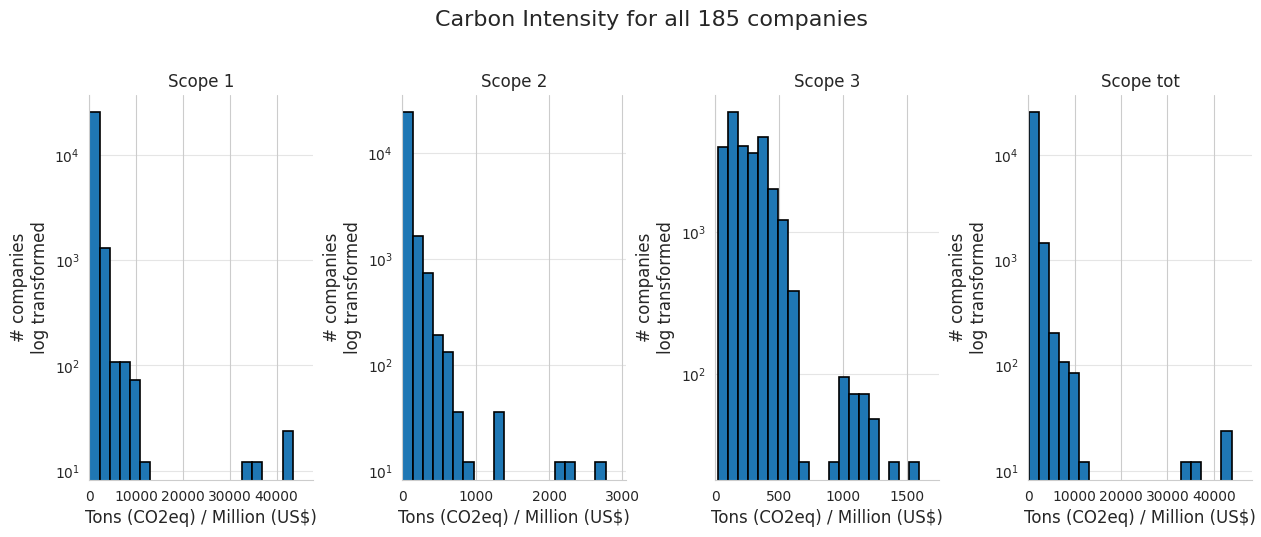

In [ ]:


def get_hist_plot(data: pd.DataFrame, columns: list[str], title='Histogram', color=None, log=False):
    '''
    Function that creates a histogram plot on the given data for the given columns.
    xticks_rotation: rotation of xticks in degrees
    '''
    fig, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

    # Plot each set of data in a different subplot
    for i, col in enumerate(columns):
        # Calculate x-limits based on data in the column
        x_min = data[col].min()
        x_max = data[col].max()
        x_range = x_max - x_min
        x_min = max(0, x_min - 0.1 * x_range)
        x_max += 0.1 * x_range
        axs[i].hist(data[col], log=log, bins=20, edgecolor='black', linewidth=1.2, color=color)
        axs[i].set_xlim([x_min, x_max])
        axs[i].set_title(col.replace('_', ' '), fontsize=12)
        axs[i].set_xlabel('Tons (CO2eq) / Million (US$)', fontsize=12)
        axs[i].set_ylabel('# observations \nlog transformed', fontsize=12)
        axs[i].tick_params(axis='both', which='major', labelsize=10)
        axs[i].grid(axis='y', alpha=0.5)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
    fig.suptitle(title, fontsize=16, y=1.05)
    # Increase spacing between subplots
    fig.subplots_adjust(wspace=0.4)
    return plt

number_of_companies = len(df_nrg_intensity['ISIN'].unique())

get_hist_plot(data=df_nrg_intensity, columns=scopes, title=f'Carbon Intensity for all {number_of_companies} companies', log=True).show()


### Q2

In Question 4 of Homework 1, you calculated efficient portfolios with various target returns. Take these portfolios, calculate and report the weighted-average E/S/G score or weighted-average carbon intensity of these portfolios (you can take the average score/carbon intensity for each firm over time). Comment on the E/S/G score or carbon intensity of the portfolios. Which firms (e.g. top 10; report firm names along with ISIN) are driving the E/S/G score down or driving the carbon intensity up? Plot on the volatility-E/S/G score (carbon intensity) space the various portfolios (i.e., make a plot similar to the efficient frontier except that E/S/G score or carbon intensity replaces the return on the y-axis). (15 points)



In [ ]:
#Display dataframe with the returns, market cap and ESG scores
df_q2 = df_nrg_intensity_noNaN_2015_2019.sort_values('date').copy()
df_q2 = df_q2.sort_values(['date','ISIN']).reset_index(drop=True)
df_q2

date  year  month          ISIN  monthly_return       market_cap  \
0      2005-01-31  2005      1  AN8068571086          0.0126              NaN   
1      2005-01-31  2005      1  ARP9897X1319          0.0287              NaN   
2      2005-01-31  2005      1  AU000000ERA9          0.0324              NaN   
3      2005-01-31  2005      1  AU000000ORG5          0.0014              NaN   
4      2005-01-31  2005      1  AU000000PDN8         -0.0589              NaN   
...           ...   ...    ...           ...             ...              ...   
27643  2020-12-31  2020     12  US8454671095          0.0688  2004840000.0000   
27644  2020-12-31  2020     12  US9026531049          0.1781 11316900000.0000   
27645  2020-12-31  2020     12  US91913Y1001          0.3881 23068600000.0000   
27646  2020-12-31  2020     12  US9694571004          0.1135 24332400000.0000   
27647  2020-12-31  2020     12  ZAE000006896          0.4060  5755510000.0000   

       annual_returns  Scope_1  Scope_2  Scope_3  Scope_tot  
0              0.4680 135.8217  15.1758 291.2881   442.2856  
1              0.3843      NaN      NaN      NaN        NaN  
2              0.9657 534.1543 323.5086 182.2743  1039.9372  
3              0.0347 971.6591   6.1233 163.7381  1141.5205  
4              1.7959      NaN      NaN      NaN        NaN  
...               ...      ...      ...      ...        ...  
27643          0.8441      NaN      NaN      NaN        NaN  
27644         -0.0719      NaN      NaN      NaN        NaN  
27645         -0.1789      NaN      NaN      NaN        NaN  
27646          0.1605      NaN      NaN      NaN        NaN  
27647          1.0305      NaN      NaN      NaN        NaN  

[27648 rows x 11 columns]

In [ ]:
# Create a list of all ISIN
firms_list = df_q2.ISIN.unique().tolist()

# retrieve a list of 100 companies that have scope 1,2,3 available between 2015 and 2019
randfirms = random.sample(firms_list, 100)
randfirms.sort()

In [ ]:
#Sort the df_q2 dataframe to only include those firms
df_q2_100 = df_q2[df_q2.ISIN.isin(randfirms) == True]
df_q2_100

date  year  month          ISIN  monthly_return       market_cap  \
0      2005-01-31  2005      1  AN8068571086          0.0126              NaN   
1      2005-01-31  2005      1  ARP9897X1319          0.0287              NaN   
2      2005-01-31  2005      1  AU000000ERA9          0.0324              NaN   
4      2005-01-31  2005      1  AU000000PDN8         -0.0589              NaN   
5      2005-01-31  2005      1  AU000000WHC8             NaN              NaN   
...           ...   ...    ...           ...             ...              ...   
27641  2020-12-31  2020     12  US7237871071          0.2053 18736800000.0000   
27642  2020-12-31  2020     12  US75281A1097          0.1032  1717430000.0000   
27643  2020-12-31  2020     12  US8454671095          0.0688  2004840000.0000   
27644  2020-12-31  2020     12  US9026531049          0.1781 11316900000.0000   
27645  2020-12-31  2020     12  US91913Y1001          0.3881 23068600000.0000   

       annual_returns  Scope_1  Scope_2  Scope_3  Scope_tot  
0              0.4680 135.8217  15.1758 291.2881   442.2856  
1              0.3843      NaN      NaN      NaN        NaN  
2              0.9657 534.1543 323.5086 182.2743  1039.9372  
4              1.7959      NaN      NaN      NaN        NaN  
5              0.0000      NaN      NaN      NaN        NaN  
...               ...      ...      ...      ...        ...  
27641          0.0264      NaN      NaN      NaN        NaN  
27642          1.7133      NaN      NaN      NaN        NaN  
27643          0.8441      NaN      NaN      NaN        NaN  
27644         -0.0719      NaN      NaN      NaN        NaN  
27645         -0.1789      NaN      NaN      NaN        NaN  

[19200 rows x 11 columns]

In [ ]:
#Create a df_q2 dataframe with only the selected firms and the years between 2015 and 2019
df_q2_100_2015 = df_q2_100[(df_q2_100['date']>'2014-12-31') & (df_q2_100['date']<'2020-01-31')].copy()
df_q2_100_2015 = df_q2_100_2015.reset_index(drop=True)
df_q2_100_2015

date  year  month          ISIN  monthly_return        market_cap  \
0     2015-01-31  2015      1  AN8068571086          0.0067 105073000000.0000   
1     2015-01-31  2015      1  ARP9897X1319         -0.1649  13166400000.0000   
2     2015-01-31  2015      1  AU000000ERA9         -0.0055    524697000.0000   
3     2015-01-31  2015      1  AU000000PDN8          0.1014    491925000.0000   
4     2015-01-31  2015      1  AU000000WHC8          0.1887    988069000.0000   
...          ...   ...    ...           ...             ...               ...   
5995  2019-12-31  2019     12  US7237871071         -0.0061  25073900000.0000   
5996  2019-12-31  2019     12  US75281A1097         -0.2094   1219420000.0000   
5997  2019-12-31  2019     12  US8454671095         -0.1374   1309940000.0000   
5998  2019-12-31  2019     12  US9026531049         -0.0593  13757300000.0000   
5999  2019-12-31  2019     12  US91913Y1001         -0.0338  38457600000.0000   

      annual_returns  Scope_1  Scope_2  Scope_3  Scope_tot  
0            -0.0271  39.6211  16.3495 236.8802   292.8508  
1            -0.3131 171.2095  34.4742 331.9980   537.6818  
2            -0.9176 176.6237 277.8118 121.3996   575.8350  
3            -0.3325 411.9399 325.3133 121.6421   858.8953  
4            -0.2167 712.3078  20.0847 220.3390   952.7316  
...              ...      ...      ...      ...        ...  
5995         -0.1456 464.8462  66.1281  99.1090   630.0833  
5996         -1.2013 417.3997  49.9731  99.0655   566.4383  
5997         -0.6910 246.1290  16.5231 180.0325   442.6845  
5998          0.1307  12.8810  57.1847  30.4164   100.4821  
5999          0.2787 186.4196  31.2452 440.2454   657.9102  

[6000 rows x 11 columns]

In [ ]:
#Get the result dataframe from Homework 1
url_h1 = 'https://raw.githubusercontent.com/GuillaumeR16/financelecture/main/nrg_returns_H1.csv'

df_nrg_returns_H1 = pd.read_csv(url_h1)

#Filter the df to only include the 100 firms we need
filt = randfirms
filt.insert(0,'date')
df_nrg_returns_H1_100 = df_nrg_returns_H1[filt].copy()

#Compute the covariance matrix between 2005 and 2015 for the 100 firms
cov_mat_05to15_100 = df_nrg_returns_H1_100[df_nrg_returns_H1_100['date']< '2015-01-31'].copy()
cov_mat_05to15_100 = cov_mat_05to15_100.drop(columns='date').cov()
cov_mat_05to15_100

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
AN8068571086        0.0099        0.0030        0.0070        0.0105   
ARP9897X1319        0.0030        0.0146        0.0038        0.0065   
AU000000ERA9        0.0070        0.0038        0.0254        0.0227   
AU000000PDN8        0.0105        0.0065        0.0227        0.0431   
AU000000WHC8        0.0100        0.0068        0.0179        0.0242   
...                    ...           ...           ...           ...   
US7237871071        0.0094        0.0043        0.0092        0.0128   
US75281A1097        0.0050        0.0014        0.0074        0.0090   
US8454671095        0.0055        0.0034        0.0086        0.0104   
US9026531049        0.0034        0.0016        0.0038        0.0043   
US91913Y1001        0.0070        0.0052        0.0086        0.0128   

              AU000000WHC8  BMG2108M2182  BMG5320C1082  BMG7998G1069  \
AN8068571086        0.0100        0.0038        0.0057        0.0108   
ARP9897X1319        0.0068        0.0033        0.0034        0.0038   
AU000000ERA9        0.0179        0.0057        0.0075        0.0119   
AU000000PDN8        0.0242        0.0073        0.0111        0.0164   
AU000000WHC8        0.0418        0.0098        0.0115        0.0209   
...                    ...           ...           ...           ...   
US7237871071        0.0154        0.0036        0.0077        0.0130   
US75281A1097        0.0066        0.0016        0.0037        0.0072   
US8454671095        0.0083        0.0022        0.0056        0.0074   
US9026531049        0.0086        0.0017        0.0003        0.0062   
US91913Y1001        0.0101        0.0043        0.0050        0.0090   

              BRUGPAACNOR8  CA00208D4084  ...  US6267171022  US6745991058  \
AN8068571086        0.0021        0.0054  ...        0.0068        0.0061   
ARP9897X1319        0.0002        0.0032  ...        0.0031        0.0033   
AU000000ERA9        0.0006        0.0059  ...        0.0077        0.0066   
AU000000PDN8        0.0007        0.0088  ...        0.0101        0.0097   
AU000000WHC8        0.0044        0.0109  ...        0.0124        0.0127   
...                    ...           ...  ...           ...           ...   
US7237871071        0.0015        0.0082  ...        0.0090        0.0075   
US75281A1097        0.0027        0.0050  ...        0.0057        0.0045   
US8454671095        0.0029        0.0056  ...        0.0057        0.0052   
US9026531049        0.0018        0.0041  ...        0.0025        0.0032   
US91913Y1001        0.0025        0.0059  ...        0.0071        0.0073   

              US6752321025  US69047Q1022  US7034811015  US7237871071  \
AN8068571086        0.0087        0.0054        0.0090        0.0094   
ARP9897X1319        0.0030        0.0034        0.0048        0.0043   
AU000000ERA9        0.0083        0.0080        0.0079        0.0092   
AU000000PDN8        0.0113        0.0093        0.0120        0.0128   
AU000000WHC8        0.0134        0.0102        0.0137        0.0154   
...                    ...           ...           ...           ...   
US7237871071        0.0112        0.0087        0.0122        0.0180   
US75281A1097        0.0058        0.0062        0.0065        0.0074   
US8454671095        0.0063        0.0080        0.0083        0.0082   
US9026531049        0.0048        0.0028        0.0053        0.0049   
US91913Y1001        0.0093        0.0076        0.0086        0.0092   

              US75281A1097  US8454671095  US9026531049  US91913Y1001  
AN8068571086        0.0050        0.0055        0.0034        0.0070  
ARP9897X1319        0.0014        0.0034        0.0016        0.0052  
AU000000ERA9        0.0074        0.0086        0.0038        0.0086  
AU000000PDN8        0.0090        0.0104        0.0043        0.0128  
AU000000WHC8        0.0066        0.0083        0.0086        0.0101  
...                    ...           ...           ...           ...

In [ ]:
#Define a dataframe with only the revenues for the 100 firms
df_ret_q2_100 = df_nrg_returns_H1_100.set_index('date')
df_ret_q2_100

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
date                                                                 
2005-01-31        0.0126        0.0287        0.0324       -0.0589   
2005-02-28        0.0635        0.0947        0.5098        0.8182   
2005-03-31        0.0930        0.2582        0.1888        0.3734   
2005-04-30       -0.0384       -0.1032       -0.1304       -0.1144   
2005-05-31       -0.0271       -0.0116       -0.0490       -0.0061   
...                  ...           ...           ...           ...   
2020-08-31        0.0564        0.2866        0.0598        0.2214   
2020-09-30        0.0019       -0.1433        0.1022        0.4129   
2020-10-31       -0.1943       -0.2587       -0.1122       -0.2556   
2020-11-30        0.0380       -0.0832       -0.0522       -0.0952   
2020-12-31        0.3604        0.4594        0.1159        0.4802   

            AU000000WHC8  BMG2108M2182  BMG5320C1082  BMG7998G1069  \
date                                                                 
2005-01-31           NaN       -0.0005       -0.0165           NaN   
2005-02-28           NaN       -0.0122       -0.0683           NaN   
2005-03-31           NaN        0.1635        0.1229           NaN   
2005-04-30           NaN        0.1405        0.0000           NaN   
2005-05-31           NaN        0.0004       -0.0621           NaN   
...                  ...           ...           ...           ...   
2020-08-31       -0.0519        0.0020        0.2929       -0.2500   
2020-09-30       -0.3015       -0.0349       -0.1325       -0.3333   
2020-10-31        0.1938       -0.1472       -0.0977        0.0000   
2020-11-30       -0.0816       -0.1065       -0.0119       -0.5000   
2020-12-31        0.3893        0.0581        0.1951        1.0000   

            BRUGPAACNOR8  CA00208D4084  ...  US6267171022  US6745991058  \
date                                    ...                               
2005-01-31        0.0180        0.0402  ...       -0.0732       -0.0341   
2005-02-28        0.0228        0.0683  ...        0.1837        0.0504   
2005-03-31        0.0392       -0.0213  ...        0.0762        0.1668   
2005-04-30       -0.0186        0.0100  ...        0.0415        0.0670   
2005-05-31        0.0542       -0.0948  ...       -0.1028       -0.0494   
...                  ...           ...  ...           ...           ...   
2020-08-31        0.0132        0.2608  ...        0.0000       -0.1241   
2020-09-30        0.0822        0.1969  ...        0.0460       -0.1816   
2020-10-31       -0.1004       -0.1167  ...       -0.3913       -0.2236   
2020-11-30       -0.1767        0.1325  ...       -0.0593       -0.0031   
2020-12-31        0.4211       -0.0418  ...        0.2854        0.5679   

            US6752321025  US69047Q1022  US7034811015  US7237871071  \
date                                                                 
2005-01-31       -0.0247       -0.0327       -0.0438       -0.0138   
2005-02-28        0.0763        0.1114        0.0741        0.1382   
2005-03-31        0.0018        0.1047        0.2342        0.0808   
2005-04-30       -0.0124        0.0842        0.0621        0.0534   
2005-05-31       -0.1151       -0.0716       -0.0283       -0.0753   
...                  ...           ...           ...           ...   
2020-08-31       -0.0895        0.0508        0.2135        0.0245   
2020-09-30       -0.0255        0.1303       -0.0152        0.0525   
2020-10-31       -0.3495       -0.3318       -0.3357       -0.1736   
2020-11-30        0.2155        0.3136        0.0817       -0.0209   
2020-12-31        0.5319        0.3199        0.6205        0.2053   

            US75281A1097  US8454671095  US9026531049  US91913Y1001  
date                                                                
2005-01-31       -0.0483       -0.1061        0.0478       -0.0354  
2005-02-28        0.1712        0.1501       -0.0691        0.3228  
2005-03-31        0.0729   

In [ ]:
#Define a dataframe with only the revenues for the 100 firms after 2015 and before 2020
df_ret_q2_100_2015 = df_nrg_returns_H1_100[(df_nrg_returns_H1_100['date']>'2014-12-31') & (df_nrg_returns_H1_100['date']<'2020-01-31')].set_index('date')
df_ret_q2_100_2015

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
date                                                                 
2015-01-31        0.0067       -0.1649       -0.0055        0.1014   
2015-02-28       -0.0090       -0.1005       -0.0447       -0.0180   
2015-03-31        0.0056        0.0450        0.0261        0.0356   
2015-04-30       -0.0040        0.0954       -0.0868       -0.0464   
2015-05-31        0.1035        0.0564        0.1228       -0.0265   
2015-06-30       -0.0199       -0.1107       -0.0531       -0.1376   
2015-07-31       -0.0700        0.0870       -0.6970       -0.1530   
2015-08-31       -0.0263       -0.1571       -0.1221       -0.3017   
2015-09-30       -0.0752       -0.0412       -0.0859       -0.0578   
2015-10-31       -0.1030       -0.3026       -0.0701       -0.0770   
2015-11-30        0.1741        0.4052        0.0460        0.3898   
2015-12-31       -0.0095       -0.1251        0.0527       -0.0415   
2016-01-31       -0.1077       -0.3708        0.0384        0.0623   
2016-02-29        0.0245       -0.0211       -0.0659       -0.1275   
2016-03-31        0.0430        0.0772       -0.0344       -0.1315   
2016-04-30       -0.0255       -0.0021        0.1480        0.3280   
2016-05-31        0.1009        0.1080       -0.0295        0.1284   
2016-06-30       -0.0384        0.0583       -0.0352       -0.2142   
2016-07-31        0.0482       -0.0658        0.0315       -0.0876   
2016-08-31       -0.0133       -0.0671        0.0096       -0.0165   
2016-09-30        0.0064       -0.0508       -0.0287       -0.1092   
2016-10-31        0.0056        0.0714        0.0000       -0.0773   
2016-11-30       -0.0025       -0.0582        0.0148       -0.1334   
2016-12-31        0.0751       -0.0424       -0.0630       -0.5168   
2017-01-31       -0.0019        0.0373        0.2897        0.2940   
2017-02-28       -0.0093        0.2507        0.6818        0.5181   
2017-03-31       -0.0048       -0.0100       -0.1113       -0.1096   
2017-04-30       -0.0555        0.1649        0.0742       -0.0520   
2017-05-31       -0.0695        0.0501       -0.1357       -0.0087   
2017-06-30       -0.0278       -0.0343       -0.1214       -0.5331   
2017-07-31       -0.0403       -0.1083       -0.0636       -0.0269   
2017-08-31        0.0305       -0.1038        0.1885        0.0445   
2017-09-30       -0.0748        0.0049        0.0552       -0.0015   
2017-10-31        0.0942        0.1548       -0.0187       -0.0186   
2017-11-30       -0.0727        0.0534       -0.0285       -0.0195   
2017-12-31        0.0070       -0.0605        0.4760       -0.0102   
2018-01-31        0.0493       -0.0157        0.1221        0.0299   
2018-02-28        0.1205        0.0803       -0.0414        0.0260   
2018-03-31       -0.1302       -0.0623       -0.2560        2.4915   
2018-04-30       -0.0267       -0.0625       -0.2604       -0.0105   
2018-05-31        0.0775        0.0359        0.0460       -0.2252   
2018-06-30        0.0082       -0.1783       -0.0375        0.1232   
2018-07-31       -0.0475       -0.2880       -0.2339        0.1306   
2018-08-31        0.0222        0.2319        0.0233        0.1550   
2018-09-30       -0.0525       -0.1033       -0.0625       -0.0983   
2018-10-31       -0.0170        0.0339        0.0273        0.0542   
2018-11-30       -0.1612        0.0693       -0.1313       -0.0810   
2018-12-31       -0.1038       -0.0155       -0.1392        0.1089   
2019-01-31       -0.2119       -0.1422       -0.1913       -0.1168   
2019-02-28        0.2350        0.2402        0.1146        0.0023   
2019-03-31        0.0256       -0.1564        0.1794       -0.0784   
2019-04-30       -0.0095        0.0325       -0.1373       -0.1177   
2019-05-31       -0.0757       -0.0569       -0.1376       -0.0799   
2019-06-30       -0.1421        0.1054       -0.1546       -0.1582   
2019-07-31        0.1234        0.2385       -0.0236        0.0887   
2019-08-31       -0.02

In [ ]:
#Getting the function of question 4 homework 1 to compute the different portfolios

volatility_list = []
return_list = []
scope_list = []
portfolio_list = []
month_cov_matrix = cov_mat_05to15_100

# optimal min var weights for a given return mu
def create_port (mu):
    """mu represents the target portfolio return """

    from scipy.optimize import minimize
    
    #creating a dataframe with the weights
    df_min_var_weights = pd.DataFrame()

    returns = df_ret_q2_100_2015

    def objective(weights, month_cov_matrix):
        return weights.T @ month_cov_matrix @ weights

    def constraint1(weights):
        return weights.sum() - 1

    def constraint2(weights):
        return (weights @ returns.T).sum() - mu*5

    constraints = [{'type': 'eq', 'fun': constraint1},
                   {'type': 'eq', 'fun': constraint2}]

    bounds = tuple((0, 1) for x in range(100))

    weights = np.ones(100) / 100

    result = minimize(objective, weights, args=month_cov_matrix, constraints=constraints, bounds=bounds)

    min_var_weights = result.x / np.sum(result.x)
    
    min_var = result.fun

    min_var_weights = list(min_var_weights)

    for i in range(60):
        portfolio_weights = pd.Series(min_var_weights)
        df_min_var_weights = pd.concat([df_min_var_weights, portfolio_weights], ignore_index=True)

    df_min_var_weights.columns.values[0] = f"{mu}_var_weights"
    
    #Adding the weights to the df_q4 database
    df_q2_100_2015[f'{mu}_weights'] = df_min_var_weights[f'{mu}_var_weights']
    #computing the monthly returns for each ISIN based on the market cap weight per month
    df_q2_100_2015[f'{mu}_assets_monthly_weighted_returns'] = df_q2_100_2015['monthly_return']*df_q2_100_2015[f'{mu}_weights']

    #computing the AAR of the minvar-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 5 years of data
    df_q2_100_2015[f'{mu}_AAR'] = df_q2_100_2015[f'{mu}_assets_monthly_weighted_returns'].sum()/5

    #computing the annual return of the value-weighted portfolio 
    annual_return_df = df_q2_100_2015[['year',f'{mu}_assets_monthly_weighted_returns']].groupby('year').sum()
    def annual_return_func(row):
        year = row['year']
        return annual_return_df.loc[(year)][0]
    df_q2_100_2015[f'{mu}_annual_return'] = df_q2_100_2015.apply(annual_return_func, axis=1)

    #computing the monthly return of the value-weighted portfolio 
    monthly_returns_df = df_q2_100_2015[['year','month',f'{mu}_assets_monthly_weighted_returns']].groupby(['year','month']).sum()

    def monthly_returns_func(row):
        year = row['year']
        month = row['month']
        return monthly_returns_df.loc[(year,month)][0]

    df_q2_100_2015[f'{mu}_monthly_returns'] = df_q2_100_2015.apply(monthly_returns_func, axis=1)

    # computing portfolio volatility
    df_q2_100_2015[f'{mu}_annualized_volatility'] = math.sqrt(min_var*12) 
    
    #computing the weighted scope 1,2,3 for each asset
    df_q2_100_2015[f'{mu}_Scope_1'] = df_q2_100_2015[f'{mu}_weights'] * df_q2_100_2015['Scope_1']
    df_q2_100_2015[f'{mu}_Scope_2'] = df_q2_100_2015[f'{mu}_weights'] * df_q2_100_2015['Scope_2']
    df_q2_100_2015[f'{mu}_Scope_3'] = df_q2_100_2015[f'{mu}_weights'] * df_q2_100_2015['Scope_3']
    
    #computing the weighted average scopes of the portfolio for each scope
    df_q2_100_2015[f'{mu}_WA_Scope_1'] = df_q2_100_2015[f'{mu}_Scope_1'].mean()*100
    df_q2_100_2015[f'{mu}_WA_Scope_2'] = df_q2_100_2015[f'{mu}_Scope_2'].mean()*100
    df_q2_100_2015[f'{mu}_WA_Scope_3'] = df_q2_100_2015[f'{mu}_Scope_3'].mean()*100
    
    #computing the weighted average carbon intensity across the three scopes
    df_q2_100_2015[f'{mu}_WA_All_Scopes'] = (df_q2_100_2015[f'{mu}_WA_Scope_1']+df_q2_100_2015[f'{mu}_WA_Scope_2']+df_q2_100_2015[f'{mu}_WA_Scope_3'])
    
    #creating lists of metrics
    volatility_list.append(df_q2_100_2015[f'{mu}_annualized_volatility'].values[0])
    return_list.append(df_q2_100_2015[f'{mu}_AAR'].values[0])
    scope_list.append(df_q2_100_2015[f'{mu}_WA_All_Scopes'].values[0])
    portfolio_list.append(f'{mu}_portfolio')

In [ ]:
#Compute the portfolios between 2% and 50% return
for i in range(2, 50, 2):
    create_port(i/100)

#Display the dataframe with the newly computed portfolios
df_q2_100_2015

date  year  month          ISIN  monthly_return        market_cap  \
0     2015-01-31  2015      1  AN8068571086          0.0067 105073000000.0000   
1     2015-01-31  2015      1  ARP9897X1319         -0.1649  13166400000.0000   
2     2015-01-31  2015      1  AU000000ERA9         -0.0055    524697000.0000   
3     2015-01-31  2015      1  AU000000PDN8          0.1014    491925000.0000   
4     2015-01-31  2015      1  AU000000WHC8          0.1887    988069000.0000   
...          ...   ...    ...           ...             ...               ...   
5995  2019-12-31  2019     12  US7237871071         -0.0061  25073900000.0000   
5996  2019-12-31  2019     12  US75281A1097         -0.2094   1219420000.0000   
5997  2019-12-31  2019     12  US8454671095         -0.1374   1309940000.0000   
5998  2019-12-31  2019     12  US9026531049         -0.0593  13757300000.0000   
5999  2019-12-31  2019     12  US91913Y1001         -0.0338  38457600000.0000   

      annual_returns  Scope_1  Scope_2  Scope_3  ...  0.48_annual_return  \
0            -0.0271  39.6211  16.3495 236.8802  ...              0.2896   
1            -0.3131 171.2095  34.4742 331.9980  ...              0.2896   
2            -0.9176 176.6237 277.8118 121.3996  ...              0.2896   
3            -0.3325 411.9399 325.3133 121.6421  ...              0.2896   
4            -0.2167 712.3078  20.0847 220.3390  ...              0.2896   
...              ...      ...      ...      ...  ...                 ...   
5995         -0.1456 464.8462  66.1281  99.1090  ...             -0.1232   
5996         -1.2013 417.3997  49.9731  99.0655  ...             -0.1232   
5997         -0.6910 246.1290  16.5231 180.0325  ...             -0.1232   
5998          0.1307  12.8810  57.1847  30.4164  ...             -0.1232   
5999          0.2787 186.4196  31.2452 440.2454  ...             -0.1232   

      0.48_monthly_returns  0.48_annualized_volatility  0.48_Scope_1  \
0                  -0.2360                      0.6790        0.0000   
1                  -0.2360                      0.6790        0.0000   
2                  -0.2360                      0.6790        0.0000   
3                  -0.2360                      0.6790        0.0000   
4                  -0.2360                      0.6790        0.0000   
...                    ...                         ...           ...   
5995               -0.0528                      0.6790        0.0000   
5996               -0.0528                      0.6790        0.0000   
5997               -0.0528                      0.6790        0.0000   
5998               -0.0528                      0.6790        0.0000   
5999               -0.0528                      0.6790        0.0000   

      0.48_Scope_2  0.48_Scope_3  0.48_WA_Scope_1  0.48_WA_Scope_2  \
0           0.0000        0.0000        2813.6761          74.6593   
1           0.0000        0.0000        2813.6761          74.6593   
2           0.0000        0.0000        2813.6761          74.6593   
3           0.0000        0.0000        2813.6761          74.6593   
4           0.0000        0.0000        2813.6761          74.6593   
...            ...           ...              ...              ...   
5995        0.0000        0.0000        2813.6761          74.6593   
5996        0.0000        0.0000        2813.6761          74.6593   
5997        0.0000        0.0000        2813.6761          74.6593   
5998        0.0000        0.0000        2813.6761          74.6593   
5999        0.0000        0.0000        2813.6761          74.6593   

      0.48_WA_Scope_3  0.48_WA_All_Scopes  
0            238.5783           3126.9137  
1            238.5783           3126.9137  
2            238.5783           3126.9137  
3            238.5783           3126.9137  
4            238.5783           3126.9137  
...               ...                 ...  
5995         238.5783           3126.9137  
5996         238.5783           3126.9137  
5997         238.5783   

In [ ]:
#computing the AAR for every assets
asset_AAR_df = df_q2_100_2015[['ISIN','monthly_return']].groupby('ISIN').sum()/5
def asset_AAR_func(row):
    ISIN = row['ISIN']
    return asset_AAR_df.loc[(ISIN)][0]
df_q2_100_2015['assets_AAR'] = df_q2_100_2015.apply(asset_AAR_func, axis=1)

#computing the Annualized volatility for every assets:
asset_volatility_df = df_q2_100[df_q2_100['year']<2015][['ISIN','monthly_return']].groupby('ISIN').std()*math.sqrt(12)#df_q2_100_2015[['ISIN','monthly_return']].groupby('ISIN').std()*math.sqrt(12)
def asset_volatility_func(row):
    ISIN = row['ISIN']
    return asset_volatility_df.loc[(ISIN)][0]
df_q2_100_2015['assets_volatility'] = df_q2_100_2015.apply(asset_volatility_func, axis=1)

#computing the sharpe ratio:
df_q2_100_2015['assets_SharpeRatio']= (df_q2_100_2015['assets_AAR']-risk_free_rate)/df_q2_100_2015['assets_volatility']

#computing the average carbon intensity per asset:
asset_Carbon_df = df_q2_100_2015[['ISIN','Scope_1','Scope_2','Scope_3']].groupby('ISIN').sum()/60
asset_Carbon_df['All_Scope'] = asset_Carbon_df['Scope_1']+asset_Carbon_df['Scope_2']+asset_Carbon_df['Scope_3']
asset_Carbon_df
def asset_Carbon_func(row):
    ISIN = row['ISIN']
    return asset_Carbon_df.loc[(ISIN)][3]
df_q2_100_2015['assets_Carbon_Intensity'] = df_q2_100_2015.apply(asset_Carbon_func, axis=1)

#Displaying the dataset
df_q2_100_2015

date  year  month          ISIN  monthly_return        market_cap  \
0     2015-01-31  2015      1  AN8068571086          0.0067 105073000000.0000   
1     2015-01-31  2015      1  ARP9897X1319         -0.1649  13166400000.0000   
2     2015-01-31  2015      1  AU000000ERA9         -0.0055    524697000.0000   
3     2015-01-31  2015      1  AU000000PDN8          0.1014    491925000.0000   
4     2015-01-31  2015      1  AU000000WHC8          0.1887    988069000.0000   
...          ...   ...    ...           ...             ...               ...   
5995  2019-12-31  2019     12  US7237871071         -0.0061  25073900000.0000   
5996  2019-12-31  2019     12  US75281A1097         -0.2094   1219420000.0000   
5997  2019-12-31  2019     12  US8454671095         -0.1374   1309940000.0000   
5998  2019-12-31  2019     12  US9026531049         -0.0593  13757300000.0000   
5999  2019-12-31  2019     12  US91913Y1001         -0.0338  38457600000.0000   

      annual_returns  Scope_1  Scope_2  Scope_3  ...  0.48_Scope_2  \
0            -0.0271  39.6211  16.3495 236.8802  ...        0.0000   
1            -0.3131 171.2095  34.4742 331.9980  ...        0.0000   
2            -0.9176 176.6237 277.8118 121.3996  ...        0.0000   
3            -0.3325 411.9399 325.3133 121.6421  ...        0.0000   
4            -0.2167 712.3078  20.0847 220.3390  ...        0.0000   
...              ...      ...      ...      ...  ...           ...   
5995         -0.1456 464.8462  66.1281  99.1090  ...        0.0000   
5996         -1.2013 417.3997  49.9731  99.0655  ...        0.0000   
5997         -0.6910 246.1290  16.5231 180.0325  ...        0.0000   
5998          0.1307  12.8810  57.1847  30.4164  ...        0.0000   
5999          0.2787 186.4196  31.2452 440.2454  ...        0.0000   

      0.48_Scope_3  0.48_WA_Scope_1  0.48_WA_Scope_2  0.48_WA_Scope_3  \
0           0.0000        2813.6761          74.6593         238.5783   
1           0.0000        2813.6761          74.6593         238.5783   
2           0.0000        2813.6761          74.6593         238.5783   
3           0.0000        2813.6761          74.6593         238.5783   
4           0.0000        2813.6761          74.6593         238.5783   
...            ...              ...              ...              ...   
5995        0.0000        2813.6761          74.6593         238.5783   
5996        0.0000        2813.6761          74.6593         238.5783   
5997        0.0000        2813.6761          74.6593         238.5783   
5998        0.0000        2813.6761          74.6593         238.5783   
5999        0.0000        2813.6761          74.6593         238.5783   

      0.48_WA_All_Scopes  assets_AAR  assets_volatility  assets_SharpeRatio  \
0              3126.9137     -0.0995             0.3439             -0.3910   
1              3126.9137     -0.1210             0.4189             -0.3723   
2              3126.9137     -0.1748             0.5521             -0.3799   
3              3126.9137      0.1579             0.7190              0.1710   
4              3126.9137      0.3540             0.7080              0.4505   
...                  ...         ...                ...                 ...   
5995           3126.9137      0.0186             0.4652             -0.0352   
5996           3126.9137     -0.4620             0.3336             -1.4899   
5997           3126.9137     -0.3721             0.4133             -0.9850   
5998           3126.9137      0.1286             0.3221              0.2908   
5999           3126.9137      0.2159             0.4417              0.4095   

      assets_Carbon_Intensity  
0                    319.4144  
1                   1392.2939  
2                    629.9649  
3                   1922.7996  
4                   1066.2815  
...                       ...  
5995                 849.4087  
5996                 597.7062  
5997                1067.6675  
5998                 105.4320  
5999                

In [ ]:
#Creating a results list with all the key portfolio statistics
results_list = []
for i in range (len(volatility_list)): 
    results_list.append([volatility_list[i],return_list[i]])
    results_list[i].append(scope_list[i])

#Computing the sharpe ratio for all the created portfolio
for i in range (int(len(results_list))):
    sharpe_ratio = (results_list[i][1]-risk_free_rate)/(results_list[i][0])
    results_list[i].append(sharpe_ratio)
    
# Define the lists to be used as index, values, and column names
index_list = portfolio_list
values_list = results_list
column_names = ['Portfolio volatility','Portfolio return','Portfolio Weighted Average Carbon Intensity','Portfolio Sharpe ratio']

# Create a pandas DataFrame
df = pd.DataFrame(values_list, index=index_list, columns=column_names)

In [ ]:
#display the portfolio statistics
df

Portfolio volatility  Portfolio return  \
0.02_portfolio                0.1305            0.0200   
0.04_portfolio                0.1278            0.0400   
0.06_portfolio                0.1262            0.0600   
0.08_portfolio                0.1275            0.0800   
0.1_portfolio                 0.1314            0.1000   
0.12_portfolio                0.1377            0.1200   
0.14_portfolio                0.1459            0.1400   
0.16_portfolio                0.1554            0.1600   
0.18_portfolio                0.1676            0.1800   
0.2_portfolio                 0.1817            0.2000   
0.22_portfolio                0.1977            0.2200   
0.24_portfolio                0.2165            0.2400   
0.26_portfolio                0.2359            0.2600   
0.28_portfolio                0.2586            0.2800   
0.3_portfolio                 0.2864            0.3000   
0.32_portfolio                0.3192            0.3200   
0.34_portfolio                0.3567            0.3400   
0.36_portfolio                0.4146            0.3600   
0.38_portfolio                0.6268            0.3800   
0.4_portfolio                 0.6790            0.3838   
0.42_portfolio                0.6790            0.3838   
0.44_portfolio                0.6790            0.3838   
0.46_portfolio                0.6790            0.3838   
0.48_portfolio                0.6790            0.3838   

                Portfolio Weighted Average Carbon Intensity  \
0.02_portfolio                                     711.7315   
0.04_portfolio                                     719.4926   
0.06_portfolio                                     728.5054   
0.08_portfolio                                     649.3085   
0.1_portfolio                                      618.6637   
0.12_portfolio                                     575.3691   
0.14_portfolio                                     542.0115   
0.16_portfolio                                     540.2159   
0.18_portfolio                                     572.1810   
0.2_portfolio                                      580.1449   
0.22_portfolio                                     595.9726   
0.24_portfolio                                     662.9717   
0.26_portfolio                                     705.3618   
0.28_portfolio                                     737.5148   
0.3_portfolio                                      813.0292   
0.32_portfolio                                     878.9743   
0.34_portfolio                                     958.5567   
0.36_portfolio                                    1462.6806   
0.38_portfolio                                    2862.2443   
0.4_portfolio                                     3126.9137   
0.42_portfolio                                    3126.9137   
0.44_portfolio                                    3126.9137   
0.46_portfolio                                    3126.9137   
0.48_portfolio                                    3126.9137   

                Portfolio Sharpe ratio  
0.02_portfolio                 -0.1150  
0.04_portfolio                  0.0391  
0.06_portfolio                  0.1981  
0.08_portfolio                  0.3531  
0.1_portfolio                   0.4945  
0.12_portfolio                  0.6171  
0.14_portfolio                  0.7194  
0.16_portfolio                  0.8044  
0.18_portfolio                  0.8649  
0.2_portfolio                   0.9079  
0.22_portfolio                  0.9359  
0.24_portfolio                  0.9469  
0.26_portfolio                  0.9538  
0.28_portfolio                  0.9475  
0.3_portfolio                   0.9254  
0.32_portfolio                  0.8928  
0.34_portfolio                  0.8551  
0.36_portfolio                  0.7839  
0.38_portfolio                  0.5504  
0.4_portfolio                   0.5136  
0.42_portfolio                  0.5136  
0.44_portfolio                  0.5136  
0.46_portfolio                  0.5136  
0.48_

In [ ]:
#Plotting the efficient frontier
import plotly.graph_objs as go

# Define the x and y values
x = df['Portfolio volatility']
y = df['Portfolio return']
z = df['Portfolio Sharpe ratio']

# Define the color scale
color_scale = [[0, 'firebrick'], [0.5, 'lightblue'], [1, 'darkblue']]

# Create the scatter plot for the portfolio
trace_portfolio = go.Scatter(
    x=x,
    y=y,
    mode='lines+markers',
    marker=dict(
        size=8,
        color=z,
        colorscale=color_scale,
        cmin=-0.2,
        cmax=1,
        showscale=True
    ),
    line=dict(
        width=5,
        color= 'lightgrey',
    ),
    name='Portfolio',
    hovertemplate='Portfolio volatility: %{x}<br>Portfolio return: %{y}<br> Portfolio Sharpe ratio %{marker.color:.3f} <extra></extra>')

# Create the scatter plot for the assets
trace_assets = go.Scatter(
    x=df_q2_100_2015['assets_volatility'],
    y=df_q2_100_2015['assets_AAR'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_q2_100_2015['assets_SharpeRatio'],
        colorscale=color_scale,
        cmin=-0.2,
        cmax=1,
        colorbar=dict(
                title={
                    'text': 'Sharpe Ratio',
                    'side': 'right',
                    
                }
            ),
        showscale=True,
        symbol='x'
    ),
    name='Individual Assets',
    hovertemplate='Asset volatility: %{x}<br>Asset return: %{y}<br>Asset Sharpe Ratio: %{marker.color:.3f} <extra></extra>')


# Add axis labels and a title
layout = go.Layout(
    title='Return vs. Volatility',
    xaxis=dict(title='Volatility'),
    yaxis=dict(title='Return')
)


# Create a figure
fig = go.Figure(data=[trace_portfolio, trace_assets], layout=layout)

fig.update_layout(plot_bgcolor='white')

layout = go.Layout(
    title={
        'text': 'Return vs. Volatility',
        'x': 0.5
    },
    xaxis=dict(title='Volatility', showgrid=True),
    yaxis=dict(title='Return', showgrid=True),
    legend=dict(x=1,y=-0.2),
    autosize=True,
)

fig.update_layout(layout)


# Show the plot
fig.show()

In [ ]:
#Plotting the carbon intensity to volatility relationship
import plotly.graph_objs as go

# Define the x and y values
x = df['Portfolio volatility']
y = df['Portfolio Weighted Average Carbon Intensity']
z = df['Portfolio return']

# Define the color scale
color_scale = [[0, 'firebrick'], [0.2, 'lightblue'], [0.4, 'darkblue']]

# Create the scatter plot for the portfolio
trace_portfolio = go.Scatter(
    x=x,
    y=y,
    mode='lines+markers',
    marker=dict(
        size=8,
        color=z,
        colorscale=color_scale,
        cmin=-0,
        cmax=0.4,
        colorbar=dict(
                title={
                    'text': 'Portfolio/Asset return',
                    'side': 'right',
                    
                }
            ),
        showscale=True
    ),
    line=dict(
        width=5,
        color= 'lightgrey',
    ),
    name='Portfolio',
    hovertemplate='Portfolio volatility: %{x}<br>Portfolio Weighted Average Carbon Intensity: %{y}<br> Portfolio return %{marker.color:.3f} <extra></extra>')

# Create the scatter plot for the assets
trace_assets = go.Scatter(
    x=df_q2_100_2015['assets_volatility'],
    y=df_q2_100_2015['assets_Carbon_Intensity'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_q2_100_2015['assets_AAR'],
        colorscale=color_scale,
        cmin=-0.0,
        cmax=0.4,
        colorbar=dict(
                title={
                    'text': 'Portfolio/Asset return',
                    'side': 'right',
                    
                }
            ),
        showscale=True,
        symbol='x'
    ),
    name='Individual Assets',
    hovertemplate='Asset volatility: %{x}<br>Asset Carbon Intensity: %{y}<br>Asset AAR: %{marker.color:.3f} <extra></extra>')


# Add axis labels and a title
layout = go.Layout(
    title='Carbon intensity vs. Volatility',
    xaxis=dict(title='Volatility'),
    yaxis=dict(title='Carbon intensity')
)


# Create a figure
fig = go.Figure(data=[trace_portfolio, trace_assets], layout=layout)

fig.update_layout(plot_bgcolor='white')

layout = go.Layout(
    title={
        'text': 'Carbon intensity vs. Volatility',
        'x': 0.5
    },
    xaxis=dict(title='Volatility', showgrid=True),
    yaxis=dict(title='Carbon intensity', showgrid=True),
    legend=dict(x=1,y=-0.2),
    autosize=True,
)

fig.update_layout(layout)


# Show the plot
fig.show()

In [ ]:
#Creating a mapping of the ISIN and Company Names
df_ISIN_NAME = df_scope1_intensity[['ISIN','NAME']].copy()

A negative carbon intensity impact means that the asset drives the portfolio carbon intensity up.

In [ ]:
# import colormap
import matplotlib.cm as cm

#Create dataframe with firms driving carbon intensity up for the 0.26. return portfolio
top10_carbon_0_26_port = df_q2_100_2015[df_q2_100_2015['0.26_weights']!=0].copy()
top10_carbon_0_26_port['Carbon_Intensity_Impact'] = (df_q2_100_2015['0.26_WA_All_Scopes']-df_q2_100_2015['assets_Carbon_Intensity'])*df_q2_100_2015['0.26_weights']
top10_carbon_0_26_port= top10_carbon_0_26_port[['ISIN','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.26_weights','0.26_WA_All_Scopes','Carbon_Intensity_Impact']].groupby('ISIN').mean().sort_values('Carbon_Intensity_Impact',ascending=True).head(10)
top10_carbon_0_26_port = pd.merge(top10_carbon_0_26_port,df_ISIN_NAME, on='ISIN', how='left')

#Color code the display
def color_code(val):
    cmap = cm.get_cmap('cividis')
    normed = (val - top10_carbon_0_26_port['Carbon_Intensity_Impact'].min()) / (top10_carbon_0_26_port['Carbon_Intensity_Impact'].max() - top10_carbon_0_26_port['Carbon_Intensity_Impact'].min())
    rgba = cmap(normed)[:3]
    return 'background-color: rgba({},{},{},0.2)'.format(int(rgba[0]*255),int(rgba[1]*255),int(rgba[2]*255))

# apply color code to dataframe
top10_carbon_0_26_port[['ISIN','NAME','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.26_weights','Carbon_Intensity_Impact']].style.applymap(color_code, subset=['Carbon_Intensity_Impact'])

<ipython-input-221-ea1242af82d3>:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#Create dataframe with the firms driving the carbon intensity up for the 0.16 return portfolio
top10_carbon_0_16_port = df_q2_100_2015[df_q2_100_2015['0.16_weights']!=0].copy()
top10_carbon_0_16_port['Carbon_Intensity_Impact'] = (df_q2_100_2015['0.16_WA_All_Scopes']-df_q2_100_2015['assets_Carbon_Intensity'])*df_q2_100_2015['0.16_weights']
top10_carbon_0_16_port= top10_carbon_0_16_port[['ISIN','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.16_weights','0.16_WA_All_Scopes','Carbon_Intensity_Impact']].groupby('ISIN').mean().sort_values('Carbon_Intensity_Impact',ascending=True).head(10)
top10_carbon_0_16_port = pd.merge(top10_carbon_0_16_port,df_ISIN_NAME, on='ISIN', how='left')

#Color code the display
def color_code(val):
    cmap = cm.get_cmap('cividis')
    normed = (val - top10_carbon_0_16_port['Carbon_Intensity_Impact'].min()) / (top10_carbon_0_16_port['Carbon_Intensity_Impact'].max() - top10_carbon_0_16_port['Carbon_Intensity_Impact'].min())
    rgba = cmap(normed)[:3]
    return 'background-color: rgba({},{},{},0.2)'.format(int(rgba[0]*255),int(rgba[1]*255),int(rgba[2]*255))

# apply color code to dataframe
top10_carbon_0_16_port[['ISIN','NAME','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.16_weights','Carbon_Intensity_Impact']].style.applymap(color_code, subset=['Carbon_Intensity_Impact'])

<ipython-input-222-05ae8115c9e8>:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



#### Q2 Additionnal analysis 

In [ ]:
#Create dataframe
bottom10_carbon_0_16_port = df_q2_100_2015[df_q2_100_2015['0.16_weights']!=0].copy()
bottom10_carbon_0_16_port['Carbon_Intensity_Impact'] = (df_q2_100_2015['0.16_WA_All_Scopes']-df_q2_100_2015['assets_Carbon_Intensity'])*df_q2_100_2015['0.16_weights']
bottom10_carbon_0_16_port= bottom10_carbon_0_16_port[['ISIN','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.16_weights','0.16_WA_All_Scopes','Carbon_Intensity_Impact']].groupby('ISIN').mean().sort_values('Carbon_Intensity_Impact',ascending=False).head(10)
bottom10_carbon_0_16_port = pd.merge(bottom10_carbon_0_16_port,df_ISIN_NAME, on='ISIN', how='left')

#Color code the display
def color_code(val):
    cmap = cm.get_cmap('cividis')
    normed = (val - bottom10_carbon_0_16_port['Carbon_Intensity_Impact'].min()) / (bottom10_carbon_0_16_port['Carbon_Intensity_Impact'].max() - bottom10_carbon_0_16_port['Carbon_Intensity_Impact'].min())
    rgba = cmap(normed)[:3]
    return 'background-color: rgba({},{},{},0.2)'.format(int(rgba[0]*255),int(rgba[1]*255),int(rgba[2]*255))

# apply color code to dataframe
bottom10_carbon_0_16_port[['ISIN','NAME','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.16_weights','Carbon_Intensity_Impact']].style.applymap(color_code, subset=['Carbon_Intensity_Impact'])

<ipython-input-223-2ef48eb15b88>:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
# import colormap
import matplotlib.cm as cm

#Create dataframe with bottom 10 assets of the 0.26 return portfolio
bottom10_carbon_0_26_port = df_q2_100_2015[df_q2_100_2015['0.26_weights']!=0].copy()
bottom10_carbon_0_26_port['Carbon_Intensity_Impact'] = (df_q2_100_2015['0.26_WA_All_Scopes']-df_q2_100_2015['assets_Carbon_Intensity'])*df_q2_100_2015['0.26_weights']
bottom10_carbon_0_26_port= bottom10_carbon_0_26_port[['ISIN','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.26_weights','0.26_WA_All_Scopes','Carbon_Intensity_Impact']].groupby('ISIN').mean().sort_values('Carbon_Intensity_Impact',ascending=False).head(10)
bottom10_carbon_0_26_port = pd.merge(bottom10_carbon_0_26_port,df_ISIN_NAME, on='ISIN', how='left')

#Color code the display
def color_code(val):
    cmap = cm.get_cmap('cividis')
    normed = (val - bottom10_carbon_0_26_port['Carbon_Intensity_Impact'].min()) / (bottom10_carbon_0_26_port['Carbon_Intensity_Impact'].max() - bottom10_carbon_0_26_port['Carbon_Intensity_Impact'].min())
    rgba = cmap(normed)[:3]
    return 'background-color: rgba({},{},{},0.2)'.format(int(rgba[0]*255),int(rgba[1]*255),int(rgba[2]*255))

# apply color code to dataframe
bottom10_carbon_0_26_port[['ISIN','NAME','assets_Carbon_Intensity','assets_volatility','assets_AAR','0.26_weights','Carbon_Intensity_Impact']].style.applymap(color_code, subset=['Carbon_Intensity_Impact'])

<ipython-input-224-6722f3ffee61>:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
#Creating a dataframe with the bottom 10 carbon intensity ranking
bottom10_carbon = df_q2_100_2015[['ISIN','assets_Carbon_Intensity','assets_volatility','assets_AAR']].groupby('ISIN').mean().sort_values('assets_Carbon_Intensity').head(10)
bottom10_carbon = pd.merge(bottom10_carbon,df_ISIN_NAME, on='ISIN', how='left')
bottom10_carbon[['ISIN','NAME','assets_Carbon_Intensity','assets_volatility','assets_AAR']]

ISIN                        NAME  assets_Carbon_Intensity  \
0  CNE0000019T2          OFFS.OIL ENGR. 'A'                  68.5868   
1  PK0022501016  PAKISTAN STATE OIL COMPANY                  90.9550   
2  MYL5681OO001           PETRONAS DAGANGAN                 102.1924   
3  US9026531049                         UDR                 105.4320   
4  BRUGPAACNOR8     ULTRAPAR PARTICIPOES ON                 119.6332   
5  GB00B5N0P849           WOOD GROUP (JOHN)                 171.8812   
6  INE196A01026                      MARICO                 187.4401   
7  US03957W1062                    ARCHROCK                 271.4722   
8  SE0000825820               LUNDIN ENERGY                 273.9300   
9  JP3294460005                       INPEX                 274.5893   

   assets_volatility  assets_AAR  
0             0.4217      0.0524  
1             0.4158     -0.0022  
2             0.2297      0.0985  
3             0.3221      0.1286  
4             0.6860     -0.0500  
5             0.3829     -0.0528  
6             0.3207      0.1630  
7             0.4784      0.0361  
8             0.4706      0.2268  
9             0.3315      0.0441

In [ ]:
#Creating a dataframe with the top 10 carbon intensity ranking
top10_carbon = df_q2_100_2015[['ISIN','assets_Carbon_Intensity','assets_volatility','assets_AAR']].groupby('ISIN').mean().sort_values('assets_Carbon_Intensity',ascending=False).head(10)
top10_carbon = pd.merge(top10_carbon,df_ISIN_NAME, on='ISIN', how='left')
top10_carbon[['ISIN','NAME','assets_Carbon_Intensity','assets_volatility','assets_AAR']]

ISIN                                     NAME  \
0  CNE1000002R0                  CHINA SHENHUA EN.CO.'H'   
1  RU000A0B90N8                              RASPADSKAYA   
2  CNE100000528                    CHINA COAL ENERGY 'H'   
3  RU0007661625                                  GAZPROM   
4  CA09784Y1088  BONAVISTA ENERGY DEAD - DELIST.14/08/20   
5  AU000000PDN8                           PALADIN ENERGY   
6  CA1363851017                    CANADIAN NATURAL RES.   
7  LU0156801721                                  TENARIS   
8  US12653C1080                            CNX RESOURCES   
9  CA07317Q1054                            BAYTEX ENERGY   

   assets_Carbon_Intensity  assets_volatility  assets_AAR  
0                9452.3654             0.3889      0.0432  
1                3126.9137             0.6790      0.3838  
2                2785.0266             0.5648     -0.0373  
3                2524.9858             0.4203      0.1910  
4                2369.3082             0.3459     -0.4025  
5                1922.7996             0.7190      0.1579  
6                1855.8344             0.4134      0.0305  
7                1731.3290             0.4451     -0.0185  
8                1672.0767             0.4589     -0.1959  
9                1642.3951             0.4175     -0.3072

In [ ]:
#Plotting the carbon intensity to return relationship

import plotly.graph_objs as go

# Define the x and y values
z = df['Portfolio volatility']
x = df['Portfolio Weighted Average Carbon Intensity']
y = df['Portfolio return']

# Define the color scale
color_scale = [[0, 'firebrick'], [0.2, 'lightblue'], [0.4, 'darkblue']]

# Create the scatter plot for the portfolio
trace_portfolio = go.Scatter(
    x=x,
    y=y,
    mode='lines+markers',
    marker=dict(
        size=8,
        color=z,
        colorscale=color_scale,
        cmin=-0,
        cmax=0.4,
        showscale=True,
        colorbar=dict(
                title={
                    'text': 'Portfolio/Asset volatility',
                    'side': 'right',
                    
                }
            )
    ),
    line=dict(
        width=5,
        color= 'lightgrey',
    ),
    name='Portfolio',
    hovertemplate='Portfolio Weighted Average Carbon Intensity: %{x}<br>Portfolio return: %{y}<br> Portfolio volatility %{marker.color:.3f} <extra></extra>')

# Create the scatter plot for the assets
trace_assets = go.Scatter(
    x=df_q2_100_2015['assets_Carbon_Intensity'],
    y=df_q2_100_2015['assets_AAR'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_q2_100_2015['assets_volatility'],
        colorscale=color_scale,
        cmin=-0.0,
        cmax=0.4,
        colorbar=dict(
                title={
                    'text': 'Portfolio/Asset volatility',
                    'side': 'right',
                    
                }
            ),
        showscale=True,
        symbol='x'
    ),
    name='Individual Assets',
    hovertemplate='Asset Carbon Intensity: %{x}<br>Asset AAR: %{y}<br>Asset volatility: %{marker.color:.3f} <extra></extra>')


# Add axis labels and a title
layout = go.Layout(
    title='Carbon intensity vs. Return',
    xaxis=dict(title='Carbon Intensity'),
    yaxis=dict(title='Return')
)


# Create a figure
fig = go.Figure(data=[trace_portfolio, trace_assets], layout=layout)

fig.update_layout(plot_bgcolor='white')

layout = go.Layout(
    title={
        'text': 'Carbon intensity vs. Return',
        'x': 0.5
    },
    xaxis=dict(title='Carbon Intensity', showgrid=True),
    yaxis=dict(title='Return', showgrid=True),
    legend=dict(x=1,y=-0.2),
    autosize=True,
)

fig.update_layout(layout)


# Show the plot
fig.show()

Portfolio composition analysis : 0.26 return (tangency portfolio)



<ipython-input-228-3ceeac978d72>:41: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



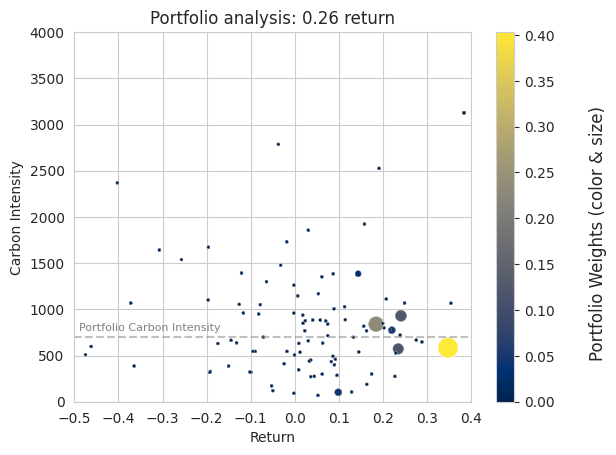

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a sample dataframe with the required columns
data = pd.DataFrame({
    'Volatility': df_q2_100_2015['assets_volatility'].values.tolist(),
    'Carbon Intensity': df_q2_100_2015['assets_Carbon_Intensity'].values.tolist(),
    'Portfolio Weights': df_q2_100_2015['0.26_weights'].values.tolist(),
    'Return': df_q2_100_2015['assets_AAR'].values.tolist(),
    'Sharpe Ratio': df_q2_100_2015['assets_SharpeRatio'].values.tolist(),
})

# Create a scatter plot
fig, ax = plt.subplots()

# Create a scatter plot with the required parameters
scatterplot = sns.scatterplot(
    x='Return',
    y='Carbon Intensity',
    hue='Portfolio Weights',
    size='Portfolio Weights',
    palette='cividis',
    sizes=(5, 200),
    data=data,
    ax=ax
)

# Set the title and axis labels
ax.set_title('Portfolio analysis: 0.26 return')
ax.set_xlabel('Return')
ax.set_ylabel('Carbon Intensity')
ax.get_legend().remove()
ax.set_ylim(0,4000)
ax.set_xlim(-0.5, 0.4)
# Add a colorbar to the plot
norm = plt.Normalize(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([]) # set an empty array to ensure that the scaling corresponds to the data
cbar = plt.colorbar(sm)
cbar.ax.set_title("""Portfolio Weights (color & size)""",rotation=90, loc='right', y=0.1, x= 6)
# Set the limits for the colorbar
cbar.ax.set_ylim(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())

# Add a dotted line at Portfolio Carbon Intensity
ax.axhline(y=df_q2_100_2015['0.26_WA_All_Scopes'].unique(), color='gray', linestyle='--', alpha=0.5)

# Add text to the dotted line
ax.annotate('Portfolio Carbon Intensity', xy=(0, df_q2_100_2015['0.26_WA_All_Scopes'].unique()), xytext=(-0.49, df_q2_100_2015['0.26_WA_All_Scopes'].unique()+100),
            color='gray', fontsize=8, ha='left', va='center')

# Save the plot as a PNG image
fig.savefig('Carbon_Return_0_26.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<ipython-input-229-e9811ad407e3>:41: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



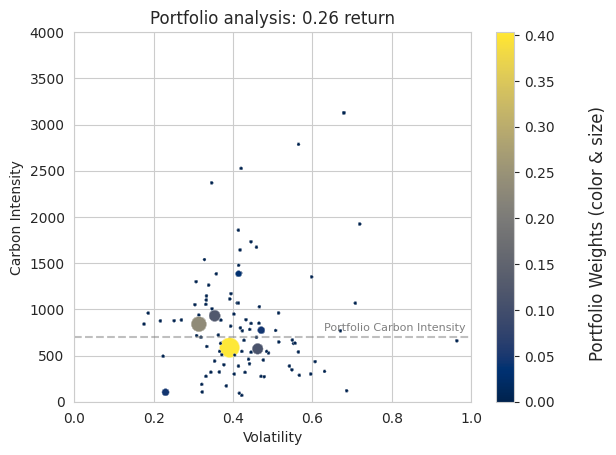

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a sample dataframe with the required columns
data = pd.DataFrame({
    'Volatility': df_q2_100_2015['assets_volatility'].values.tolist(),
    'Carbon Intensity': df_q2_100_2015['assets_Carbon_Intensity'].values.tolist(),
    'Portfolio Weights': df_q2_100_2015['0.26_weights'].values.tolist(),
    'Return': df_q2_100_2015['assets_AAR'].values.tolist(),
    'Sharpe Ratio': df_q2_100_2015['assets_SharpeRatio'].values.tolist(),
})

# Create a scatter plot
fig, ax = plt.subplots()

# Create a scatter plot with the required parameters
scatterplot = sns.scatterplot(
    x='Volatility',
    y='Carbon Intensity',
    hue='Portfolio Weights',
    size='Portfolio Weights',
    palette='cividis',
    sizes=(5, 200),
    data=data,
    ax=ax
)

# Set the title and axis labels
ax.set_title('Portfolio analysis: 0.26 return')
ax.set_xlabel('Volatility')
ax.set_ylabel('Carbon Intensity')
ax.get_legend().remove()
ax.set_ylim(0,4000)
ax.set_xlim(0, 1)
# Add a colorbar to the plot
norm = plt.Normalize(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([]) # set an empty array to ensure that the scaling corresponds to the data
cbar = plt.colorbar(sm)
cbar.ax.set_title("""Portfolio Weights (color & size)""",rotation=90, loc='right', y=0.1, x= 6)
# Set the limits for the colorbar
cbar.ax.set_ylim(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())


# Add a dotted line at Portfolio Carbon Intensity
ax.axhline(y=df_q2_100_2015['0.26_WA_All_Scopes'].unique(), color='gray', linestyle='--', alpha=0.5)

# Add text to the dotted line
ax.annotate('Portfolio Carbon Intensity', xy=(0, df_q2_100_2015['0.26_WA_All_Scopes'].unique()), xytext=(0.63, df_q2_100_2015['0.26_WA_All_Scopes'].unique()+100),
            color='gray', fontsize=8, ha='left', va='center')

# Save the plot as a PNG image
fig.savefig('Carbon_Volatility_0_26.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


Portfolio composition analysis : 0.16 return (Least carbon intensive created portfolio)

<ipython-input-230-3eeaa8112aa1>:41: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



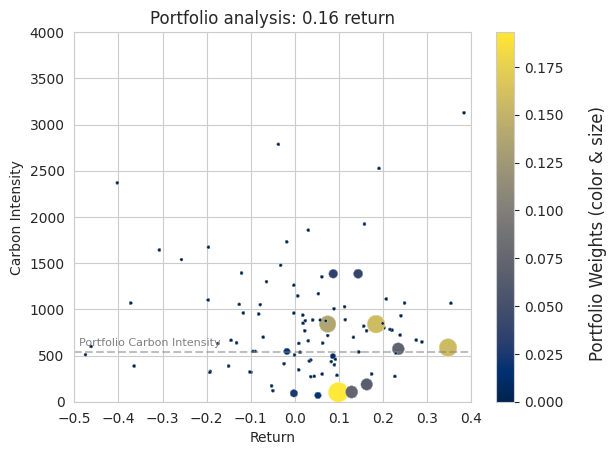

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a sample dataframe with the required columns
data = pd.DataFrame({
    'Volatility': df_q2_100_2015['assets_volatility'].values.tolist(),
    'Carbon Intensity': df_q2_100_2015['assets_Carbon_Intensity'].values.tolist(),
    'Portfolio Weights': df_q2_100_2015['0.16_weights'].values.tolist(),
    'Return': df_q2_100_2015['assets_AAR'].values.tolist(),
    'Sharpe Ratio': df_q2_100_2015['assets_SharpeRatio'].values.tolist(),
})

# Create a scatter plot
fig, ax = plt.subplots()

# Create a scatter plot with the required parameters
scatterplot = sns.scatterplot(
    x='Return',
    y='Carbon Intensity',
    hue='Portfolio Weights',
    size='Portfolio Weights',
    palette='cividis',
    sizes=(5, 200),
    data=data,
    ax=ax
)

# Set the title and axis labels
ax.set_title('Portfolio analysis: 0.16 return')
ax.set_xlabel('Return')
ax.set_ylabel('Carbon Intensity')
ax.get_legend().remove()
ax.set_ylim(0,4000)
ax.set_xlim(-0.5, 0.4)
# Add a colorbar to the plot
norm = plt.Normalize(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([]) # set an empty array to ensure that the scaling corresponds to the data
cbar = plt.colorbar(sm)
cbar.ax.set_title('Portfolio Weights (color & size)',rotation=90, loc='right', y=0.1, x= 6)
# Set the limits for the colorbar
cbar.ax.set_ylim(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())

# Add a dotted line at Portfolio Carbon Intensity
ax.axhline(y=df_q2_100_2015['0.16_WA_All_Scopes'].unique(), color='gray', linestyle='--', alpha=0.5)

# Add text to the dotted line
ax.annotate('Portfolio Carbon Intensity', xy=(0, df_q2_100_2015['0.16_WA_All_Scopes'].unique()), xytext=(-0.49, df_q2_100_2015['0.16_WA_All_Scopes'].unique()+100),
            color='gray', fontsize=8, ha='left', va='center')

# Save the plot as a PNG image
fig.savefig('Carbon_Return_0_16.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<ipython-input-231-c96501d37edb>:41: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



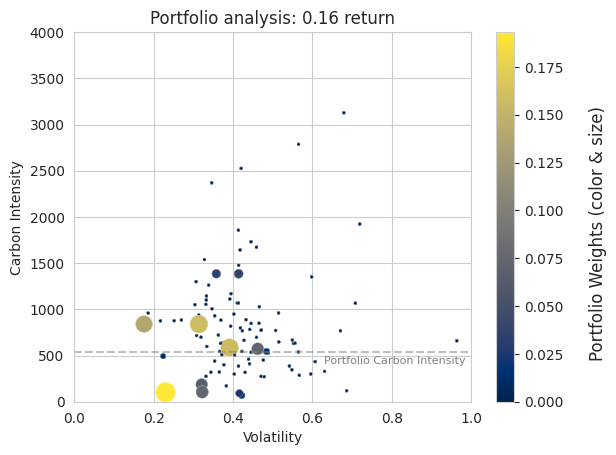

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a sample dataframe with the required columns
data = pd.DataFrame({
    'Volatility': df_q2_100_2015['assets_volatility'].values.tolist(),
    'Carbon Intensity': df_q2_100_2015['assets_Carbon_Intensity'].values.tolist(),
    'Portfolio Weights': df_q2_100_2015['0.16_weights'].values.tolist(),
    'Return': df_q2_100_2015['assets_AAR'].values.tolist(),
    'Sharpe Ratio': df_q2_100_2015['assets_SharpeRatio'].values.tolist(),
})

# Create a scatter plot
fig, ax = plt.subplots()

# Create a scatter plot with the required parameters
scatterplot = sns.scatterplot(
    x='Volatility',
    y='Carbon Intensity',
    hue='Portfolio Weights',
    size='Portfolio Weights',
    palette='cividis',
    sizes=(5, 200),
    data=data,
    ax=ax
)

# Set the title and axis labels
ax.set_title('Portfolio analysis: 0.16 return')
ax.set_xlabel('Volatility')
ax.set_ylabel('Carbon Intensity')
ax.get_legend().remove()
ax.set_ylim(0,4000)
ax.set_xlim(0, 1)
# Add a colorbar to the plot
norm = plt.Normalize(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([]) # set an empty array to ensure that the scaling corresponds to the data
cbar = plt.colorbar(sm)
cbar.ax.set_title('Portfolio Weights (color & size)',rotation=90, loc='right', y=0.1, x= 6)
# Set the limits for the colorbar
cbar.ax.set_ylim(data['Portfolio Weights'].min(), data['Portfolio Weights'].max())

# Add a dotted line at Portfolio Carbon Intensity
ax.axhline(y=df_q2_100_2015['0.16_WA_All_Scopes'].unique(), color='gray', linestyle='--', alpha=0.5)

# Add text to the dotted line
ax.annotate('Portfolio Carbon Intensity', xy=(0, df_q2_100_2015['0.16_WA_All_Scopes'].unique()), xytext=(0.63, df_q2_100_2015['0.16_WA_All_Scopes'].unique()-100),
            color='gray', fontsize=8, ha='left', va='center')

# Save the plot as a PNG image
fig.savefig('Carbon_Volatility_0_16.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Q3

This question is a follow-up of Question 7 of Homework 1. First, take the same 100 selected firms. Then, create a minimum variance portfolio with monthly rebalancing with an additional constraint: you exclude the worst firms in terms of E/S/G score/most polluting (high carbon intensity) firms. Specifically, exclude the bottom tercile of the distribution in month t − 1 for ESG scores or exclude the top tercile of the distribution in month t − 1 for the carbon intensity. Report summary statistics on the performance (return, risk, Sharpe ratio) of this portfolio as well as its E/S/G score or carbon intensity. How do the performance measures (return, risk, Sharpe ratio) compare with the minimum variance portfolio from Question 3 of Homework 1. (20 points)

#### Prepare dataframe with 100 random firms

In [ ]:
#This is the dataset of all companies (including some without return and some with no carbon intensity scores) for the whole period from 2005-2020.
df_nrg_intensity.describe()

year      month  monthly_return        market_cap  annual_returns  \
count 33300.0000 33300.0000      32774.0000        25507.0000      33300.0000   
mean   2012.0000     6.5000          0.0099  21701959723.0345          0.1171   
std       4.3206     3.4521          0.1265  48487532083.5228          0.4977   
min    2005.0000     1.0000         -0.8780      3296290.0000         -2.8376   
25%    2008.0000     3.7500         -0.0499   2647520000.0000         -0.1005   
50%    2012.0000     6.5000          0.0033   5969290000.0000          0.0909   
75%    2016.0000     9.2500          0.0664  17055450000.0000          0.3522   
max    2019.0000    12.0000          4.4057 730729000000.0000          4.6724   

         Scope_1    Scope_2    Scope_3  Scope_tot  
count 27288.0000 27288.0000 27288.0000 27288.0000  
mean    618.7268    65.5596   260.6448   944.9312  
std    1885.7669   132.4856   174.1596  1920.7942  
min       1.0438     0.0000    22.4748    41.7435  
25%     144.2150    15.5377   115.6922   423.1191  
50%     280.8592    36.1253   239.0797   622.6719  
75%     506.3478    56.6730   362.2962   900.1137  
max   43437.1433  2772.0906  1591.5053 43839.0627

In [ ]:
# list of carbon intense data randomly selected firms based on the criteria: 
# - no carbon score, no return -> company default (included)
# - no carbon score, but return -> excluded, (bad firms) due to non reporting of carbon intensity scores
HW2_q3_100_random = ['AN8068571086',
 'ARP9897X1319',
 'AU000000ERA9',
 'AU000000PDN8',
 'AU000000WHC8',
 'BMG2108M2182',
 'BMG5320C1082',
 'BMG7998G1069',
 'BRUGPAACNOR8',
 'CA00208D4084',
 'CA07317Q1054',
 'CA09784Y1088',
 'CA1363851017',
 'CA22576C1014',
 'CA2927661025',
 'CA4530384086',
 'CA7063271034',
 'CA8672241079',
 'CH0048265513',
 'CNE0000012G4',
 'CNE0000019T2',
 'CNE000001PQ8',
 'CNE1000002Q2',
 'CNE1000002R0',
 'CNE1000003W8',
 'CNE1000004D6',
 'CNE100000528',
 'COC04PA00016',
 'ES0173516115',
 'FI0009013296',
 'FR0013181864',
 'GB00B5N0P849',
 'GB00BJVJZD68',
 'HK0883013259',
 'HU0000153937',
 'ID1000094006',
 'INE029A01011',
 'INE094A01015',
 'INE176B01034',
 'INE196A01026',
 'INE213A01029',
 'INE242A01010',
 'INE347G01014',
 'IT0000433307',
 'IT0003132476',
 'IT0005252140',
 'JP3142500002',
 'JP3294460005',
 'KR7010950004',
 'LU0075646355',
 'LU0156801721',
 'MYL4324OO009',
 'MYL5681OO001',
 'MYL7164OO006',
 'NO0003921009',
 'NO0005052605',
 'NO0010096985',
 'PHY6885F1067',
 'PK0022501016',
 'PK0080201012',
 'PK0081801018',
 'PLLOTOS00025',
 'QA000A0KD6L1',
 'RU0007661625',
 'RU0009024277',
 'RU0009033591',
 'RU0009062467',
 'RU0009091573',
 'RU000A0B6NK6',
 'RU000A0B90N8',
 'SE0000825820',
 'SE0000862997',
 'TH0355A10Z04',
 'TH0471010Y04',
 'TH0796010005',
 'TRATUPRS91E8',
 'US03957W1062',
 'US12653C1080',
 'US1270971039',
 'US16411R2085',
 'US1667641005',
 'US20605P1012',
 'US20825C1045',
 'US2120151012',
 'US25179M1036',
 'US26875P1012',
 'US30231G1022',
 'US4234521015',
 'US42809H1077',
 'US4361061082',
 'US6267171022',
 'US6745991058',
 'US6752321025',
 'US69047Q1022',
 'US7034811015',
 'US7237871071',
 'US75281A1097',
 'US8454671095',
 'US9026531049',
 'US91913Y1001']

display(len(HW2_q3_100_random))

#create dataframe with the 100 random selected firms based on the data of all firms
df_hw2_q3_100 = df_nrg_intensity[df_nrg_intensity.ISIN.isin(HW2_q3_100_random) == True]
print(df_hw2_q3_100)

100

             date  year  month          ISIN  monthly_return      market_cap  \
0      2005-01-31  2005      1  AN8068571086          0.0126             NaN   
1      2005-02-28  2005      2  AN8068571086          0.0635             NaN   
2      2005-03-31  2005      3  AN8068571086          0.0930             NaN   
3      2005-04-30  2005      4  AN8068571086         -0.0384             NaN   
4      2005-05-31  2005      5  AN8068571086         -0.0271             NaN   
...           ...   ...    ...           ...             ...             ...   
35311  2019-08-31  2019      8  ARP9897X1319         -0.1188 3659590000.0000   
35312  2019-09-30  2019      9  ARP9897X1319         -0.3844 4045620000.0000   
35313  2019-10-31  2019     10  ARP9897X1319          0.0758 4978820000.0000   
35314  2019-11-30  2019     11  ARP9897X1319          0.1897 4737710000.0000   
35315  2019-12-31  2019     12  ARP9897X1319         -0.0765 5636240000.0000   

       annual_returns   Scope_1  Scope_

In [ ]:
#sort dataframe based on date, then ISIN
df_hw2_q3_100 = df_hw2_q3_100.sort_values(by=["date","ISIN"],inplace = False)

#check the number of firms (should be 100 distinct ISIN's )
display(len(df_hw2_q3_100["ISIN"].unique()))
display(df_hw2_q3_100)

100

date  year  month          ISIN  monthly_return       market_cap  \
0      2005-01-31  2005      1  AN8068571086          0.0126              NaN   
35136  2005-01-31  2005      1  ARP9897X1319          0.0287              NaN   
384    2005-01-31  2005      1  AU000000ERA9          0.0324              NaN   
768    2005-01-31  2005      1  AU000000PDN8         -0.0589              NaN   
960    2005-01-31  2005      1  AU000000WHC8             NaN              NaN   
...           ...   ...    ...           ...             ...              ...   
32627  2019-12-31  2019     12  US7237871071         -0.0061 25073900000.0000   
33203  2019-12-31  2019     12  US75281A1097         -0.2094  1219420000.0000   
33779  2019-12-31  2019     12  US8454671095         -0.1374  1309940000.0000   
34547  2019-12-31  2019     12  US9026531049         -0.0593 13757300000.0000   
34739  2019-12-31  2019     12  US91913Y1001         -0.0338 38457600000.0000   

       annual_returns  Scope_1  Scope_2  Scope_3  Scope_tot  
0              0.4680 135.8217  15.1758 291.2881   442.2856  
35136          0.3843      NaN      NaN      NaN        NaN  
384            0.9657 534.1543 323.5086 182.2743  1039.9372  
768            1.7959      NaN      NaN      NaN        NaN  
960            0.0000      NaN      NaN      NaN        NaN  
...               ...      ...      ...      ...        ...  
32627         -0.1456 464.8462  66.1281  99.1090   630.0833  
33203         -1.2013 417.3997  49.9731  99.0655   566.4383  
33779         -0.6910 246.1290  16.5231 180.0325   442.6845  
34547          0.1307  12.8810  57.1847  30.4164   100.4821  
34739          0.2787 186.4196  31.2452 440.2454   657.9102  

[18000 rows x 11 columns]

In [ ]:
#Monthly rebalancing of the 100 selected firms
#create return dataframe from 2005 from the previous dataframe
df_hw2_q3_100_returns = df_hw2_q3_100.pivot(index= "date",columns="ISIN", values="monthly_return")
df_hw2_q3_100_returns.columns.name = None
display(df_hw2_q3_100_returns)
display(df_hw2_q3_100_returns.count())

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
date                                                                 
2005-01-31        0.0126        0.0287        0.0324       -0.0589   
2005-02-28        0.0635        0.0947        0.5098        0.8182   
2005-03-31        0.0930        0.2582        0.1888        0.3734   
2005-04-30       -0.0384       -0.1032       -0.1304       -0.1144   
2005-05-31       -0.0271       -0.0116       -0.0490       -0.0061   
...                  ...           ...           ...           ...   
2019-08-31       -0.0206       -0.1188        0.1057        0.2192   
2019-09-30       -0.1579       -0.3844       -0.0601       -0.1447   
2019-10-31        0.0242        0.0758       -0.0291       -0.2630   
2019-11-30        0.0532        0.1897        0.1557       -0.1117   
2019-12-31        0.0557       -0.0765       -0.1062       -0.0031   

            AU000000WHC8  BMG2108M2182  BMG5320C1082  BMG7998G1069  \
date                                                                 
2005-01-31           NaN       -0.0005       -0.0165           NaN   
2005-02-28           NaN       -0.0122       -0.0683           NaN   
2005-03-31           NaN        0.1635        0.1229           NaN   
2005-04-30           NaN        0.1405        0.0000           NaN   
2005-05-31           NaN        0.0004       -0.0621           NaN   
...                  ...           ...           ...           ...   
2019-08-31        0.0009        0.0024        0.0304       -0.2308   
2019-09-30       -0.0886       -0.2765       -0.0416       -0.3667   
2019-10-31       -0.0719        0.0897       -0.0000       -0.1579   
2019-11-30        0.0774        0.0078        0.1074       -0.0625   
2019-12-31       -0.0410        0.0987       -0.1196       -0.4000   

            BRUGPAACNOR8  CA00208D4084  ...  US6267171022  US6745991058  \
date                                    ...                               
2005-01-31        0.0180        0.0402  ...       -0.0732       -0.0341   
2005-02-28        0.0228        0.0683  ...        0.1837        0.0504   
2005-03-31        0.0392       -0.0213  ...        0.0762        0.1668   
2005-04-30       -0.0186        0.0100  ...        0.0415        0.0670   
2005-05-31        0.0542       -0.0948  ...       -0.1028       -0.0494   
...                  ...           ...  ...           ...           ...   
2019-08-31        0.0039        0.0825  ...       -0.0714        0.0681   
2019-09-30       -0.2225       -0.1898  ...       -0.2025       -0.1822   
2019-10-31        0.1562        0.0881  ...        0.1893        0.0244   
2019-11-30        0.0572       -0.0151  ...        0.0152       -0.0338   
2019-12-31        0.0737        0.1095  ...        0.0768       -0.0854   

            US6752321025  US69047Q1022  US7034811015  US7237871071  \
date                                                                 
2005-01-31       -0.0247       -0.0327       -0.0438       -0.0138   
2005-02-28        0.0763        0.1114        0.0741        0.1382   
2005-03-31        0.0018        0.1047        0.2342        0.0808   
2005-04-30       -0.0124        0.0842        0.0621        0.0534   
2005-05-31       -0.1151       -0.0716       -0.0283       -0.0753   
...                  ...           ...           ...           ...   
2019-08-31       -0.2541       -0.1284       -0.1176       -0.1568   
2019-09-30       -0.1377       -0.0090       -0.1707       -0.0325   
2019-10-31        0.0093        0.0063       -0.0289       -0.0103   
2019-11-30        0.1200       -0.0651        0.0682        0.0479   
2019-12-31       -0.0744       -0.0673        0.0246       -0.0061   

            US75281A1097  US8454671095  US9026531049  US91913Y1001  
date                                                                
2005-01-31       -0.0483       -0.1061        0.0478       -0.0354  
2005-02-28        0.1712        0.1501       -0.0691        0.3228  
2005-03-31        0.0729   

AN8068571086    180
ARP9897X1319    180
AU000000ERA9    180
AU000000PDN8    180
AU000000WHC8    150
               ... 
US7237871071    180
US75281A1097    180
US8454671095    180
US9026531049    180
US91913Y1001    180
Length: 100, dtype: int64

In [ ]:
#check if firm are the same in portfolio and return df
a = df_hw2_q3_100_returns.columns.tolist()
b = df_hw2_q3_100["ISIN"].unique().tolist()
a == b

True

In [ ]:
#select return dataframe within wanted time frame 2015 - 2019
df_hw2_q3_100_returns_2015 = df_hw2_q3_100_returns.loc["2015-01-31":"2019-12-31"]
df_hw2_q3_100_returns_2015

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
date                                                                 
2015-01-31        0.0067       -0.1649       -0.0055        0.1014   
2015-02-28       -0.0090       -0.1005       -0.0447       -0.0180   
2015-03-31        0.0056        0.0450        0.0261        0.0356   
2015-04-30       -0.0040        0.0954       -0.0868       -0.0464   
2015-05-31        0.1035        0.0564        0.1228       -0.0265   
2015-06-30       -0.0199       -0.1107       -0.0531       -0.1376   
2015-07-31       -0.0700        0.0870       -0.6970       -0.1530   
2015-08-31       -0.0263       -0.1571       -0.1221       -0.3017   
2015-09-30       -0.0752       -0.0412       -0.0859       -0.0578   
2015-10-31       -0.1030       -0.3026       -0.0701       -0.0770   
2015-11-30        0.1741        0.4052        0.0460        0.3898   
2015-12-31       -0.0095       -0.1251        0.0527       -0.0415   
2016-01-31       -0.1077       -0.3708        0.0384        0.0623   
2016-02-29        0.0245       -0.0211       -0.0659       -0.1275   
2016-03-31        0.0430        0.0772       -0.0344       -0.1315   
2016-04-30       -0.0255       -0.0021        0.1480        0.3280   
2016-05-31        0.1009        0.1080       -0.0295        0.1284   
2016-06-30       -0.0384        0.0583       -0.0352       -0.2142   
2016-07-31        0.0482       -0.0658        0.0315       -0.0876   
2016-08-31       -0.0133       -0.0671        0.0096       -0.0165   
2016-09-30        0.0064       -0.0508       -0.0287       -0.1092   
2016-10-31        0.0056        0.0714        0.0000       -0.0773   
2016-11-30       -0.0025       -0.0582        0.0148       -0.1334   
2016-12-31        0.0751       -0.0424       -0.0630       -0.5168   
2017-01-31       -0.0019        0.0373        0.2897        0.2940   
2017-02-28       -0.0093        0.2507        0.6818        0.5181   
2017-03-31       -0.0048       -0.0100       -0.1113       -0.1096   
2017-04-30       -0.0555        0.1649        0.0742       -0.0520   
2017-05-31       -0.0695        0.0501       -0.1357       -0.0087   
2017-06-30       -0.0278       -0.0343       -0.1214       -0.5331   
2017-07-31       -0.0403       -0.1083       -0.0636       -0.0269   
2017-08-31        0.0305       -0.1038        0.1885        0.0445   
2017-09-30       -0.0748        0.0049        0.0552       -0.0015   
2017-10-31        0.0942        0.1548       -0.0187       -0.0186   
2017-11-30       -0.0727        0.0534       -0.0285       -0.0195   
2017-12-31        0.0070       -0.0605        0.4760       -0.0102   
2018-01-31        0.0493       -0.0157        0.1221        0.0299   
2018-02-28        0.1205        0.0803       -0.0414        0.0260   
2018-03-31       -0.1302       -0.0623       -0.2560        2.4915   
2018-04-30       -0.0267       -0.0625       -0.2604       -0.0105   
2018-05-31        0.0775        0.0359        0.0460       -0.2252   
2018-06-30        0.0082       -0.1783       -0.0375        0.1232   
2018-07-31       -0.0475       -0.2880       -0.2339        0.1306   
2018-08-31        0.0222        0.2319        0.0233        0.1550   
2018-09-30       -0.0525       -0.1033       -0.0625       -0.0983   
2018-10-31       -0.0170        0.0339        0.0273        0.0542   
2018-11-30       -0.1612        0.0693       -0.1313       -0.0810   
2018-12-31       -0.1038       -0.0155       -0.1392        0.1089   
2019-01-31       -0.2119       -0.1422       -0.1913       -0.1168   
2019-02-28        0.2350        0.2402        0.1146        0.0023   
2019-03-31        0.0256       -0.1564        0.1794       -0.0784   
2019-04-30       -0.0095        0.0325       -0.1373       -0.1177   
2019-05-31       -0.0757       -0.0569       -0.1376       -0.0799   
2019-06-30       -0.1421        0.1054       -0.1546       -0.1582   
2019-07-31        0.1234        0.2385       -0.0236        0.0887   
2019-08-31       -0.02

In [ ]:
#check how many NaN's we get 
df_hw2_q3_100['monthly_return'].isna().sum().sum()

298

#### Create minimum variance portfolio

In [ ]:

#Goal is to cut the covariance matrix over 10 years (years*months =120)as well as skip Nan's and select 2015-2019 time frame
min_periods = len(df_hw2_q3_100_returns.columns)-15+1
Covar_matrix_2015 = df_hw2_q3_100_returns.rolling(window= 120, min_periods= min_periods).cov()
Covar_matrix_2015 = Covar_matrix_2015.loc["2015-01-31":"2019-12-31"]
display(Covar_matrix_2015)

#check how many Nan's I am getting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display the entire DataFrame
covar_nan = Covar_matrix_2015.isna().sum()
display(covar_nan)

# reset max_rows and max_columns to their default values
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


AN8068571086  ARP9897X1319  AU000000ERA9  \
date                                                                
2015-01-31 AN8068571086        0.0099        0.0030        0.0070   
           ARP9897X1319        0.0030        0.0149        0.0038   
           AU000000ERA9        0.0070        0.0038        0.0254   
           AU000000PDN8        0.0105        0.0064        0.0227   
           AU000000WHC8        0.0099        0.0064        0.0177   
...                               ...           ...           ...   
2019-12-31 US7237871071        0.0061        0.0031        0.0043   
           US75281A1097        0.0050        0.0031        0.0040   
           US8454671095        0.0049        0.0032        0.0031   
           US9026531049        0.0014       -0.0002        0.0017   
           US91913Y1001        0.0052        0.0041        0.0037   

                         AU000000PDN8  AU000000WHC8  BMG2108M2182  \
date                                                                
2015-01-31 AN8068571086        0.0105        0.0099        0.0038   
           ARP9897X1319        0.0064        0.0064        0.0030   
           AU000000ERA9        0.0227        0.0177        0.0057   
           AU000000PDN8        0.0431        0.0241        0.0075   
           AU000000WHC8        0.0241        0.0416        0.0101   
...                               ...           ...           ...   
2019-12-31 US7237871071        0.0028        0.0050        0.0015   
           US75281A1097        0.0039        0.0027       -0.0002   
           US8454671095        0.0001        0.0025        0.0005   
           US9026531049        0.0012        0.0014        0.0001   
           US91913Y1001        0.0041        0.0022        0.0020   

                         BMG5320C1082  BMG7998G1069  BRUGPAACNOR8  \
date                                                                
2015-01-31 AN8068571086        0.0058        0.0107        0.0021   
           ARP9897X1319        0.0035        0.0040        0.0003   
           AU000000ERA9        0.0075        0.0118        0.0006   
           AU000000PDN8        0.0110        0.0161        0.0006   
           AU000000WHC8        0.0112        0.0203        0.0042   
...                               ...           ...           ...   
2019-12-31 US7237871071        0.0030        0.0096       -0.0002   
           US75281A1097        0.0024        0.0128        0.0023   
           US8454671095        0.0020        0.0116        0.0014   
           US9026531049        0.0011        0.0012        0.0008   
           US91913Y1001        0.0028        0.0071        0.0003   

                         CA00208D4084  ...  US6267171022  US6745991058  \
date                                   ...                               
2015-01-31 AN8068571086        0.0055  ...        0.0068        0.0061   
           ARP9897X1319        0.0032  ...        0.0030        0.0033   
           AU000000ERA9        0.0059  ...        0.0077        0.0066   
           AU000000PDN8        0.0088  ...        0.0100        0.0097   
           AU000000WHC8        0.0107  ...        0.0123        0.0126   
...                               ...  ...           ...           ...   
2019-12-31 US7237871071        0.0038  ...        0.0070        0.0051   
           US75281A1097        0.0056  ...        0.0080        0.0043   
           US8454671095        0.0066  ...        0.0102        0.0043   
           US9026531049        0.0008  ...        0.0014        0.0015   
           US91913Y1001        0.0031  ...        0.0045        0.0045   

                         US6752321025  US69047Q1022  US7034811015  \
date                                                                
2015-01-31 AN8068571086        0.0087        0.0054        0.0090   
           ARP9897X1319        0.0031        0.0036        0.0049   
           AU000000ERA9        0.0083        0.0080        0.0079   
           AU000000PDN8

AN8068571086    0
ARP9897X1319    0
AU000000ERA9    0
AU000000PDN8    0
AU000000WHC8    0
BMG2108M2182    0
BMG5320C1082    0
BMG7998G1069    0
BRUGPAACNOR8    0
CA00208D4084    0
CA07317Q1054    0
CA09784Y1088    0
CA1363851017    0
CA22576C1014    0
CA2927661025    0
CA4530384086    0
CA7063271034    0
CA8672241079    0
CH0048265513    0
CNE0000012G4    0
CNE0000019T2    0
CNE000001PQ8    0
CNE1000002Q2    0
CNE1000002R0    0
CNE1000003W8    0
CNE1000004D6    0
CNE100000528    0
COC04PA00016    0
ES0173516115    0
FI0009013296    0
FR0013181864    0
GB00B5N0P849    0
GB00BJVJZD68    0
HK0883013259    0
HU0000153937    0
ID1000094006    0
INE029A01011    0
INE094A01015    0
INE176B01034    0
INE196A01026    0
INE213A01029    0
INE242A01010    0
INE347G01014    0
IT0000433307    0
IT0003132476    0
IT0005252140    0
JP3142500002    0
JP3294460005    0
KR7010950004    0
LU0075646355    0
LU0156801721    0
MYL4324OO009    0
MYL5681OO001    0
MYL7164OO006    0
NO0003921009    0
NO00050526

In [ ]:
#check how many Nan's the Covariance matrix has
Covar_matrix_2015.isna().sum().sum()

0

6000 rows since I have for each company 5 years. In total there are 100 companies. Next up, will create a list with the selected time frame. Each month from 2015-2019.

In [ ]:
#Sort dates in chronological order and check how many Nan's we have in the returns dataframe for each date
dates = sorted(list(set(Covar_matrix_2015.index.get_level_values('date').tolist())))
date_returns_2005 = sorted(list(set(df_hw2_q3_100_returns.index.get_level_values('date').tolist())))
for date in date_returns_2005:
    print (date)
    print(df_hw2_q3_100_returns.loc[date].isna().sum().sum())

2005-01-31
15
2005-02-28
15
2005-03-31
15
2005-04-30
15
2005-05-31
14
2005-06-30
14
2005-07-31
12
2005-08-31
12
2005-09-30
11
2005-10-31
11
2005-11-30
10
2005-12-31
10
2006-01-31
10
2006-02-28
10
2006-03-31
10
2006-04-30
10
2006-05-31
10
2006-06-30
9
2006-07-31
9
2006-08-31
9
2006-09-30
9
2006-10-31
9
2006-11-30
8
2006-12-31
7
2007-01-31
5
2007-02-28
5
2007-03-31
5
2007-04-30
5
2007-05-31
4
2007-06-30
3
2007-07-31
2
2007-08-31
2
2007-09-30
1
2007-10-31
1
2007-11-30
1
2007-12-31
0
2008-01-31
0
2008-02-29
0
2008-03-31
0
2008-04-30
0
2008-05-31
0
2008-06-30
0
2008-07-31
0
2008-08-31
0
2008-09-30
0
2008-10-31
0
2008-11-30
0
2008-12-31
0
2009-01-31
0
2009-02-28
0
2009-03-31
0
2009-04-30
0
2009-05-31
0
2009-06-30
0
2009-07-31
0
2009-08-31
0
2009-09-30
0
2009-10-31
0
2009-11-30
0
2009-12-31
0
2010-01-31
0
2010-02-28
0
2010-03-31
0
2010-04-30
0
2010-05-31
0
2010-06-30
0
2010-07-31
0
2010-08-31
0
2010-09-30
0
2010-10-31
0
2010-11-30
0
2010-12-31
0
2011-01-31
0
2011-02-28
0
2011-03-31
0
2011-04-

Create function that calculates the optimal min_var_weights.

In [ ]:
def get_min_var_weights (covariance_matrix, df_results,dates):

    # Optimal min var weights
    min_var_weights = []  # Empty list

    # variances
    variances = []

    for date in dates:

        # Define objective func
        def objective(weights, covariance_matrix):
            return weights.T @ covariance_matrix @ weights

            # Define constraint func
        def constraint1(weights):
            return np.sum(weights) - 1

        # Define vars
        cov_mat = covariance_matrix.loc[date]
        #inv_cov = np.linalg.inv(cov_mat)
        returns = df_results.loc[date]

        constraints = [{'type': 'eq', 'fun': constraint1}]

        bounds = tuple((0, 1) for x in range(len(returns)))

        weights = np.ones(len(returns)) / len(returns)

        result = minimize(objective, weights, args=cov_mat,
                          constraints=constraints, bounds=bounds)

        month_weights = result.x / np.sum(result.x)
        month_weights = list(month_weights)
        min_var_weights.append(month_weights)

     # Calculate variance
        #Store the min variances
        min_var = result.fun
        variances.append(min_var)

        #portfolio_variance = np.dot(
       # month_weights, np.dot(cov_mat, month_weights))
       # variances.append(portfolio_variance)

    portfolio_variance = sum(variances)/5
    portfolio_volatility =  np.sqrt(portfolio_variance)

    return min_var_weights, portfolio_volatility

In [ ]:
#call function
min_var_weight, portfolio_volatility = get_min_var_weights(Covar_matrix_2015,df_hw2_q3_100_returns_2015,dates)

In [ ]:
volatility = portfolio_volatility
volatility

0.12057957857247857

In [ ]:
#create dataframe out of min_var_weights
df_min_var_weight = pd.DataFrame()

for i in range(len(min_var_weight)):

    month_weights = pd.Series(min_var_weight[i])
    df_min_var_weight = pd.concat(
        [df_min_var_weight, month_weights], ignore_index=True)

df_min_var_weight.columns.values[0] = "min_var_weight"
display(df_min_var_weight)
display(df_min_var_weight.isna().sum().sum)

min_var_weight
0       1.417489e-18
1       3.851186e-18
2       0.000000e+00
3       4.518671e-18
4       1.080874e-17
...              ...
5995    0.000000e+00
5996    0.000000e+00
5997    0.000000e+00
5998    1.566084e-01
5999    6.733722e-19

[6000 rows x 1 columns]

<bound method NDFrame._add_numeric_operations.<locals>.sum of min_var_weight    0
dtype: int64>

In [ ]:
#select only the years from 2015-01-31 to 2019-12-31 in my dataframe and reset index
start_date = '2015-01-31'
end_date = '2019-12-31'
df_hw2_q3_sorted_2015 = df_hw2_q3_100[(df_hw2_q3_100['date'] >= start_date) & (df_hw2_q3_100['date'] <= end_date)].copy()
df_hw2_q3_sorted_2015 = df_hw2_q3_sorted_2015.reset_index(drop=True)
display(df_hw2_q3_sorted_2015)

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3   Scope_tot  
0          -0.027115   39.621130   16.349542  236.880165  292.850836  
1          -0.313132  171.209549   34.474243  331.997971  537.681763  
2          -0.917602  176.623706  277.811755  121.399551  575.835012  
3          -0.332542  411.939919  325.313283  121.642129  858.895331  
4          -0.216742  712.307821   20.084699  220.339036  952.731556  
...              ...         ...         ...         ...         ...  
5995       -0.145554  464.846231   66.128086   99.109000  630.083317  
5996       -1.201267  417.399669   49.973138   99.065497  566.438304  
5997       -0.690964  246.128964   16.523077  180.032481  442.684522  
5998        0.130654   12.880980   57.184705   30.416402  100.482087  
5999        0.278711  186.419589   31.245203  440.245380  657.910172  

[6000 rows x 11 columns]

In [ ]:
#add the weights to the previous selected dataframe from 2015-2019
df_hw2_q3_sorted_2015['mv_weights'] = df_min_var_weight["min_var_weight"]
display(df_hw2_q3_sorted_2015)
display(df_hw2_q3_sorted_2015.describe())

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3   Scope_tot  \
0          -0.027115   39.621130   16.349542  236.880165  292.850836   
1          -0.313132  171.209549   34.474243  331.997971  537.681763   
2          -0.917602  176.623706  277.811755  121.399551  575.835012   
3          -0.332542  411.939919  325.313283  121.642129  858.895331   
4          -0.216742  712.307821   20.084699  220.339036  952.731556   
...              ...         ...         ...         ...         ...   
5995       -0.145554  464.846231   66.128086   99.109000  630.083317   
5996       -1.201267  417.399669   49.973138   99.065497  566.438304   
5997       -0.690964  246.128964   16.523077  180.032481  442.684522   
5998        0.130654   12.880980   57.184705   30.416402  100.482087   
5999        0.278711  186.419589   31.245203  440.245380  657.910172   

        mv_weights  
0     1.417489e-18  
1     3.851186e-18  
2     0.000000e+00  
3     4.518671e-18  
4     1.080874e-17  
...            ...  
5995  0.000000e+00  
5996  0.000000e+00  
5997  0.000000e+00  
5998  1.566084e-01  
5999  6.733722e-19  

[6000 rows x 12 columns]

year       month  monthly_return    market_cap  annual_returns  \
count  6000.000000  6000.00000     6000.000000  5.952000e+03     6000.000000   
mean   2017.000000     6.50000        0.001234  2.220350e+10        0.014805   
std       1.414331     3.45234        0.120776  4.734615e+10        0.419270   
min    2015.000000     1.00000       -0.773207  4.302850e+07       -2.012119   
25%    2016.000000     3.75000       -0.062935  3.040935e+09       -0.183816   
50%    2017.000000     6.50000       -0.001232  6.400745e+09        0.015437   
75%    2018.000000     9.25000        0.058576  1.862730e+10        0.262188   
max    2019.000000    12.00000        2.491476  3.887070e+11        2.704316   

            Scope_1      Scope_2      Scope_3     Scope_tot    mv_weights  
count   6000.000000  6000.000000  6000.000000   6000.000000  6.000000e+03  
mean     578.809895    71.272236   270.822814    920.904945  1.000000e-02  
std     1022.815276   154.622221   187.159488   1073.494480  3.676611e-02  
min        1.386262     0.011872    29.677929     65.090798  0.000000e+00  
25%      131.104870    14.120295   112.229363    437.774000  0.000000e+00  
50%      352.794454    35.299035   243.612648    711.739305  7.197580e-19  
75%      636.110834    61.099090   370.151333   1067.502510  4.061328e-18  
max    11563.308594  2772.090643  1173.624960  12127.275838  3.289667e-01

Now where we have the weights, we can compute the monthly weighted returns and volatility

In [ ]:
# Computing the monthly returns for each ISIN based on the market cap weight per month
def metric_computation(dataframe_2015,years,volatility):
    yrs = years
    dataframe_2015['mv_assets_monthly_weighted_returns'] = dataframe_2015['monthly_return'] * \
        dataframe_2015['mv_weights']

    # Computing the AAR of the minvar-weighted portfolio by summing all the monthly weighted returns across the portfolio and dividing by the years of data
    dataframe_2015['mv_AAR'] = (
        dataframe_2015['mv_assets_monthly_weighted_returns'].sum())/yrs

    # Computing the annual return of the value-weighted portfolio
    annual_return_df = dataframe_2015[[
        'year', 'mv_assets_monthly_weighted_returns']].groupby('year').sum()

    #Compute the weightes carbon Intensity scope
    dataframe_2015['mv_carbon_intensity'] = dataframe_2015['mv_weights'] * dataframe_2015['Scope_tot']

    def annual_return_func(row):
        year = row['year']
        return annual_return_df.loc[(year)][0]


    dataframe_2015['mv_annual_return'] = dataframe_2015.apply(
        annual_return_func, axis=1)

    # Computing the monthly return of the value-weighted portfolio
    monthly_returns_df = dataframe_2015[[
        'year', 'month', 'mv_assets_monthly_weighted_returns']].groupby(['year', 'month']).sum()


    def monthly_returns_func(row):
        year = row['year']
        month = row['month']
        return monthly_returns_df.loc[(year, month)][0]


    dataframe_2015['mv_monthly_returns'] = dataframe_2015.apply(
        monthly_returns_func, axis=1)

    # Computing portfolio volatility
    dataframe_2015['mv_volatility'] = volatility

    return dataframe_2015

In [ ]:
df_hw2_q3_sorted_2015_final = metric_computation(df_hw2_q3_sorted_2015,5,volatility)
display(df_hw2_q3_sorted_2015_final.count())
display(df_hw2_q3_sorted_2015_final)

date                                  6000
year                                  6000
month                                 6000
ISIN                                  6000
monthly_return                        6000
market_cap                            5952
annual_returns                        6000
Scope_1                               6000
Scope_2                               6000
Scope_3                               6000
Scope_tot                             6000
mv_weights                            6000
mv_assets_monthly_weighted_returns    6000
mv_AAR                                6000
mv_carbon_intensity                   6000
mv_annual_return                      6000
mv_monthly_returns                    6000
mv_volatility                         6000
dtype: int64

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3   Scope_tot  \
0          -0.027115   39.621130   16.349542  236.880165  292.850836   
1          -0.313132  171.209549   34.474243  331.997971  537.681763   
2          -0.917602  176.623706  277.811755  121.399551  575.835012   
3          -0.332542  411.939919  325.313283  121.642129  858.895331   
4          -0.216742  712.307821   20.084699  220.339036  952.731556   
...              ...         ...         ...         ...         ...   
5995       -0.145554  464.846231   66.128086   99.109000  630.083317   
5996       -1.201267  417.399669   49.973138   99.065497  566.438304   
5997       -0.690964  246.128964   16.523077  180.032481  442.684522   
5998        0.130654   12.880980   57.184705   30.416402  100.482087   
5999        0.278711  186.419589   31.245203  440.245380  657.910172   

        mv_weights  mv_assets_monthly_weighted_returns    mv_AAR  \
0     1.417489e-18                        9.524475e-21  0.048385   
1     3.851186e-18                       -6.349530e-19  0.048385   
2     0.000000e+00                       -0.000000e+00  0.048385   
3     4.518671e-18                        4.581055e-19  0.048385   
4     1.080874e-17                        2.039587e-18  0.048385   
...            ...                                 ...       ...   
5995  0.000000e+00                       -0.000000e+00  0.048385   
5996  0.000000e+00                       -0.000000e+00  0.048385   
5997  0.000000e+00                       -0.000000e+00  0.048385   
5998  1.566084e-01                       -9.289703e-03  0.048385   
5999  6.733722e-19                       -2.277977e-20  0.048385   

      mv_carbon_intensity  mv_annual_return  mv_monthly_returns  mv_volatility  
0            4.151129e-16         -0.012319           -0.015541        0.12058  
1            2.070712e-15         -0.012319           -0.015541        0.12058  
2            0.000000e+00         -0.012319           -0.015541        0.12058  
3            3.881065e-15         -0.012319           -0.015541        0.12058  
4            1.029782e-14         -0.012319           -0.015541        0.12058  
...                   ...               ...                 ...            ...  
5995         0.000000e+00          0.046683           -0.012793        0.12058  
5996         0.000000e+00          0.046683           -0.012793        0.12058  
5997         0.000000e+00          0.046683           -0.012793        0.12058  
5998         1.573634e+01          0.046683           -0.012793        0.12058  
5999         4.430184e-16          0.046683           -0.012793        0.12058  

[6000 rows x 18 columns]

In [ ]:
# now we compute the required metrics including return, volatility, sharperatio,..
yrs=5
risk_free_rate=0.035 # as definded above
mv_AAR = (df_hw2_q3_sorted_2015_final['mv_assets_monthly_weighted_returns'].sum())/yrs
mv_volatility = volatility
mv_sharperatio = (df_hw2_q3_sorted_2015_final['mv_AAR'].mean() - risk_free_rate)/df_hw2_q3_sorted_2015_final['mv_volatility'].mean()
mv_min = df_hw2_q3_sorted_2015_final['mv_annual_return'].min()
mv_max = df_hw2_q3_sorted_2015_final['mv_annual_return'].max()
mv_carbon_intensity = df_hw2_q3_sorted_2015_final['mv_carbon_intensity'].sum()/5/12

print(f'AAR: {round(mv_AAR*100, 3)}%')
print(f'Annualized volatility: {round(mv_volatility*100, 3)}%')
print(f'Max yearly return: {round(mv_max*100, 3)}%')
print(f'Min yearly return: {round(mv_min*100, 3)}%')
print(f'Sharpe ratio: {round(mv_sharperatio, 3)}')
print(f'Annualized Carbon Intensity: {round(mv_carbon_intensity, 3)}')

AAR: 4.838%
Annualized volatility: 12.058%
Max yearly return: 21.199%
Min yearly return: -1.774%
Sharpe ratio: 0.111
Annualized Carbon Intensity: 648.177


#### Low carbon intensity min_var portfolio

Now, we exclude the top 1/3rd percentile of firms that have the highest carbon intensity for each month

In [ ]:
#use same return dataframe as in min_var_portfolio
df_hw2_q3_100_returns

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
date                                                                 
2005-01-31      0.012603      0.028704      0.032408     -0.058855   
2005-02-28      0.063502      0.094693      0.509758      0.818187   
2005-03-31      0.093039      0.258207      0.188845      0.373450   
2005-04-30     -0.038401     -0.103228     -0.130408     -0.114356   
2005-05-31     -0.027085     -0.011597     -0.048968     -0.006077   
...                  ...           ...           ...           ...   
2019-08-31     -0.020600     -0.118802      0.105740      0.219198   
2019-09-30     -0.157881     -0.384390     -0.060109     -0.144662   
2019-10-31      0.024218      0.075783     -0.029070     -0.262998   
2019-11-30      0.053214      0.189717      0.155689     -0.111721   
2019-12-31      0.055749     -0.076540     -0.106218     -0.003090   

            AU000000WHC8  BMG2108M2182  BMG5320C1082  BMG7998G1069  \
date                                                                 
2005-01-31           NaN     -0.000471     -0.016535           NaN   
2005-02-28           NaN     -0.012241     -0.068279           NaN   
2005-03-31           NaN      0.163489      0.122907           NaN   
2005-04-30           NaN      0.140516      0.000000           NaN   
2005-05-31           NaN      0.000359     -0.062137           NaN   
...                  ...           ...           ...           ...   
2019-08-31      0.000870      0.002407      0.030395     -0.230769   
2019-09-30     -0.088649     -0.276486     -0.041631     -0.366667   
2019-10-31     -0.071905      0.089655     -0.000012     -0.157895   
2019-11-30      0.077408      0.007841      0.107432     -0.062500   
2019-12-31     -0.041010      0.098749     -0.119629     -0.400000   

            BRUGPAACNOR8  CA00208D4084  ...  US6267171022  US6745991058  \
date                                    ...                               
2005-01-31      0.018039      0.040247  ...     -0.073156     -0.034093   
2005-02-28      0.022781      0.068301  ...      0.183691      0.050398   
2005-03-31      0.039161     -0.021335  ...      0.076223      0.166836   
2005-04-30     -0.018633      0.010010  ...      0.041474      0.066967   
2005-05-31      0.054247     -0.094755  ...     -0.102811     -0.049430   
...                  ...           ...  ...           ...           ...   
2019-08-31      0.003932      0.082478  ...     -0.071369      0.068099   
2019-09-30     -0.222462     -0.189846  ...     -0.202496     -0.182245   
2019-10-31      0.156203      0.088143  ...      0.189250      0.024354   
2019-11-30      0.057158     -0.015120  ...      0.015222     -0.033813   
2019-12-31      0.073688      0.109461  ...      0.076830     -0.085363   

            US6752321025  US69047Q1022  US7034811015  US7237871071  \
date                                                                 
2005-01-31     -0.024718     -0.032651     -0.043784     -0.013832   
2005-02-28      0.076323      0.111416      0.074072      0.138223   
2005-03-31      0.001818      0.104696      0.234225      0.080801   
2005-04-30     -0.012407      0.084223      0.062141      0.053351   
2005-05-31     -0.115115     -0.071625     -0.028285     -0.075271   
...                  ...           ...           ...           ...   
2019-08-31     -0.254098     -0.128383     -0.117597     -0.156807   
2019-09-30     -0.137721     -0.009002     -0.170662     -0.032455   
2019-10-31      0.009253      0.006319     -0.028949     -0.010257   
2019-11-30      0.120025     -0.065149      0.068174      0.047893   
2019-12-31     -0.074402     -0.067310      0.024643     -0.006116   

            US75281A1097  US8454671095  US9026531049  US91913Y1001  
date                                                                
2005-01-31     -0.048285     -0.106096      0.047824     -0.035393  
2005-02-28      0.171204      0.150111     -0.069058      0.322805  
2005-03-31      0.072868   

We sort the companies based on the total scope which is the sum of Scope 1, Scope2, and Scope 3. In the dataframe we refer to as "Scope_tot".

In [ ]:
#select only important columns from previous 2015 dataframe.
df_3_firms_67 = df_hw2_q3_sorted_2015_final.drop(columns = ['mv_weights', 'mv_assets_monthly_weighted_returns', 'mv_AAR', 'mv_carbon_intensity', 'mv_annual_return', 'mv_monthly_returns', 'mv_volatility']).copy()
df_3_firms_67

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3   Scope_tot  
0          -0.027115   39.621130   16.349542  236.880165  292.850836  
1          -0.313132  171.209549   34.474243  331.997971  537.681763  
2          -0.917602  176.623706  277.811755  121.399551  575.835012  
3          -0.332542  411.939919  325.313283  121.642129  858.895331  
4          -0.216742  712.307821   20.084699  220.339036  952.731556  
...              ...         ...         ...         ...         ...  
5995       -0.145554  464.846231   66.128086   99.109000  630.083317  
5996       -1.201267  417.399669   49.973138   99.065497  566.438304  
5997       -0.690964  246.128964   16.523077  180.032481  442.684522  
5998        0.130654   12.880980   57.184705   30.416402  100.482087  
5999        0.278711  186.419589   31.245203  440.245380  657.910172  

[6000 rows x 11 columns]

In [ ]:
##sort dataframe based on Scope total for each 100 compnaies, then select the botton 67 for each month.

df_3_low_67_CI = pd.DataFrame()

for m in range(len(df_hw2_q3_100_returns)):
    start = m*100
    end = start + 100
    lower67 = df_3_firms_67.iloc[start:end].sort_values(['Scope_tot'],ascending=False).tail(67).sort_values(['date','ISIN'])
    df_3_low_67_CI = pd.concat([df_3_low_67_CI, lower67], ignore_index=True)

display(df_3_low_67_CI)
display(df_3_low_67_CI.describe())

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  BMG2108M2182        0.231498  6.139960e+09   
4     2015-01-31  2015      1  BMG5320C1082       -0.075595  8.403860e+09   
...          ...   ...    ...           ...             ...           ...   
4015  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
4016  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
4017  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
4018  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
4019  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3   Scope_tot  
0          -0.027115   39.621130   16.349542  236.880165  292.850836  
1          -0.313132  171.209549   34.474243  331.997971  537.681763  
2          -0.917602  176.623706  277.811755  121.399551  575.835012  
3           0.357806   15.148572   53.136505   45.259498  113.544575  
4          -0.011433  182.887740   19.107311  215.212898  417.207948  
...              ...         ...         ...         ...         ...  
4015       -0.145554  464.846231   66.128086   99.109000  630.083317  
4016       -1.201267  417.399669   49.973138   99.065497  566.438304  
4017       -0.690964  246.128964   16.523077  180.032481  442.684522  
4018        0.130654   12.880980   57.184705   30.416402  100.482087  
4019        0.278711  186.419589   31.245203  440.245380  657.910172  

[4020 rows x 11 columns]

year        month  monthly_return    market_cap  annual_returns  \
count  4020.000000  4020.000000     4020.000000  4.008000e+03     4020.000000   
mean   2017.000000     6.500000        0.001477  2.204646e+10        0.017724   
std       1.414389     3.452482        0.111793  4.404154e+10        0.365721   
min    2015.000000     1.000000       -0.697007  4.302850e+07       -1.662787   
25%    2016.000000     3.750000       -0.061207  3.331350e+09       -0.162148   
50%    2017.000000     6.500000       -0.000006  6.411955e+09        0.023266   
75%    2018.000000     9.250000        0.058319  1.783718e+10        0.262075   
max    2019.000000    12.000000        0.697614  3.767130e+11        1.683011   

           Scope_1      Scope_2      Scope_3    Scope_tot  
count  4020.000000  4020.000000  4020.000000  4020.000000  
mean    235.337575    40.484384   251.683376   527.505336  
std     183.117634    58.640209   145.782053   243.269796  
min       1.386262     0.011872    29.677929    65.090798  
25%      72.097317    11.525729   110.471204   341.738495  
50%     219.390880    29.838152   243.930293   529.413408  
75%     375.841766    47.775962   360.990133   714.877455  
max     784.049577   443.769009   579.369918  1074.113606

In [ ]:
def get_min_var_weights_lower_CI (df_results):

    # Optimal min var weights
    min_var_weights = []  # Empty list

    # variances
    variances = []

    for i, date in enumerate(dates):

        lowest_two_thirds_in_month_firms = df_3_low_67_CI.loc[df_3_low_67_CI['date'] == date].ISIN.unique().tolist()

        returns_for_month = df_hw2_q3_100_returns[lowest_two_thirds_in_month_firms]

        onwards_2015 = 8040
        cov_start = onwards_2015 + i*67
        cov_end = cov_start+67

        cov_mat_for_month = returns_for_month.rolling(window=120, min_periods=53).cov().iloc[cov_start:cov_end]

        # Define objective func
        def objective(weights, covariance_matrix):
            return weights.T @ covariance_matrix @ weights

            # Define constraint func
        def constraint1(weights):
            return np.sum(weights) - 1

        returns = df_results[lowest_two_thirds_in_month_firms].loc[date]

        constraints = [{'type': 'eq', 'fun': constraint1}]

        bounds = tuple((0, 1) for x in range(len(returns)))

        weights = np.ones(len(returns)) / len(returns)

        result = minimize(objective, weights, args=cov_mat_for_month,
                          constraints=constraints, bounds=bounds)

        month_weights = result.x / np.sum(result.x)
        month_weights = list(month_weights)
        min_var_weights.append(month_weights)

        #Store the min variances
        min_var = result.fun
        variances.append(min_var)

        print(f'Weights computed for date: {date}')

    portfolio_variance = sum(variances)/5
    portfolio_volatility = math.sqrt(portfolio_variance)
    
    return min_var_weights, portfolio_volatility

In [ ]:
#call the function
lower_67_min_var_weights, lower_67_portfolio_volatility = get_min_var_weights_lower_CI(df_hw2_q3_100_returns_2015)


Weights computed for date: 2015-01-31
Weights computed for date: 2015-02-28
Weights computed for date: 2015-03-31
Weights computed for date: 2015-04-30
Weights computed for date: 2015-05-31
Weights computed for date: 2015-06-30
Weights computed for date: 2015-07-31
Weights computed for date: 2015-08-31
Weights computed for date: 2015-09-30
Weights computed for date: 2015-10-31
Weights computed for date: 2015-11-30
Weights computed for date: 2015-12-31
Weights computed for date: 2016-01-31
Weights computed for date: 2016-02-29
Weights computed for date: 2016-03-31
Weights computed for date: 2016-04-30
Weights computed for date: 2016-05-31
Weights computed for date: 2016-06-30
Weights computed for date: 2016-07-31
Weights computed for date: 2016-08-31
Weights computed for date: 2016-09-30
Weights computed for date: 2016-10-31
Weights computed for date: 2016-11-30
Weights computed for date: 2016-12-31
Weights computed for date: 2017-01-31
Weights computed for date: 2017-02-28
Weights comp

In [ ]:
#display the min_var_weights for the botton 67 firms of each month
lower_67_min_var_weights[0]

[7.05871702092194e-18,
 0.0068989587754566695,
 0.0,
 1.4203897675829328e-18,
 3.2294100853027237e-18,
 0.0,
 0.012103256690757746,
 0.031073500301059598,
 4.241502331799784e-18,
 0.0,
 0.025427491381118873,
 1.8155563718026413e-18,
 7.524752109756317e-18,
 6.373278989369351e-18,
 1.0527924670658713e-17,
 0.0,
 7.842957511331118e-18,
 1.4014372439808623e-18,
 6.454791659649689e-18,
 6.9087962321311454e-18,
 8.989341797592312e-19,
 1.7867552584071016e-18,
 8.499697850524855e-19,
 0.0,
 0.03235092237820571,
 0.0,
 0.01653371894621729,
 0.0032774604358152934,
 8.541409685095074e-18,
 0.0,
 0.0,
 0.05788096133027143,
 1.4948820372877894e-18,
 2.033416297400354e-18,
 0.2900429715440524,
 0.17945849452950274,
 0.0,
 0.0,
 0.008306996028417462,
 0.03612304057493176,
 0.03878757460123,
 4.015501043091534e-20,
 0.0,
 1.1297921662350991e-18,
 0.0,
 0.0,
 2.83656141317039e-18,
 2.9231220978654718e-18,
 0.0,
 8.815470272458275e-18,
 1.9497009627926717e-18,
 4.1090768638450125e-18,
 5.4334462158244

In [ ]:
#check the list length. 67 weights for each month, and in total 5*12 years -> 60 "packages"
display(len(lower_67_min_var_weights[0]))
display(len(lower_67_min_var_weights))

67

60

In [ ]:
lower_67_portfolio_volatility = lower_67_portfolio_volatility
lower_67_portfolio_volatility

0.13285596321473456

In [ ]:
# put weights in a dataframe to later add them to the main dataframe
df_min_var_weights = pd.DataFrame()

for i in range(len(lower_67_min_var_weights)):

    month_weights = pd.Series(lower_67_min_var_weights[i])
    df_min_var_weights = pd.concat(
        [df_min_var_weights, month_weights], ignore_index=True)

df_min_var_weights.columns.values[0] = "min_var_weights"
df_min_var_weights

min_var_weights
0        7.058717e-18
1        6.898959e-03
2        0.000000e+00
3        1.420390e-18
4        3.229410e-18
...               ...
4015     1.181870e-18
4016     2.370798e-18
4017     0.000000e+00
4018     2.251200e-01
4019     3.998647e-18

[4020 rows x 1 columns]

In [ ]:
#add weights to the dataframe
df_3_low_67_CI['mv_weights_low_67'] = df_min_var_weights.min_var_weights
df_3_low_67_CI

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  BMG2108M2182        0.231498  6.139960e+09   
4     2015-01-31  2015      1  BMG5320C1082       -0.075595  8.403860e+09   
...          ...   ...    ...           ...             ...           ...   
4015  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
4016  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
4017  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
4018  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
4019  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3   Scope_tot  \
0          -0.027115   39.621130   16.349542  236.880165  292.850836   
1          -0.313132  171.209549   34.474243  331.997971  537.681763   
2          -0.917602  176.623706  277.811755  121.399551  575.835012   
3           0.357806   15.148572   53.136505   45.259498  113.544575   
4          -0.011433  182.887740   19.107311  215.212898  417.207948   
...              ...         ...         ...         ...         ...   
4015       -0.145554  464.846231   66.128086   99.109000  630.083317   
4016       -1.201267  417.399669   49.973138   99.065497  566.438304   
4017       -0.690964  246.128964   16.523077  180.032481  442.684522   
4018        0.130654   12.880980   57.184705   30.416402  100.482087   
4019        0.278711  186.419589   31.245203  440.245380  657.910172   

      mv_weights_low_67  
0          7.058717e-18  
1          6.898959e-03  
2          0.000000e+00  
3          1.420390e-18  
4          3.229410e-18  
...                 ...  
4015       1.181870e-18  
4016       2.370798e-18  
4017       0.000000e+00  
4018       2.251200e-01  
4019       3.998647e-18  

[4020 rows x 12 columns]

In [ ]:
target_span = 5

In [ ]:
def calculate_portfolio_return_columns (df, volatility):
  # Computing the monthly returns for each ISIN based on the market cap weight per month
  df['mv_assets_monthly_weighted_returns'] = df['monthly_return'] * df['mv_weights_low_67']

  # Computing the AAR of the minvar-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 6 years of data
  df['mv_AAR_low_67'] = (df['mv_assets_monthly_weighted_returns'].sum())/target_span

  # Computing the annual return of the value-weighted portfolio
  annual_return_df = df[['year', 'mv_assets_monthly_weighted_returns']].groupby('year').sum()

  #Compute the weightes carbon Intensity scope
  df['mv_carbon_intensity_low_67'] = df['mv_weights_low_67'] * df['Scope_tot']
  
  def annual_return_func(row):
      year = row['year']
      return annual_return_df.loc[(year)][0]

  df['mv_annual_return_low_67'] = df.apply(annual_return_func, axis=1)

  # Computing the monthly return of the value-weighted portfolio
  monthly_returns_df = df[['year', 'month', 'mv_assets_monthly_weighted_returns']].groupby(['year', 'month']).sum()

  def monthly_returns_func(row):
      year = row['year']
      month = row['month']
      return monthly_returns_df.loc[(year, month)][0]

  df['mv_monthly_returns_low_67'] = df.apply(monthly_returns_func, axis=1)

  # Computing portfolio volatility
  df['mv_volatility_low_67'] = volatility

  return df

In [ ]:
#finally we compute the monthly returns for each company
df_3_low_67_CI = calculate_portfolio_return_columns(df_3_low_67_CI, lower_67_portfolio_volatility)
display(df_3_low_67_CI.count())
display(df_3_low_67_CI)

date                                  4020
year                                  4020
month                                 4020
ISIN                                  4020
monthly_return                        4020
market_cap                            4008
annual_returns                        4020
Scope_1                               4020
Scope_2                               4020
Scope_3                               4020
Scope_tot                             4020
mv_weights_low_67                     4020
mv_assets_monthly_weighted_returns    4020
mv_AAR_low_67                         4020
mv_carbon_intensity_low_67            4020
mv_annual_return_low_67               4020
mv_monthly_returns_low_67             4020
mv_volatility_low_67                  4020
dtype: int64

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  BMG2108M2182        0.231498  6.139960e+09   
4     2015-01-31  2015      1  BMG5320C1082       -0.075595  8.403860e+09   
...          ...   ...    ...           ...             ...           ...   
4015  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
4016  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
4017  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
4018  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
4019  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3   Scope_tot  \
0          -0.027115   39.621130   16.349542  236.880165  292.850836   
1          -0.313132  171.209549   34.474243  331.997971  537.681763   
2          -0.917602  176.623706  277.811755  121.399551  575.835012   
3           0.357806   15.148572   53.136505   45.259498  113.544575   
4          -0.011433  182.887740   19.107311  215.212898  417.207948   
...              ...         ...         ...         ...         ...   
4015       -0.145554  464.846231   66.128086   99.109000  630.083317   
4016       -1.201267  417.399669   49.973138   99.065497  566.438304   
4017       -0.690964  246.128964   16.523077  180.032481  442.684522   
4018        0.130654   12.880980   57.184705   30.416402  100.482087   
4019        0.278711  186.419589   31.245203  440.245380  657.910172   

      mv_weights_low_67  mv_assets_monthly_weighted_returns  mv_AAR_low_67  \
0          7.058717e-18                        4.742933e-20         0.0277   
1          6.898959e-03                       -1.137446e-03         0.0277   
2          0.000000e+00                       -0.000000e+00         0.0277   
3          1.420390e-18                        3.288174e-19         0.0277   
4          3.229410e-18                       -2.441269e-19         0.0277   
...                 ...                                 ...            ...   
4015       1.181870e-18                       -7.228166e-21         0.0277   
4016       2.370798e-18                       -4.964530e-19         0.0277   
4017       0.000000e+00                       -0.000000e+00         0.0277   
4018       2.251200e-01                       -1.335367e-02         0.0277   
4019       3.998647e-18                       -1.352718e-19         0.0277   

      mv_carbon_intensity_low_67  mv_annual_return_low_67  \
0                   2.067151e-15                 -0.02109   
1                   3.709444e+00                 -0.02109   
2                   0.000000e+00                 -0.02109   
3                   1.612776e-16                 -0.02109   
4                   1.347336e-15                 -0.02109   
...                          ...                      ...   
4015                7.446767e-16                 -0.03119   
4016                1.342911e-15                 -0.03119   
4017                0.000000e+00                 -0.03119   
4018                2.262052e+01                 -0.03119   
4019                2.630750e-15                 -0.03119   

      mv_monthly_returns_low_67  mv_volatility_low_67  
0                     -0.018350              0.132856  
1                     -0.018350              0.132856  
2                     -0.018350              0.132856  
3                     -0.018350              0.132856  
4                     -0.018350              0.132856  
...                         ...                   ...  
4015                  -0.014315              0.132856  
4016                  -0.014315              0.132856  
4017                  -0.014315              0.1

In [ ]:
# calculating stats and storing them in variables:
mv_min_low_67 = df_3_low_67_CI['mv_annual_return_low_67'].min()
mv_max_low_67 = df_3_low_67_CI['mv_annual_return_low_67'].max()
mv_sharperatio_low_67 = (df_3_low_67_CI['mv_AAR_low_67'].mean() - risk_free_rate)/df_3_low_67_CI['mv_volatility_low_67'].mean()
mv_AAR_low_67 = (df_3_low_67_CI['mv_assets_monthly_weighted_returns'].sum())/5
mv_volatility_low_67 = lower_67_portfolio_volatility
mv_carbon_intensity_low_67 = df_3_low_67_CI['mv_carbon_intensity_low_67'].sum()/12/5

print(f'AAR: {round(mv_AAR_low_67*100, 3)}%')
print(f'Annualized volatility: {round(mv_volatility_low_67*100, 3)}%')
print(f'Max yearly return: {round(mv_max*100, 3)}%')
print(f'Min yearly return: {round(mv_min*100, 3)}%')
print(f'Sharpe ratio: {round(mv_sharperatio, 3)}')
print(f'Annualized Carbon Intensity: {round(mv_carbon_intensity_low_67, 3)}')

AAR: 2.77%
Annualized volatility: 13.286%
Max yearly return: 21.199%
Min yearly return: -1.774%
Sharpe ratio: 0.111
Annualized Carbon Intensity: 419.682


In [ ]:
# calculating stats and storing them in variables:
mv_min_low_67 = df_3_low_67_CI['mv_annual_return_low_67'].min()
mv_max_low_67 = df_3_low_67_CI['mv_annual_return_low_67'].max()
mv_sharperatio_low_67 = (df_3_low_67_CI['mv_AAR_low_67'].mean() - risk_free_rate)/df_3_low_67_CI['mv_volatility_low_67'].mean()
mv_AAR_low_67 = (df_3_low_67_CI['mv_assets_monthly_weighted_returns'].sum())/5
mv_volatility_low_67 = lower_67_portfolio_volatility
mv_carbon_intensity_low_67 = df_3_low_67_CI['mv_carbon_intensity_low_67'].sum()/12/5

print(f'AAR: {round(mv_AAR_low_67*100, 3)}%')
print(f'Annualized volatility: {round(mv_volatility_low_67*100, 3)}%')
print(f'Max yearly return: {round(mv_max*100, 3)}%')
print(f'Min yearly return: {round(mv_min*100, 3)}%')
print(f'Sharpe ratio: {round(mv_sharperatio, 3)}')
print(f'Annualized Carbon Intensity: {round(mv_carbon_intensity_low_67, 3)}')

AAR: 2.77%
Annualized volatility: 13.286%
Max yearly return: 21.199%
Min yearly return: -1.774%
Sharpe ratio: 0.111
Annualized Carbon Intensity: 419.682


In [ ]:
#create graph with the min_var portfolio and the lowest 2/3rd portfolio
# Generate sample data
x = df_hw2_q3_sorted_2015_final.groupby('year').year.mean()
y1 = df_hw2_q3_sorted_2015_final.groupby('year').mv_annual_return.mean()
y2 = df_3_low_67_CI.groupby('year').mv_annual_return_low_67.mean()

# Create figure
fig = go.Figure()

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1, name='Min var portfolio', line=dict(color='lightblue', width=5)))
fig.add_trace(go.Scatter(x=x, y=y2, name='Low carbon 2/3rds min var portfolio', line=dict(color='red', width=5)))


# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=16),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=18), side='top')),
                  legend_title_font=dict(size=18),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year', font=dict(size=22), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

# Add annotations
fig.update_layout(annotations=[
    dict(
        x=1.28,  # x-coordinate relative to plot
        y=0.01,  # y-coordinate relative to plot
        xref='paper',
        yref='paper',
        text=f"Min var portfolio annualized carbon intensity: {round(mv_carbon_intensity,2)}<br>"
             f"Low carbon min var monthly carbon intensity: {round(mv_carbon_intensity_low_67,2)}<br>"
             "<br>"
             f"Min var portfolio annualized volatility: {round(portfolio_volatility*100,2)}%<br>"
             f"Low carbon min var annualized volatility: {round(mv_volatility_low_67*100,2)}%<br>"
             "<br>"
             f"Min var portfolio AAR: {round(mv_AAR*100,2)}%<br>"
             f"Low carbon min var AAR: {round(mv_AAR_low_67*100,2)}%",
        showarrow=False,
        align='right',
        font=dict(size=14)
    )])

fig.show()

In [ ]:
# add table 
#create pretty table
# Create a new table
table = prettytable.PrettyTable()

# Add the columns to the table
table.field_names = ['Portfolio','Minimum variance portfolio','Low carbon 2/3rds minimum variance portfolio']

# Add the rows to the table #get the right words
tabledf={
    'Annualized average return': ['Annualized average return (%)',round(mv_AAR*100,3), round(mv_AAR_low_67*100,3)],
    'Annualized Volatility': ['Annualized volatility (%)',round(mv_volatility*100,3), round(mv_volatility_low_67*100,3)],
    'Minimum return': ['Minimum return (%)',round(mv_min*100,3), round(mv_min_low_67*100,3)],
    'Maximum return': ['Maximum return (%)',round(mv_max*100,3), round(mv_max_low_67*100,3)],
    'Sharpe Ratio': ['Sharpe Ratio',round(mv_sharperatio,3), round(mv_sharperatio_low_67,3)],
    'Annualized Carbon Intensity': ['Annualized Carbon Intensity', round(mv_carbon_intensity,3), round(mv_carbon_intensity_low_67,3)]
}

for row in tabledf:
    table.add_row(tabledf[row])

# Add borders to the table
table.hrules = prettytable.ALL
table.header = True
#table.set_style(prettytable.GRID)

# Save the table to a file
with open('minvar_LowestC_TwoThirds.txt', 'w') as f:
    f.write(str(table))
    
# Display the table
print(table)

+-------------------------------+----------------------------+----------------------------------------------+
|           Portfolio           | Minimum variance portfolio | Low carbon 2/3rds minimum variance portfolio |
+-------------------------------+----------------------------+----------------------------------------------+
| Annualized average return (%) |           4.838            |                     2.77                     |
+-------------------------------+----------------------------+----------------------------------------------+
|   Annualized volatility (%)   |           12.058           |                    13.286                    |
+-------------------------------+----------------------------+----------------------------------------------+
|       Minimum return (%)      |           -1.774           |                    -5.199                    |
+-------------------------------+----------------------------+----------------------------------------------+
|       Ma

### Q4 

For each month, sort firms based on your group’s variable of interest (E/S/G scores or carbon intensity) into quintiles. Create equally-weighted and value-weighted portfolios for each time period and each score or carbon intensity quintile. Report the average returns for each quintile portfolio as well as a portfolio that goes long in the highest quintile and short the lowest quintile. Comment on your results. What can explain the relationship between the return of your portfolios and firms’ ESG score or carbon emissions? (25 points)

We need to keep in mind that we need values for the market cap to calculate the weight, so first we'll check if we have market cap data for all years.

In [ ]:

# Checking how many observations we have using the count function
df_nrg_intensity_all_years.groupby('year')['market_cap'].count()

year
2005       0
2006       0
2007    1119
2008    1143
2009    1164
2010    1170
2011    1224
2012    1227
2013    1239
2014    1248
2015    1248
2016    1248
2017    1248
2018    1248
2019    1257
Name: market_cap, dtype: int64

Function to divide a portfolio into quintiles based on monthly carbon intensity. And for comparison we'll remove 2005-2007 from the dataset, as we only have the market cap from 2008 and onwards.

In [ ]:
def create_portfolio_quintile(df: pd.DataFrame, quintiles: float):
    df = df.copy()

    # Grouping the df into year and month
    grouped = df.groupby(['date'])

    # Apply the qcut function to each group, dividing the Scope_tot column into quintiles, sorted for each month
    df['quintile'] = grouped['Scope_tot'].transform(
        lambda x: pd.qcut(x, q=quintiles, labels=False))
    df = df.sort_values(by=['date', 'Scope_tot'])
    return df


quintiles = 5
df_quintiles = create_portfolio_quintile(df_nrg_intensity_all_years, quintiles)

df_quintiles = df_quintiles[~df_quintiles['year'].isin([2005, 2006])]

display(df_quintiles)


date  year  month          ISIN  monthly_return    market_cap  \
1176   2007-01-31  2007      1  AU000000WOR2        0.111870  3.423190e+09   
11160  2007-01-31  2007      1  FR0013181864        0.081058  5.322350e+09   
19416  2007-01-31  2007      1  MYL5681OO001        0.092974  1.490180e+09   
21720  2007-01-31  2007      1  PK0022501016       -0.026337  9.620380e+08   
22296  2007-01-31  2007      1  PLLOTOS00025        0.043711  8.369560e+08   
...           ...   ...    ...           ...             ...           ...   
755    2019-12-31  2019     12  AU000000ORG5        0.083612  1.044880e+10   
23603  2019-12-31  2019     12  RU0007661625       -0.049522  9.792200e+10   
8051   2019-12-31  2019     12  CNE000000SK7       -0.193773  3.652390e+09   
35507  2019-12-31  2019     12  ZAE000006896       -0.027191  1.368820e+10   
9587   2019-12-31  2019     12  CNE1000002R0       -0.025787  5.033300e+10   

       annual_returns      Scope_1     Scope_2     Scope_3    Scope_tot  \
1176         1.179681     8.624764    8.174710   58.648855    75.448329   
11160        0.468598     6.225430   13.651768   72.684133    92.561331   
19416        0.745022    26.337478   16.454474   59.908617   102.700569   
21720        0.427545    26.337478   16.454474   59.908617   102.700569   
22296        0.185103    27.668290   16.541421   62.131954   106.341665   
...               ...          ...         ...         ...          ...   
755          0.203939  1706.964165  217.340694  406.709880  2331.014739   
23603        0.649419  2003.022990   71.056596  298.344670  2372.424257   
8051        -0.460636  2568.987069  154.242324  240.558638  2963.788031   
35507       -0.491585  4105.292609  533.284849  287.350754  4925.928212   
9587        -0.077387  5321.598719   38.874545  329.245007  5689.718271   

       quintile  
1176          0  
11160         0  
19416         0  
21720         0  
22296         0  
...         ...  
755           4  
23603         4  
8051          4  
35507         4  
9587          4  

[16380 rows x 12 columns]

Function to create an equally weighted portfolio for each quintile and function to create the portfolio statistics.

In [ ]:
# Assuming a risk free rate of 3.5%
risk_free_rate = 0.035
months_in_year = 12


def create_equally_weighted_portfolio(df: pd.DataFrame):
    num_years = df.year.max() - df.year.min()
    assets_in_quintile = len(df['ISIN'].unique())/quintiles
    # Copying previous df
    df = df.copy()

    # Compute AAR for each ISIN
    df['AAR'] = df.groupby(['ISIN'])[
        'monthly_return'].transform('sum')/num_years

    # Compute equally-weighted portfolio statistics for each quintile in each month
    df['ew_annualized_volatility'] = df.groupby(['quintile'])[
        'monthly_return'].transform('std') * math.sqrt(months_in_year)
    df['ew_monthly_return'] = df.groupby(['date', 'quintile'])[
        'monthly_return'].transform('mean')
    df['ew_annual_return'] = df.groupby(['quintile', 'year'])[
        'ew_monthly_return'].transform('sum')/assets_in_quintile

    ew_df = df.groupby(['quintile','date'])['ew_monthly_return'].mean().groupby('quintile').sum()/num_years

    # Helper function to calcualte the AAR of each quintile
    def apply_ew(row):
        qintile = row['quintile']
        return ew_df[qintile]
    
    df['ew_AAR'] = df.apply(apply_ew, axis=1)

    return df


def create_portfolio_statistics(df: pd.DataFrame, portfoliotype=['ew', 'vw'], decimals=3):
    # Compute portfolio statistics for each quintile (hence q_) in each month
    q_min = df.groupby(['quintile'])[f'{portfoliotype}_monthly_return'].min()
    q_max = df.groupby(['quintile'])[f'{portfoliotype}_monthly_return'].max()
    q_AAR = df.groupby(['quintile'])[f'{portfoliotype}_AAR'].mean()

    q_volatility = df.groupby(['quintile'])[
        f'{portfoliotype}_annualized_volatility'].mean()

    q_sharperatio = (q_AAR - risk_free_rate) / q_volatility

    pretty_tuple = {
        'ew': 'Eq. W.',
        'vw': 'V. W.'
    }

    df_ret = pd.DataFrame()
    df_ret['Portfolio Intensity'] = df.groupby(['quintile'])['Scope_tot'].mean()
    df_ret['Portfolio Market Cap'] = df.groupby(['quintile'])['market_cap'].mean()
    df_ret[f'{pretty_tuple[portfoliotype]} AAR'] = q_AAR
    df_ret[f'{pretty_tuple[portfoliotype]} Annualized Mean Volatility'] = q_volatility
    df_ret[f'{pretty_tuple[portfoliotype]} Minimum Return'] = q_min
    df_ret[f'{pretty_tuple[portfoliotype]} Maximum Return'] = q_max
    df_ret[f'{pretty_tuple[portfoliotype]} Sharpe Ratio'] = q_sharperatio

    return df_ret.round(decimals)


df_quintile_e_portfolio = create_equally_weighted_portfolio(df_quintiles)
equally_weighted_stats = create_portfolio_statistics(
    df_quintile_e_portfolio, 'ew')

display(df_quintile_e_portfolio)
display(equally_weighted_stats.T)


date  year  month          ISIN  monthly_return    market_cap  \
1176   2007-01-31  2007      1  AU000000WOR2        0.111870  3.423190e+09   
11160  2007-01-31  2007      1  FR0013181864        0.081058  5.322350e+09   
19416  2007-01-31  2007      1  MYL5681OO001        0.092974  1.490180e+09   
21720  2007-01-31  2007      1  PK0022501016       -0.026337  9.620380e+08   
22296  2007-01-31  2007      1  PLLOTOS00025        0.043711  8.369560e+08   
...           ...   ...    ...           ...             ...           ...   
755    2019-12-31  2019     12  AU000000ORG5        0.083612  1.044880e+10   
23603  2019-12-31  2019     12  RU0007661625       -0.049522  9.792200e+10   
8051   2019-12-31  2019     12  CNE000000SK7       -0.193773  3.652390e+09   
35507  2019-12-31  2019     12  ZAE000006896       -0.027191  1.368820e+10   
9587   2019-12-31  2019     12  CNE1000002R0       -0.025787  5.033300e+10   

       annual_returns      Scope_1     Scope_2     Scope_3    Scope_tot  \
1176         1.179681     8.624764    8.174710   58.648855    75.448329   
11160        0.468598     6.225430   13.651768   72.684133    92.561331   
19416        0.745022    26.337478   16.454474   59.908617   102.700569   
21720        0.427545    26.337478   16.454474   59.908617   102.700569   
22296        0.185103    27.668290   16.541421   62.131954   106.341665   
...               ...          ...         ...         ...          ...   
755          0.203939  1706.964165  217.340694  406.709880  2331.014739   
23603        0.649419  2003.022990   71.056596  298.344670  2372.424257   
8051        -0.460636  2568.987069  154.242324  240.558638  2963.788031   
35507       -0.491585  4105.292609  533.284849  287.350754  4925.928212   
9587        -0.077387  5321.598719   38.874545  329.245007  5689.718271   

       quintile       AAR  ew_annualized_volatility  ew_monthly_return  \
1176          0  0.131988                  0.424751           0.018694   
11160         0 -0.158639                  0.424751           0.018694   
19416         0  0.196150                  0.424751           0.018694   
21720         0  0.089798                  0.424751           0.018694   
22296         0  0.177090                  0.424751           0.018694   
...         ...       ...                       ...                ...   
755           4  0.110785                  0.410678          -0.051383   
23603         4  0.033171                  0.410678          -0.051383   
8051          4  0.293846                  0.410678          -0.051383   
35507         4  0.029214                  0.410678          -0.051383   
9587          4  0.120135                  0.410678          -0.051383   

       ew_annual_return    ew_AAR  
1176           0.368732  0.087465  
11160          0.368732  0.087465  
19416          0.368732  0.087465  
21720          0.368732  0.087465  
22296          0.368732  0.087465  
...                 ...       ...  
755           -0.235562  0.056936  
23603         -0.235562  0.056936  
8051          -0.235562  0.056936  
35507         -0.235562  0.056936  
9587          -0.235562  0.056936  

[16380 rows x 17 columns]

quintile                                      0             1             2  \
Portfolio Intensity                2.254570e+02  4.716130e+02  6.241770e+02   
Portfolio Market Cap               1.842693e+10  2.106547e+10  3.880460e+10   
Eq. W. AAR                         8.700000e-02  8.900000e-02  7.800000e-02   
Eq. W. Annualized Mean Volatility  4.250000e-01  4.380000e-01  3.880000e-01   
Eq. W. Minimum Return             -3.180000e-01 -2.380000e-01 -2.140000e-01   
Eq. W. Maximum Return              2.600000e-01  3.320000e-01  2.730000e-01   
Eq. W. Sharpe Ratio                1.240000e-01  1.240000e-01  1.120000e-01   

quintile                                      3             4  
Portfolio Intensity                8.036010e+02  2.042880e+03  
Portfolio Market Cap               5.099300e+10  2.461458e+10  
Eq. W. AAR                         7.500000e-02  5.700000e-02  
Eq. W. Annualized Mean Volatility  3.560000e-01  4.110000e-01  
Eq. W. Minimum Return             -2.320000e-01 -3.020000e-01  
Eq. W. Maximum Return              2.280000e-01  2.500000e-01  
Eq. W. Sharpe Ratio                1.110000e-01  5.300000e-02

Now we can create the value weighted portfolio:

In [ ]:
def create_value_weighted_portfolio(df: pd.DataFrame):
    df = df.copy()
    # Number of years under observation
    num_years = df.year.max() - df.year.min()

    # Get monthly total market value for each quintile
    df['monthly_market_cap_per_quintile'] = df.groupby(
        ['date', 'quintile'])['market_cap'].transform('sum')

    # Computing the value weight
    df['value_weight'] = df['market_cap']/df['monthly_market_cap_per_quintile']

    # Computing the monthly returns for each ISIN based on the market cap weight per month
    df['vw_monthly_asset_return'] = df['monthly_return'] * df['value_weight']

    # Computing the AAR of the value-weighted portfolio by summing all the monthly weighted returns across the portfolio and divided by years under observation
    df['vw_AAR'] = df.groupby(['quintile'])[
        'vw_monthly_asset_return'].transform('sum')/num_years

    # Computing the value-weighted portfolio monthly return
    df['vw_monthly_return'] = df.groupby(['date', 'quintile'])[
        'vw_monthly_asset_return'].transform('sum')

    # Computing the value-weighted portfolio annual return
    df['vw_annual_return'] = df.groupby(['year', 'quintile'])[
        'vw_monthly_asset_return'].transform('sum')

    # Computing value-weighted portfolio volatility
    df['vw_annualized_volatility'] = df.groupby(['quintile'])[
        'vw_monthly_return'].transform('std') * math.sqrt(months_in_year)

    return df

value_and_equally_weighted_portfolio_df = create_value_weighted_portfolio(df_quintile_e_portfolio)
value_and_equally_weighted_portfolio_df



date  year  month          ISIN  monthly_return    market_cap  \
1176   2007-01-31  2007      1  AU000000WOR2        0.111870  3.423190e+09   
11160  2007-01-31  2007      1  FR0013181864        0.081058  5.322350e+09   
19416  2007-01-31  2007      1  MYL5681OO001        0.092974  1.490180e+09   
21720  2007-01-31  2007      1  PK0022501016       -0.026337  9.620380e+08   
22296  2007-01-31  2007      1  PLLOTOS00025        0.043711  8.369560e+08   
...           ...   ...    ...           ...             ...           ...   
755    2019-12-31  2019     12  AU000000ORG5        0.083612  1.044880e+10   
23603  2019-12-31  2019     12  RU0007661625       -0.049522  9.792200e+10   
8051   2019-12-31  2019     12  CNE000000SK7       -0.193773  3.652390e+09   
35507  2019-12-31  2019     12  ZAE000006896       -0.027191  1.368820e+10   
9587   2019-12-31  2019     12  CNE1000002R0       -0.025787  5.033300e+10   

       annual_returns      Scope_1     Scope_2     Scope_3  ...  \
1176         1.179681     8.624764    8.174710   58.648855  ...   
11160        0.468598     6.225430   13.651768   72.684133  ...   
19416        0.745022    26.337478   16.454474   59.908617  ...   
21720        0.427545    26.337478   16.454474   59.908617  ...   
22296        0.185103    27.668290   16.541421   62.131954  ...   
...               ...          ...         ...         ...  ...   
755          0.203939  1706.964165  217.340694  406.709880  ...   
23603        0.649419  2003.022990   71.056596  298.344670  ...   
8051        -0.460636  2568.987069  154.242324  240.558638  ...   
35507       -0.491585  4105.292609  533.284849  287.350754  ...   
9587        -0.077387  5321.598719   38.874545  329.245007  ...   

       ew_monthly_return  ew_annual_return    ew_AAR  \
1176            0.018694          0.368732  0.087465   
11160           0.018694          0.368732  0.087465   
19416           0.018694          0.368732  0.087465   
21720           0.018694          0.368732  0.087465   
22296           0.018694          0.368732  0.087465   
...                  ...               ...       ...   
755            -0.051383         -0.235562  0.056936   
23603          -0.051383         -0.235562  0.056936   
8051           -0.051383         -0.235562  0.056936   
35507          -0.051383         -0.235562  0.056936   
9587           -0.051383         -0.235562  0.056936   

       monthly_market_cap_per_quintile  value_weight  vw_monthly_asset_return  \
1176                      2.592954e+11      0.013202                 0.001477   
11160                     2.592954e+11      0.020526                 0.001664   
19416                     2.592954e+11      0.005747                 0.000534   
21720                     2.592954e+11      0.003710                -0.000098   
22296                     2.592954e+11      0.003228                 0.000141   
...                                ...           ...                      ...   
755                       4.370041e+11      0.023910                 0.001999   
23603                     4.370041e+11      0.224076                -0.011097   
8051                      4.370041e+11      0.008358                -0.001620   
35507                     4.370041e+11      0.031323                -0.000852   
9587                      4.370041e+11      0.115177                -0.002970   

         vw_AAR  vw_monthly_return  vw_annual_return  vw_annualized_volatility  
1176   0.093431           0.033854          0.591751                  0.265823  
11160  0.093431           0.033854          0.591751                  0.265823  
19416  0.093431           0.033854          0.591751                  0.265823  
21720  0.093431           0.033854          0.591751                  0.265823  
22296  0.093431           0.033854          0.591751                  0.265823  
...         ...                ...               ...                       ...  
755    0.075877          -0.018626          0.066813      

In [ ]:
value_weighted_stats = create_portfolio_statistics(value_and_equally_weighted_portfolio_df, 'vw', decimals=3)
value_weighted_stats.T

quintile                                     0             1             2  \
Portfolio Intensity               2.254570e+02  4.716130e+02  6.241770e+02   
Portfolio Market Cap              1.842693e+10  2.106547e+10  3.880460e+10   
V. W. AAR                         9.300000e-02  1.230000e-01  1.070000e-01   
V. W. Annualized Mean Volatility  2.660000e-01  2.580000e-01  2.190000e-01   
V. W. Minimum Return             -2.500000e-01 -1.910000e-01 -1.590000e-01   
V. W. Maximum Return              2.490000e-01  2.350000e-01  2.190000e-01   
V. W. Sharpe Ratio                2.200000e-01  3.400000e-01  3.290000e-01   

quintile                                     3             4  
Portfolio Intensity               8.036010e+02  2.042880e+03  
Portfolio Market Cap              5.099300e+10  2.461458e+10  
V. W. AAR                         7.200000e-02  7.600000e-02  
V. W. Annualized Mean Volatility  2.070000e-01  2.710000e-01  
V. W. Minimum Return             -1.510000e-01 -2.870000e-01  
V. W. Maximum Return              2.140000e-01  3.080000e-01  
V. W. Sharpe Ratio                1.810000e-01  1.510000e-01

Now let's calculate the two portfolios that goes long in the best quintile and short in the poorest performing quintile (equally weighted and value weighted).

In [ ]:

x = value_and_equally_weighted_portfolio_df[[
    'date', 'year', 'quintile', 'ew_monthly_return', 'vw_monthly_return']].copy()


num_years = x.year.max() - x.year.min()

x_q0 = x[(x['quintile'] == 0)].set_index('date')
x_q0.rename(columns={'ew_monthly_return': 'ew_monthly_return_long',
            'vw_monthly_return': 'vw_monthly_return_long'}, inplace=True)
x_q0.drop(columns=['year'], inplace=True)


x_q4 = x[(x['quintile'] == 4)].set_index('date')
x_q4.rename(columns={'ew_monthly_return': 'ew_monthly_return_short',
            'vw_monthly_return': 'vw_monthly_return_short'}, inplace=True)


long_short_df = pd.concat([x_q0, x_q4], axis=1)
long_short_df.drop(columns=['quintile'], inplace=True)


# Computing the long - short return for both the ew and vw portfolio
long_short_df['ew_long-short_return'] = long_short_df['ew_monthly_return_long'] - long_short_df['ew_monthly_return_short']
long_short_df['vw_long-short_return'] = long_short_df['vw_monthly_return_long'] - long_short_df['vw_monthly_return_short']

# Computing the value-weighted long-short portfolio annual return
long_short_df['vw_long-short_annual_return'] = long_short_df.groupby(['year'])[
    'vw_long-short_return'].transform('sum')/months_in_year

# Computing value-weighted portfolio statistics for each quintile in each month
long_short_df['vw_long-short_annualized_volatility'] = long_short_df['vw_long-short_return'].std() * math.sqrt(months_in_year)

# Computing the equal weighted long-short annual return
long_short_df['ew_long-short_annual_return'] = long_short_df.groupby(['year'])['ew_long-short_return'].transform('mean')
# Compute equally-weighted portfolio statistics for each quintile in each month
long_short_df['ew_long-short_annualized_volatility'] = long_short_df['ew_long-short_return'].std() * math.sqrt(months_in_year)


# Displaying statistics for the long-short portfolios
def create_portfolio_statistics(df: pd.DataFrame, portfoliotype=['ew', 'vw'], decimals=5, risk_free_rate=0.035):
    min = df[f'{portfoliotype}_long-short_return'].min()
    max = df[f'{portfoliotype}_long-short_return'].max()
    AAR = df[f'{portfoliotype}_long-short_annual_return'].mean()
    
    volatility = df[f'{portfoliotype}_long-short_annualized_volatility'].mean()

    sharperatio = (AAR - risk_free_rate) / volatility

    pretty_tuple = {
        'ew': 'Eq. W. Long-Short',
        'vw': 'V. W. Long-Short'
    }

    df_ret = pd.DataFrame()
    df_ret[f'{pretty_tuple[portfoliotype]} AAR'] = [AAR]
    df_ret[f'{pretty_tuple[portfoliotype]} Annualized Mean Volatility'] = [volatility]
    df_ret[f'{pretty_tuple[portfoliotype]} Minimum Return'] = [min]
    df_ret[f'{pretty_tuple[portfoliotype]} Maximum Return'] = [max]
    df_ret[f'{pretty_tuple[portfoliotype]} Sharpe Ratio'] = [sharperatio]

    return df_ret.round(decimals)

display(create_portfolio_statistics(long_short_df, 'ew').T)
display(create_portfolio_statistics(long_short_df, 'vw').T)

display(long_short_df)



0
Eq. W. Long-Short AAR                         0.00235
Eq. W. Long-Short Annualized Mean Volatility  0.11395
Eq. W. Long-Short Minimum Return             -0.09442
Eq. W. Long-Short Maximum Return              0.10242
Eq. W. Long-Short Sharpe Ratio               -0.28654

0
V. W. Long-Short AAR                         0.02836
V. W. Long-Short Annualized Mean Volatility  0.14074
V. W. Long-Short Minimum Return             -0.15069
V. W. Long-Short Maximum Return              0.10561
V. W. Long-Short Sharpe Ratio               -0.04721

ew_monthly_return_long  vw_monthly_return_long  year  \
date                                                               
2007-01-31                0.018694                0.033854  2007   
2007-01-31                0.018694                0.033854  2007   
2007-01-31                0.018694                0.033854  2007   
2007-01-31                0.018694                0.033854  2007   
2007-01-31                0.018694                0.033854  2007   
...                            ...                     ...   ...   
2019-12-31               -0.025958               -0.010925  2019   
2019-12-31               -0.025958               -0.010925  2019   
2019-12-31               -0.025958               -0.010925  2019   
2019-12-31               -0.025958               -0.010925  2019   
2019-12-31               -0.025958               -0.010925  2019   

            ew_monthly_return_short  vw_monthly_return_short  \
date                                                           
2007-01-31                 0.029909                 0.018667   
2007-01-31                 0.029909                 0.018667   
2007-01-31                 0.029909                 0.018667   
2007-01-31                 0.029909                 0.018667   
2007-01-31                 0.029909                 0.018667   
...                             ...                      ...   
2019-12-31                -0.051383                -0.018626   
2019-12-31                -0.051383                -0.018626   
2019-12-31                -0.051383                -0.018626   
2019-12-31                -0.051383                -0.018626   
2019-12-31                -0.051383                -0.018626   

            ew_long-short_return  vw_long-short_return  \
date                                                     
2007-01-31             -0.011214              0.015187   
2007-01-31             -0.011214              0.015187   
2007-01-31             -0.011214              0.015187   
2007-01-31             -0.011214              0.015187   
2007-01-31             -0.011214              0.015187   
...                          ...                   ...   
2019-12-31              0.025425              0.007702   
2019-12-31              0.025425              0.007702   
2019-12-31              0.025425              0.007702   
2019-12-31              0.025425              0.007702   
2019-12-31              0.025425              0.007702   

            vw_long-short_annual_return  vw_long-short_annualized_volatility  \
date                                                                           
2007-01-31                     0.434650                             0.140738   
2007-01-31                     0.434650                             0.140738   
2007-01-31                     0.434650                             0.140738   
2007-01-31                     0.434650                             0.140738   
2007-01-31                     0.434650                             0.140738   
...                                 ...                                  ...   
2019-12-31                    -0.212286                             0.140738   
2019-12-31                    -0.212286                             0.140738   
2019-12-31                    -0.212286                             0.140738   
2019-12-31                    -0.212286                             0.140738   
2019-12-31                    -0.212286                             0.140738   

            ew_long-short_annual_return  ew_long-short_annualized_volatility  
date                                                                          
2007-01-31                    -0.019836                             0.113953  
2007-01-31                    -0.019836                             0.113953  
2007-01-31                    -0.019836                             0.113953  
2007-01-31                    -0.019836                             0.113953  
2007-01-31              

Now, we can finally plot some results!

In [ ]:
q4 = value_and_equally_weighted_portfolio_df.copy()

x = q4['year']

y1_vw_mean = q4.groupby(['year'])['vw_annual_return'].transform('mean')
y1_ew_mean = q4.groupby(['year'])['ew_annual_return'].transform('mean')


y_2_vw_long_short = long_short_df['vw_long-short_annual_return']
y_2_ew_long_short = long_short_df['ew_long-short_annual_return']

# Create figure
fig = go.Figure()

line_width = 5

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1_vw_mean, name='V. W. Quintile 1-5',
              line=dict(color='darkblue', width=line_width)))
fig.add_trace(go.Scatter(x=x, y=y1_ew_mean, name='Eq. W. Quintile 1-5',
              line=dict(color='skyblue', width=line_width)))

# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=12),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=16), side='top')),
                  legend_title_font=dict(size=16),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year',
                  font=dict(size=18), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()


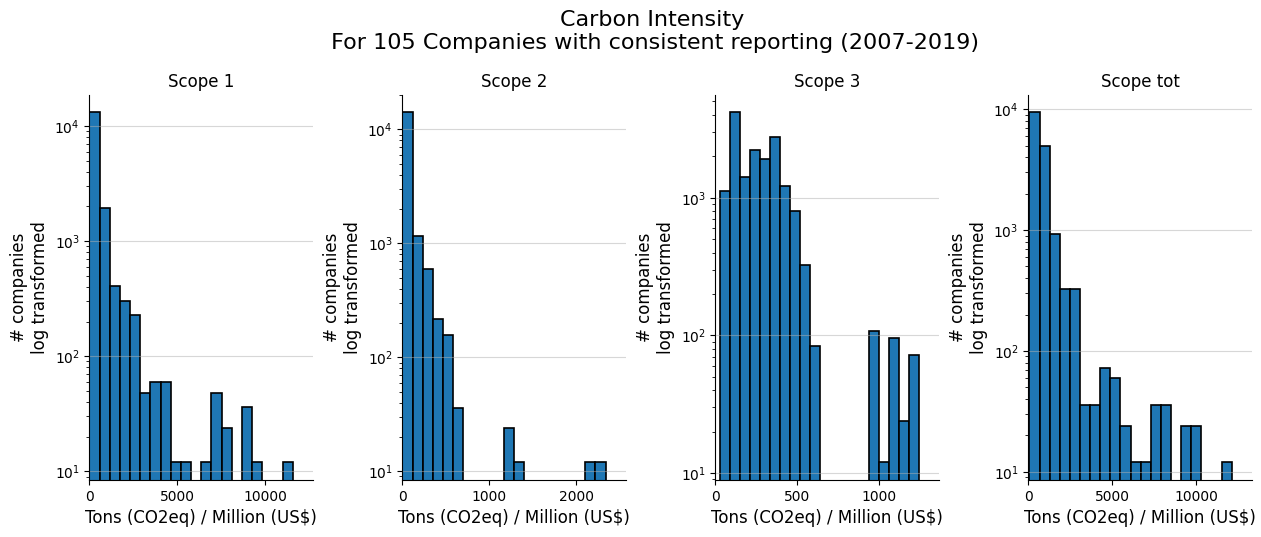

In [ ]:
get_hist_plot(data=df_quintiles, columns=scopes, title='Carbon Intensity\n For 105 Companies with consistent reporting (2007-2019)', log=True).show()



### Q5

Take the minimum variance portfolio from Question 3 of Homework 1 and calculate its E/S/G score or carbon intensity. Reallocate its composition in order to improve the E/S/G score by 20%/reduce carbon intensity by 50% (see optimization problem below). Comment on the changes it took in order to improve the ESG score/carbon intensity (e.g., how many and which firms (firm names) had to be removed in the most recent year of your sample in order to achieve these objectives). (30 points)

$$\min_{\alpha} \quad \alpha' \sum{\alpha}$$
$$\text{s.a.} \quad \alpha' e = 1$$
$$\quad \quad \alpha'\text{CI} \leq 0.5 \times \left( \alpha' CI \right)_{Q3-Homework1}$$

In [ ]:
df_5_returns = df_ret_q2_100.copy()
df_5_returns

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
date                                                                 
2005-01-31      0.012603      0.028704      0.032408     -0.058855   
2005-02-28      0.063502      0.094693      0.509758      0.818187   
2005-03-31      0.093039      0.258207      0.188845      0.373450   
2005-04-30     -0.038401     -0.103228     -0.130408     -0.114356   
2005-05-31     -0.027085     -0.011597     -0.048968     -0.006077   
...                  ...           ...           ...           ...   
2020-08-31      0.056431      0.286645      0.059829      0.221436   
2020-09-30      0.001871     -0.143275      0.102151      0.412873   
2020-10-31     -0.194313     -0.258657     -0.112195     -0.255603   
2020-11-30      0.037976     -0.083209     -0.052198     -0.095238   
2020-12-31      0.360397      0.459375      0.115942      0.480209   

            AU000000WHC8  BMG2108M2182  BMG5320C1082  BMG7998G1069  \
date                                                                 
2005-01-31           NaN     -0.000471     -0.016535           NaN   
2005-02-28           NaN     -0.012241     -0.068279           NaN   
2005-03-31           NaN      0.163489      0.122907           NaN   
2005-04-30           NaN      0.140516      0.000000           NaN   
2005-05-31           NaN      0.000359     -0.062137           NaN   
...                  ...           ...           ...           ...   
2020-08-31     -0.051895      0.001988      0.292894     -0.250000   
2020-09-30     -0.301476     -0.034939     -0.132470     -0.333333   
2020-10-31      0.193846     -0.147194     -0.097708      0.000000   
2020-11-30     -0.081615     -0.106459     -0.011904     -0.500000   
2020-12-31      0.389336      0.058069      0.195077      1.000000   

            BRUGPAACNOR8  CA00208D4084  ...  US6267171022  US6745991058  \
date                                    ...                               
2005-01-31      0.018039      0.040247  ...     -0.073156     -0.034093   
2005-02-28      0.022781      0.068301  ...      0.183691      0.050398   
2005-03-31      0.039161     -0.021335  ...      0.076223      0.166836   
2005-04-30     -0.018633      0.010010  ...      0.041474      0.066967   
2005-05-31      0.054247     -0.094755  ...     -0.102811     -0.049430   
...                  ...           ...  ...           ...           ...   
2020-08-31      0.013206      0.260780  ...      0.000000     -0.124066   
2020-09-30      0.082236      0.196934  ...      0.046020     -0.181639   
2020-10-31     -0.100370     -0.116689  ...     -0.391336     -0.223596   
2020-11-30     -0.176721      0.132537  ...     -0.059311     -0.003102   
2020-12-31      0.421079     -0.041827  ...      0.285438      0.567877   

            US6752321025  US69047Q1022  US7034811015  US7237871071  \
date                                                                 
2005-01-31     -0.024718     -0.032651     -0.043784     -0.013832   
2005-02-28      0.076323      0.111416      0.074072      0.138223   
2005-03-31      0.001818      0.104696      0.234225      0.080801   
2005-04-30     -0.012407      0.084223      0.062141      0.053351   
2005-05-31     -0.115115     -0.071625     -0.028285     -0.075271   
...                  ...           ...           ...           ...   
2020-08-31     -0.089538      0.050837      0.213504      0.024493   
2020-09-30     -0.025500      0.130313     -0.015173      0.052546   
2020-10-31     -0.349527     -0.331766     -0.335698     -0.173556   
2020-11-30      0.215522      0.313588      0.081692     -0.020907   
2020-12-31      0.531864      0.319899      0.620502      0.205282   

            US75281A1097  US8454671095  US9026531049  US91913Y1001  
date                                                                
2005-01-31     -0.048285     -0.106096      0.047824     -0.035393  
2005-02-28      0.171204      0.150111     -0.069058      0.322805  
2005-03-31      0.072868   

In [ ]:
target_years_start = 2015
target_years_end = 2019
all_years_end = 2020

target_span = target_years_end - target_years_start + 1
after_target_years = all_years_end - target_years_end

months = 12

In [ ]:
df_5_returns_2015 = df_5_returns[-(target_span+after_target_years)*months:-after_target_years*months]
df_5_returns_2015.head()

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  \
date                                                                 
2015-01-31      0.006719     -0.164872     -0.005507      0.101381   
2015-02-28     -0.009015     -0.100522     -0.044699     -0.017961   
2015-03-31      0.005589      0.044975      0.026087      0.035626   
2015-04-30     -0.004019      0.095382     -0.086764     -0.046419   
2015-05-31      0.103465      0.056425      0.122846     -0.026493   

            AU000000WHC8  BMG2108M2182  BMG5320C1082  BMG7998G1069  \
date                                                                 
2015-01-31      0.188698      0.231498     -0.075595     -0.142244   
2015-02-28     -0.129691      0.035793      0.099828     -0.009217   
2015-03-31      0.287973     -0.036665     -0.043730     -0.070976   
2015-04-30     -0.181300      0.027508     -0.025691     -0.149258   
2015-05-31      0.184944     -0.018012      0.229473      0.413952   

            BRUGPAACNOR8  CA00208D4084  ...  US6267171022  US6745991058  \
date                                    ...                               
2015-01-31     -0.044564     -0.045357  ...      0.030389      0.024206   
2015-02-28      0.041216     -0.120860  ...     -0.056809     -0.005590   
2015-03-31      0.019636      0.033370  ...      0.037727     -0.030188   
2015-04-30      0.037932     -0.105240  ...     -0.029932     -0.035823   
2015-05-31      0.091471      0.182898  ...     -0.022671      0.084315   

            US6752321025  US69047Q1022  US7034811015  US7237871071  \
date                                                                 
2015-01-31     -0.058284     -0.112785     -0.054965      0.027689   
2015-02-28     -0.074990     -0.062020      0.069321      0.055554   
2015-03-31      0.000745     -0.023056      0.027621     -0.015076   
2015-04-30      0.006094     -0.105374      0.066843      0.078642   
2015-05-31      0.009171      0.240693      0.161324      0.028042   

            US75281A1097  US8454671095  US9026531049  US91913Y1001  
date                                                                
2015-01-31     -0.181479     -0.125321      0.003582      0.012271  
2015-02-28     -0.105518     -0.048736      0.088614      0.099797  
2015-03-31      0.033882     -0.038134     -0.028237      0.085618  
2015-04-30      0.045428     -0.084502      0.042973      0.081473  
2015-05-31      0.254117      0.258967     -0.014832     -0.071710  

[5 rows x 100 columns]

In [ ]:
df_5_portfolio = df_q2_100_2015.iloc[:, : 10].copy()
df_5_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3  
0          -0.027115   39.621130   16.349542  236.880165  
1          -0.313132  171.209549   34.474243  331.997971  
2          -0.917602  176.623706  277.811755  121.399551  
3          -0.332542  411.939919  325.313283  121.642129  
4          -0.216742  712.307821   20.084699  220.339036  
...              ...         ...         ...         ...  
5995       -0.145554  464.846231   66.128086   99.109000  
5996       -1.201267  417.399669   49.973138   99.065497  
5997       -0.690964  246.128964   16.523077  180.032481  
5998        0.130654   12.880980   57.184705   30.416402  
5999        0.278711  186.419589   31.245203  440.245380  

[6000 rows x 10 columns]

#### Create minimum variance portfolio

In [ ]:
dates_2005 = sorted(list(set(df_5_returns.index.get_level_values('date').tolist())))

In [ ]:
for date in dates_2005:
  print(date)
  print(df_5_returns.loc[date].isna().sum().sum())

2005-01-31
15
2005-02-28
15
2005-03-31
15
2005-04-30
15
2005-05-31
14
2005-06-30
14
2005-07-31
12
2005-08-31
12
2005-09-30
11
2005-10-31
11
2005-11-30
10
2005-12-31
10
2006-01-31
10
2006-02-28
10
2006-03-31
10
2006-04-30
10
2006-05-31
10
2006-06-30
9
2006-07-31
9
2006-08-31
9
2006-09-30
9
2006-10-31
9
2006-11-30
8
2006-12-31
7
2007-01-31
5
2007-02-28
5
2007-03-31
5
2007-04-30
5
2007-05-31
4
2007-06-30
3
2007-07-31
2
2007-08-31
2
2007-09-30
1
2007-10-31
1
2007-11-30
1
2007-12-31
0
2008-01-31
0
2008-02-29
0
2008-03-31
0
2008-04-30
0
2008-05-31
0
2008-06-30
0
2008-07-31
0
2008-08-31
0
2008-09-30
0
2008-10-31
0
2008-11-30
0
2008-12-31
0
2009-01-31
0
2009-02-28
0
2009-03-31
0
2009-04-30
0
2009-05-31
0
2009-06-30
0
2009-07-31
0
2009-08-31
0
2009-09-30
0
2009-10-31
0
2009-11-30
0
2009-12-31
0
2010-01-31
0
2010-02-28
0
2010-03-31
0
2010-04-30
0
2010-05-31
0
2010-06-30
0
2010-07-31
0
2010-08-31
0
2010-09-30
0
2010-10-31
0
2010-11-30
0
2010-12-31
0
2011-01-31
0
2011-02-28
0
2011-03-31
0
2011-04-

We see that each month comprises some NaN values until November 2007.

In [ ]:
min_periods = len(df_5_returns.columns)-15+1
min_periods

86

In [ ]:
# build cov matrix

yrs = 10
cov_mats = df_5_returns.rolling(window=yrs*months, min_periods=min_periods).cov().iloc[-(target_span+after_target_years)*months*100:-after_target_years*months*100]
cov_mats

AN8068571086  ARP9897X1319  AU000000ERA9  \
date                                                                
2015-01-31 AN8068571086      0.009855      0.003047      0.006995   
           ARP9897X1319      0.003047      0.014883      0.003793   
           AU000000ERA9      0.006995      0.003793      0.025391   
           AU000000PDN8      0.010525      0.006392      0.022717   
           AU000000WHC8      0.009904      0.006375      0.017676   
...                               ...           ...           ...   
2019-12-31 US7237871071      0.006115      0.003149      0.004318   
           US75281A1097      0.005042      0.003090      0.003972   
           US8454671095      0.004937      0.003174      0.003112   
           US9026531049      0.001444     -0.000153      0.001721   
           US91913Y1001      0.005203      0.004072      0.003666   

                         AU000000PDN8  AU000000WHC8  BMG2108M2182  \
date                                                                
2015-01-31 AN8068571086      0.010525      0.009904      0.003810   
           ARP9897X1319      0.006392      0.006375      0.002983   
           AU000000ERA9      0.022717      0.017676      0.005697   
           AU000000PDN8      0.043092      0.024150      0.007451   
           AU000000WHC8      0.024150      0.041639      0.010051   
...                               ...           ...           ...   
2019-12-31 US7237871071      0.002837      0.005008      0.001515   
           US75281A1097      0.003858      0.002707     -0.000191   
           US8454671095      0.000079      0.002530      0.000457   
           US9026531049      0.001249      0.001387      0.000135   
           US91913Y1001      0.004114      0.002194      0.002047   

                         BMG5320C1082  BMG7998G1069  BRUGPAACNOR8  \
date                                                                
2015-01-31 AN8068571086      0.005753      0.010680      0.002055   
           ARP9897X1319      0.003536      0.004033      0.000330   
           AU000000ERA9      0.007513      0.011819      0.000615   
           AU000000PDN8      0.010965      0.016136      0.000597   
           AU000000WHC8      0.011222      0.020333      0.004239   
...                               ...           ...           ...   
2019-12-31 US7237871071      0.002956      0.009624     -0.000229   
           US75281A1097      0.002437      0.012820      0.002303   
           US8454671095      0.002020      0.011564      0.001413   
           US9026531049      0.001091      0.001219      0.000815   
           US91913Y1001      0.002848      0.007117      0.000281   

                         CA00208D4084  ...  US6267171022  US6745991058  \
date                                   ...                               
2015-01-31 AN8068571086      0.005452  ...      0.006802      0.006146   
           ARP9897X1319      0.003246  ...      0.003045      0.003282   
           AU000000ERA9      0.005931  ...      0.007746      0.006612   
           AU000000PDN8      0.008762  ...      0.010049      0.009712   
           AU000000WHC8      0.010718  ...      0.012331      0.012591   
...                               ...  ...           ...           ...   
2019-12-31 US7237871071      0.003790  ...      0.006986      0.005128   
           US75281A1097      0.005562  ...      0.007986      0.004274   
           US8454671095      0.006551  ...      0.010190      0.004287   
           US9026531049      0.000845  ...      0.001356      0.001473   
           US91913Y1001      0.003108  ...      0.004476      0.004498   

                         US6752321025  US69047Q1022  US7034811015  \
date                                                                
2015-01-31 AN8068571086      0.008686      0.005447      0.008981   
           ARP9897X1319      0.003109      0.003615      0.004898   
           AU000000ERA9      0.008350      0.008034      0.007892   
           AU000000PDN8

In [ ]:
cov_mats.isna().sum().sum()

0

In [ ]:
dates = sorted(list(set(cov_mats.index.get_level_values('date').tolist())))

In [ ]:
cov_mats.describe()

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  AU000000WHC8  \
count   6000.000000   6000.000000   6000.000000   6000.000000   6000.000000   
mean       0.005701      0.003903      0.006102      0.007761      0.009455   
std        0.002452      0.002192      0.003422      0.006641      0.005447   
min       -0.000980     -0.000768     -0.000292     -0.002762     -0.000762   
25%        0.003871      0.002682      0.003857      0.003892      0.005782   
50%        0.005792      0.003848      0.005931      0.007432      0.008764   
75%        0.007609      0.004943      0.007616      0.010295      0.012515   
max        0.012418      0.020117      0.027125      0.086390      0.045891   

       BMG2108M2182  BMG5320C1082  BMG7998G1069  BRUGPAACNOR8  CA00208D4084  \
count   6000.000000   6000.000000   6000.000000   6000.000000   6000.000000   
mean       0.003245      0.004969      0.009771      0.002455      0.005302   
std        0.002239      0.002575      0.004993      0.003346      0.002508   
min       -0.002896     -0.000396     -0.002541     -0.002537     -0.000997   
25%        0.001737      0.003034      0.006453      0.001099      0.003493   
50%        0.003145      0.004641      0.009775      0.002051      0.005492   
75%        0.004449      0.006524      0.012785      0.003181      0.007170   
max        0.016853      0.019536      0.046324      0.040364      0.011361   

       ...  US6267171022  US6745991058  US6752321025  US69047Q1022  \
count  ...   6000.000000   6000.000000   6000.000000   6000.000000   
mean   ...      0.006534      0.005016      0.006523      0.006166   
std    ...      0.003123      0.002206      0.003101      0.002969   
min    ...     -0.001773     -0.000599     -0.001626     -0.000304   
25%    ...      0.004524      0.003528      0.004323      0.004044   
50%    ...      0.006391      0.005232      0.006720      0.006101   
75%    ...      0.008662      0.006581      0.008622      0.008164   
max    ...      0.016112      0.012591      0.016177      0.015215   

       US7034811015  US7237871071  US75281A1097  US8454671095  US9026531049  \
count   6000.000000   6000.000000   6000.000000   6000.000000   6000.000000   
mean       0.006989      0.007224      0.004599      0.005378      0.002733   
std        0.003524      0.003606      0.002660      0.003215      0.001715   
min       -0.002153     -0.002064     -0.002054     -0.001239     -0.001229   
25%        0.004478      0.004604      0.002735      0.003109      0.001418   
50%        0.007268      0.007233      0.004350      0.005087      0.002701   
75%        0.009300      0.009609      0.006330      0.007528      0.003865   
max        0.018300      0.018244      0.013598      0.019537      0.008639   

       US91913Y1001  
count   6000.000000  
mean       0.005149  
std        0.002491  
min       -0.000534  
25%        0.003355  
50%        0.005085  
75%        0.006596  
max        0.016235  

[8 rows x 100 columns]

In [ ]:
df_5_returns_2015.describe()

AN8068571086  ARP9897X1319  AU000000ERA9  AU000000PDN8  AU000000WHC8  \
count     60.000000     60.000000     60.000000     60.000000     60.000000   
mean      -0.008288     -0.010080     -0.014563      0.013161      0.029498   
std        0.080503      0.147140      0.178789      0.369305      0.175168   
min       -0.211903     -0.384390     -0.697007     -0.533101     -0.415572   
25%       -0.053266     -0.101228     -0.091627     -0.112988     -0.089560   
50%       -0.009153     -0.015605     -0.029286     -0.026680      0.010085   
75%        0.026852      0.072460      0.045958      0.046910      0.139752   
max        0.235031      0.405229      0.681818      2.491476      0.616878   

       BMG2108M2182  BMG5320C1082  BMG7998G1069  BRUGPAACNOR8  CA00208D4084  \
count     60.000000     60.000000     60.000000     60.000000     60.000000   
mean       0.005156      0.003004     -0.082826     -0.004167     -0.016391   
std        0.129322      0.093484      0.274494      0.097924      0.098708   
min       -0.284525     -0.267756     -0.773207     -0.222462     -0.252265   
25%       -0.063993     -0.048548     -0.231932     -0.060420     -0.084634   
50%        0.001537     -0.002313     -0.117749     -0.007250     -0.023226   
75%        0.054314      0.052658      0.044926      0.051444      0.036994   
max        0.401480      0.229473      0.795455      0.291264      0.233814   

       ...  US6267171022  US6745991058  US6752321025  US69047Q1022  \
count  ...     60.000000     60.000000     60.000000     60.000000   
mean   ...      0.000548     -0.005359     -0.016081     -0.010499   
std    ...      0.142152      0.074213      0.124250      0.151465   
min    ...     -0.269063     -0.182245     -0.310936     -0.379640   
25%    ...     -0.074367     -0.034316     -0.086828     -0.091843   
50%    ...     -0.014251     -0.005343     -0.025995     -0.020733   
75%    ...      0.062659      0.032956      0.055759      0.073176   
max    ...      0.448476      0.184161      0.312406      0.419967   

       US7034811015  US7237871071  US75281A1097  US8454671095  US9026531049  \
count     60.000000     60.000000     60.000000     60.000000     60.000000   
mean      -0.002030      0.001551     -0.038499     -0.031011      0.010721   
std        0.126888      0.085232      0.136286      0.179972      0.044447   
min       -0.286441     -0.199853     -0.353676     -0.338821     -0.078895   
25%       -0.096867     -0.043539     -0.128186     -0.141403     -0.014285   
50%       -0.009622      0.006698     -0.045460     -0.057116      0.006063   
75%        0.068461      0.049808      0.022889      0.074519      0.041607   
max        0.308276      0.191422      0.341757      0.638923      0.104182   

       US91913Y1001  
count     60.000000  
mean       0.017990  
std        0.086052  
min       -0.189249  
25%       -0.033103  
50%        0.014074  
75%        0.084644  
max        0.209263  

[8 rows x 100 columns]

In [ ]:
def get_min_var_weights (covariance_matrix, df_results):

    # Optimal min var weights
    min_var_weights = []  # Empty list

    # variances
    variances = []

    for date in dates:

        # Define objective func
        def objective(weights, covariance_matrix):
            return weights.T @ covariance_matrix @ weights

            # Define constraint func
        def constraint1(weights):
            return np.sum(weights) - 1

        # Define vars
        cov_mat = covariance_matrix.loc[date]

        returns = df_results.loc[date]

        constraints = [{'type': 'eq', 'fun': constraint1}]

        bounds = tuple((0, 1) for x in range(len(returns)))

        weights = np.ones(len(returns)) / len(returns)

        result = minimize(objective, weights, args=cov_mat,
                          constraints=constraints, bounds=bounds)

        month_weights = result.x / np.sum(result.x)
        month_weights = list(month_weights)
        min_var_weights.append(month_weights)

        #Store the min variances
        min_var = result.fun
        variances.append(min_var)

        print(f'Weights computed for date: {date}')

    portfolio_variance = sum(variances)/target_span
    portfolio_volatility = math.sqrt(portfolio_variance)
    
    return min_var_weights, portfolio_volatility

In [ ]:
min_var_weights, portfolio_volatility = get_min_var_weights(cov_mats, df_5_returns_2015)

Weights computed for date: 2015-01-31
Weights computed for date: 2015-02-28
Weights computed for date: 2015-03-31
Weights computed for date: 2015-04-30
Weights computed for date: 2015-05-31
Weights computed for date: 2015-06-30
Weights computed for date: 2015-07-31
Weights computed for date: 2015-08-31
Weights computed for date: 2015-09-30
Weights computed for date: 2015-10-31
Weights computed for date: 2015-11-30
Weights computed for date: 2015-12-31
Weights computed for date: 2016-01-31
Weights computed for date: 2016-02-29
Weights computed for date: 2016-03-31
Weights computed for date: 2016-04-30
Weights computed for date: 2016-05-31
Weights computed for date: 2016-06-30
Weights computed for date: 2016-07-31
Weights computed for date: 2016-08-31
Weights computed for date: 2016-09-30
Weights computed for date: 2016-10-31
Weights computed for date: 2016-11-30
Weights computed for date: 2016-12-31
Weights computed for date: 2017-01-31
Weights computed for date: 2017-02-28
Weights comp

In [ ]:
portfolio_volatility

0.12057957857247857

In [ ]:
len(min_var_weights)

60

In [ ]:
for i in range(len(min_var_weights)):
  print(sum(min_var_weights[i]))

1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999998
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999997
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
0.9999999999999998
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999998
1.0
1.0000000000000002
0.9999999999999998


In [ ]:
# throw weights in a dataframe to later add them to the main q3 dataframe
df_min_var_weights = pd.DataFrame()

for i in range(len(min_var_weights)):

    month_weights = pd.Series(min_var_weights[i])
    df_min_var_weights = pd.concat(
        [df_min_var_weights, month_weights], ignore_index=True)

df_min_var_weights.columns.values[0] = "min_var_weights"
df_min_var_weights

min_var_weights
0        1.417489e-18
1        3.851186e-18
2        0.000000e+00
3        4.518671e-18
4        1.080874e-17
...               ...
5995     0.000000e+00
5996     0.000000e+00
5997     0.000000e+00
5998     1.566084e-01
5999     6.733722e-19

[6000 rows x 1 columns]

In [ ]:
df_5_mv_portfolio = df_5_portfolio.copy()
df_5_mv_portfolio['mv_weights'] = df_min_var_weights.min_var_weights
df_5_mv_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3    mv_weights  
0          -0.027115   39.621130   16.349542  236.880165  1.417489e-18  
1          -0.313132  171.209549   34.474243  331.997971  3.851186e-18  
2          -0.917602  176.623706  277.811755  121.399551  0.000000e+00  
3          -0.332542  411.939919  325.313283  121.642129  4.518671e-18  
4          -0.216742  712.307821   20.084699  220.339036  1.080874e-17  
...              ...         ...         ...         ...           ...  
5995       -0.145554  464.846231   66.128086   99.109000  0.000000e+00  
5996       -1.201267  417.399669   49.973138   99.065497  0.000000e+00  
5997       -0.690964  246.128964   16.523077  180.032481  0.000000e+00  
5998        0.130654   12.880980   57.184705   30.416402  1.566084e-01  
5999        0.278711  186.419589   31.245203  440.245380  6.733722e-19  

[6000 rows x 11 columns]

In [ ]:
def calculate_portfolio_return_columns (df, volatility):
  # Computing the monthly returns for each ISIN based on the market cap weight per month
  df['mv_assets_monthly_weighted_returns'] = df['monthly_return'] * df['mv_weights']

  # Computing the AAR of the minvar-weighted portfolio by suming all the monthly weighted returns across the portfolio and dividing by 6 years of data
  df['mv_AAR'] = (df['mv_assets_monthly_weighted_returns'].sum())/target_span

  # Computing the annual return of the value-weighted portfolio
  annual_return_df = df[['year', 'mv_assets_monthly_weighted_returns']].groupby('year').sum()

  def annual_return_func(row):
      year = row['year']
      return annual_return_df.loc[(year)][0]

  df['mv_annual_return'] = df.apply(annual_return_func, axis=1)

  # Computing the monthly return of the value-weighted portfolio
  monthly_returns_df = df[['year', 'month', 'mv_assets_monthly_weighted_returns']].groupby(['year', 'month']).sum()

  def monthly_returns_func(row):
      year = row['year']
      month = row['month']
      return monthly_returns_df.loc[(year, month)][0]

  df['mv_monthly_returns'] = df.apply(monthly_returns_func, axis=1)

  # Computing portfolio volatility
  df['mv_volatility'] = volatility

  return df

In [ ]:
df_5_mv_portfolio = calculate_portfolio_return_columns(df_5_mv_portfolio, portfolio_volatility)
df_5_mv_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3    mv_weights  \
0          -0.027115   39.621130   16.349542  236.880165  1.417489e-18   
1          -0.313132  171.209549   34.474243  331.997971  3.851186e-18   
2          -0.917602  176.623706  277.811755  121.399551  0.000000e+00   
3          -0.332542  411.939919  325.313283  121.642129  4.518671e-18   
4          -0.216742  712.307821   20.084699  220.339036  1.080874e-17   
...              ...         ...         ...         ...           ...   
5995       -0.145554  464.846231   66.128086   99.109000  0.000000e+00   
5996       -1.201267  417.399669   49.973138   99.065497  0.000000e+00   
5997       -0.690964  246.128964   16.523077  180.032481  0.000000e+00   
5998        0.130654   12.880980   57.184705   30.416402  1.566084e-01   
5999        0.278711  186.419589   31.245203  440.245380  6.733722e-19   

      mv_assets_monthly_weighted_returns    mv_AAR  mv_annual_return  \
0                           9.524475e-21  0.048385         -0.012319   
1                          -6.349530e-19  0.048385         -0.012319   
2                          -0.000000e+00  0.048385         -0.012319   
3                           4.581055e-19  0.048385         -0.012319   
4                           2.039587e-18  0.048385         -0.012319   
...                                  ...       ...               ...   
5995                       -0.000000e+00  0.048385          0.046683   
5996                       -0.000000e+00  0.048385          0.046683   
5997                       -0.000000e+00  0.048385          0.046683   
5998                       -9.289703e-03  0.048385          0.046683   
5999                       -2.277977e-20  0.048385          0.046683   

      mv_monthly_returns  mv_volatility  
0              -0.015541        0.12058  
1              -0.015541        0.12058  
2              -0.015541        0.12058  
3              -0.015541        0.12058  
4              -0.015541        0.12058  
...                  ...            ...  
5995           -0.012793        0.12058  
5996           -0.012793        0.12058  
5997           -0.012793        0.12058  
5998           -0.012793        0.12058  
5999           -0.012793        0.12058  

[6000 rows x 16 columns]

In [ ]:
# Other general statistics
mv_min = df_5_mv_portfolio['mv_annual_return'].min()
mv_max = df_5_mv_portfolio['mv_annual_return'].max()
mv_sharperatio = (df_5_mv_portfolio['mv_AAR'].mean() - risk_free_rate)/df_5_mv_portfolio['mv_volatility'].mean()

In [ ]:
mv_AAR = (df_5_mv_portfolio['mv_assets_monthly_weighted_returns'].sum())/target_span
mv_volatility = portfolio_volatility

print(f'AAR: {round(mv_AAR*100, 3)}%')
print(f'Annualized volatility: {round(mv_volatility*100, 3)}%')
print(f'Max yearly return: {round(mv_max*100, 3)}%')
print(f'Min yearly return: {round(mv_min*100, 3)}%')
print(f'Sharpe ratio: {round(mv_sharperatio, 3)}')

AAR: 4.838%
Annualized volatility: 12.058%
Max yearly return: 21.199%
Min yearly return: -1.774%
Sharpe ratio: 0.111


#### Calculate min var portfolio carbon intensity

In [ ]:
def calculate_portfolio_CI (df):
    #computing the weighted scope 1,2,3 for each asset
    df['weighted_Scope_1_CI'] = df['mv_weights'] * df['Scope_1']
    df['weighted_Scope_2_CI'] = df['mv_weights'] * df['Scope_2']
    df['weighted_Scope_3_CI'] = df['mv_weights'] * df['Scope_3']
    
    #computing the weighted average scopes of the portfolio for each scope
    df['WA_Scope_1_CI'] = df['weighted_Scope_1_CI'].sum()/(months*target_span)
    df['WA_Scope_2_CI'] = df['weighted_Scope_2_CI'].sum()/(months*target_span)
    df['WA_Scope_3_CI'] = df['weighted_Scope_3_CI'].sum()/(months*target_span)
    
    #computing the weighted average carbon intensity across the three scopes
    df['WA_All_Scopes_CI'] = (df['WA_Scope_1_CI']+df['WA_Scope_2_CI']+df['WA_Scope_3_CI'])

In [ ]:
calculate_portfolio_CI(df_5_mv_portfolio)
df_5_mv_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3  ...  \
0          -0.027115   39.621130   16.349542  236.880165  ...   
1          -0.313132  171.209549   34.474243  331.997971  ...   
2          -0.917602  176.623706  277.811755  121.399551  ...   
3          -0.332542  411.939919  325.313283  121.642129  ...   
4          -0.216742  712.307821   20.084699  220.339036  ...   
...              ...         ...         ...         ...  ...   
5995       -0.145554  464.846231   66.128086   99.109000  ...   
5996       -1.201267  417.399669   49.973138   99.065497  ...   
5997       -0.690964  246.128964   16.523077  180.032481  ...   
5998        0.130654   12.880980   57.184705   30.416402  ...   
5999        0.278711  186.419589   31.245203  440.245380  ...   

      mv_annual_return  mv_monthly_returns  mv_volatility  \
0            -0.012319           -0.015541        0.12058   
1            -0.012319           -0.015541        0.12058   
2            -0.012319           -0.015541        0.12058   
3            -0.012319           -0.015541        0.12058   
4            -0.012319           -0.015541        0.12058   
...                ...                 ...            ...   
5995          0.046683           -0.012793        0.12058   
5996          0.046683           -0.012793        0.12058   
5997          0.046683           -0.012793        0.12058   
5998          0.046683           -0.012793        0.12058   
5999          0.046683           -0.012793        0.12058   

      weighted_Scope_1_CI  weighted_Scope_2_CI  weighted_Scope_3_CI  \
0            5.616253e-17         2.317530e-17         3.357751e-16   
1            6.593598e-16         1.327667e-16         1.278586e-15   
2            0.000000e+00         0.000000e+00         0.000000e+00   
3            1.861421e-15         1.469984e-15         5.496608e-16   
4            7.699148e-15         2.170902e-16         2.381587e-15   
...                   ...                  ...                  ...   
5995         0.000000e+00         0.000000e+00         0.000000e+00   
5996         0.000000e+00         0.000000e+00         0.000000e+00   
5997         0.000000e+00         0.000000e+00         0.000000e+00   
5998         2.017270e+00         8.955608e+00         4.763465e+00   
5999         1.255298e-16         2.103965e-17         2.964490e-16   

      WA_Scope_1_CI  WA_Scope_2_CI  WA_Scope_3_CI  WA_All_Scopes_CI  
0        355.703268      30.475405     261.998693        648.177366  
1        355.703268      30.475405     261.998693        648.177366  
2        355.703268      30.475405     261.998693        648.177366  
3        355.703268      30.475405     261.998693        648.177366  
4        355.703268      30.475405     261.998693        648.177366  
...             ...            ...            ...               ...  
5995     355.703268      30.475405     261.998693        648.177366  
5996     355.703268      30.475405     261.998693        648.177366  
5997     355.703268      30.475405     261.998693        648.177366  
5998     355.703268 

In [ ]:
df_5_mv_portfolio.describe()

year       month  monthly_return    market_cap  annual_returns  \
count  6000.000000  6000.00000     6000.000000  5.952000e+03     6000.000000   
mean   2017.000000     6.50000        0.001234  2.220350e+10        0.014805   
std       1.414331     3.45234        0.120776  4.734615e+10        0.419270   
min    2015.000000     1.00000       -0.773207  4.302850e+07       -2.012119   
25%    2016.000000     3.75000       -0.062935  3.040935e+09       -0.183816   
50%    2017.000000     6.50000       -0.001232  6.400745e+09        0.015437   
75%    2018.000000     9.25000        0.058576  1.862730e+10        0.262188   
max    2019.000000    12.00000        2.491476  3.887070e+11        2.704316   

            Scope_1      Scope_2      Scope_3    mv_weights  \
count   6000.000000  6000.000000  6000.000000  6.000000e+03   
mean     578.809895    71.272236   270.822814  1.000000e-02   
std     1022.815276   154.622221   187.159488  3.676611e-02   
min        1.386262     0.011872    29.677929  0.000000e+00   
25%      131.104870    14.120295   112.229363  0.000000e+00   
50%      352.794454    35.299035   243.612648  7.197580e-19   
75%      636.110834    61.099090   370.151333  4.061328e-18   
max    11563.308594  2772.090643  1173.624960  3.289667e-01   

       mv_assets_monthly_weighted_returns  ...  mv_annual_return  \
count                        6.000000e+03  ...       6000.000000   
mean                         4.032077e-05  ...          0.048385   
std                          2.805671e-03  ...          0.084926   
min                         -7.856584e-02  ...         -0.017738   
25%                         -2.365927e-20  ...         -0.012319   
50%                         -0.000000e+00  ...          0.013312   
75%                          1.797304e-20  ...          0.046683   
max                          5.964739e-02  ...          0.211988   

       mv_monthly_returns  mv_volatility  weighted_Scope_1_CI  \
count         6000.000000     6000.00000         6.000000e+03   
mean             0.004032        0.12058         3.557033e+00   
std              0.031300        0.00000         1.899120e+01   
min             -0.078671        0.12058         0.000000e+00   
25%             -0.019362        0.12058         0.000000e+00   
50%             -0.002544        0.12058         1.118058e-16   
75%              0.024839        0.12058         1.931064e-15   
max              0.066665        0.12058         2.559499e+02   

       weighted_Scope_2_CI  weighted_Scope_3_CI  WA_Scope_1_CI  WA_Scope_2_CI  \
count         6.000000e+03         6.000000e+03   6.000000e+03    6000.000000   
mean          3.047541e-01         2.619987e+00   3.557033e+02      30.475405   
std           1.200375e+00         1.367047e+01   1.136963e-13       0.000000   
min           0.000000e+00         0.000000e+00   3.557033e+02      30.475405   
25%           0.000000e+00         0.000000e+00   3.557033e+02      30.475405   
50%           1.102308e-17         1.311092e-16   3.557033e+02      30.475405   
75%           2.270093e-16         1.121198e-15   3.557033e+02      30.475405   
max           1.361176e+01         1.746801e+02   3.557033e+02      30.475405   

       WA_Scope_3_CI  WA_All_Scopes_CI  
count   6.000000e+03      6.000000e+03  
mean    2.619987e+02      6.481774e+02  
std     5.684816e-14      2.273926e-13  
min     2.619987e+02      6.481774e+02  
25%     2.619987e+02      6.481774e+02  
50%     2.619987e+02      6.481774e+02  
75%     2.619987e+02      6.481774e+02  
max     2.619987e+02      6.481774e+02  

[8 rows x 21 columns]

In [ ]:
# Generate sample data
x = df_5_mv_portfolio.groupby('year').year.mean()
y1 = df_5_mv_portfolio.groupby('year').mv_annual_return.mean()

# Create figure
fig = go.Figure()

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1, name='Min var portfolio annual returns',
              line=dict(color='lightblue', width=5)))

# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=16),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=8), side='top')),
                  legend_title_font=dict(size=12),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year',
                  font=dict(size=22), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=12),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=12),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()

#### Reallocating composition to reduce carbon intensity

Take the minimum variance portfolio from Question 3 of Homework 1 and calculate its E/S/G score or carbon intensity. Reallocate its composition in order to improve the E/S/G score by 20%/reduce carbon intensity by 50% (see optimization problem below). Comment on the changes it took in order to improve the ESG score/carbon intensity (e.g., how many and which firms (firm names) had to be removed in the most recent year of your sample in order to achieve these objectives). (30 points)

Optimization problem:
$$\min_{\alpha} \quad \alpha' \sum{\alpha}$$
$$\text{s.a.} \quad \alpha' e = 1$$
$$\quad \quad \alpha'\text{CI} \leq 0.5 \times \left( \alpha' CI \right)_{Q3-Homework1}$$

In [ ]:
original_CI = df_5_mv_portfolio['WA_All_Scopes_CI'][0]
original_CI

648.1773660852816

In [ ]:
reduction_target = 0.5
target_CI = original_CI*(1-reduction_target)
target_CI

324.0886830426408

In [ ]:
def get_greener_min_var_weights (covariance_matrix, df_results):

    # Optimal min var weights
    greener_min_var_weights = []  # Empty list

    # variances
    variances = []

    for date in dates:

        # Define objective func
        def objective(weights, covariance_matrix):
            return weights.T @ covariance_matrix @ weights

        # constraint #1: sum of the weights = 1
        def constraint1(weights):
            return np.sum(weights) - 1

        # constraint #2: weights*CI = carbon intensity target
        def constraint2(weights):
            return all_scopes_CI.multiply(weights, axis=0).sum() - target_CI

        # Define vars
        cov_mat = covariance_matrix.loc[date]

        returns = df_results.loc[date]

        # get monthly CI
        scope1_CI = df_5_portfolio.loc[df_5_portfolio['date'] == date]['Scope_1']
        scope2_CI = df_5_portfolio.loc[df_5_portfolio['date'] == date]['Scope_2']
        scope3_CI = df_5_portfolio.loc[df_5_portfolio['date'] == date]['Scope_3']
        all_scopes_CI = scope1_CI + scope2_CI + scope3_CI

        constraints = [{'type': 'eq', 'fun': constraint1}, {'type': 'eq', 'fun': constraint2}]

        bounds = tuple((0, 1) for x in range(len(returns)))

        weights = np.ones(len(returns)) / len(returns)

        result = minimize(objective, weights, args=cov_mat,
                          constraints=constraints, bounds=bounds)

        month_weights = result.x / np.sum(result.x)
        month_weights = list(month_weights)
        greener_min_var_weights.append(month_weights)

        #Store the min variances
        min_var = result.fun
        variances.append(min_var)
      
        print(f'Greener weights computed for date: {date}')

    greener_portfolio_variance = sum(variances)/target_span
    greener_portfolio_volatility = math.sqrt(greener_portfolio_variance)

    return greener_min_var_weights, greener_portfolio_volatility

In [ ]:
greener_min_var_weights, greener_portfolio_volatility = get_greener_min_var_weights(cov_mats, df_5_returns_2015)

Greener weights computed for date: 2015-01-31
Greener weights computed for date: 2015-02-28
Greener weights computed for date: 2015-03-31
Greener weights computed for date: 2015-04-30
Greener weights computed for date: 2015-05-31
Greener weights computed for date: 2015-06-30
Greener weights computed for date: 2015-07-31
Greener weights computed for date: 2015-08-31
Greener weights computed for date: 2015-09-30
Greener weights computed for date: 2015-10-31
Greener weights computed for date: 2015-11-30
Greener weights computed for date: 2015-12-31
Greener weights computed for date: 2016-01-31
Greener weights computed for date: 2016-02-29
Greener weights computed for date: 2016-03-31
Greener weights computed for date: 2016-04-30
Greener weights computed for date: 2016-05-31
Greener weights computed for date: 2016-06-30
Greener weights computed for date: 2016-07-31
Greener weights computed for date: 2016-08-31
Greener weights computed for date: 2016-09-30
Greener weights computed for date:

In [ ]:
greener_portfolio_volatility

0.1331145119548889

In [ ]:
for i in range(len(greener_min_var_weights)):
  print(sum(greener_min_var_weights[i]))

0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0
0.9999999999999999
1.0
1.0
0.9999999999999997
1.0
1.0
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000002
1.0
0.9999999999999997
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0
1.0
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999998
1.0000000000000002
0.9999999999999999
1.0
1.0
1.0
1.0000000000000002
1.0


In [ ]:
# throw weights in a dataframe to later add them to the main q3 dataframe
df_greener_min_var_weights = pd.DataFrame()

for i in range(len(greener_min_var_weights)):

    month_weights = pd.Series(greener_min_var_weights[i])
    df_greener_min_var_weights = pd.concat(
        [df_greener_min_var_weights, month_weights], ignore_index=True)

df_greener_min_var_weights.columns.values[0] = "greener_min_var_weights"
df_greener_min_var_weights

greener_min_var_weights
0                4.084732e-18
1                4.241374e-03
2                0.000000e+00
3                4.836219e-18
4                0.000000e+00
...                       ...
5995             1.039312e-18
5996             0.000000e+00
5997             0.000000e+00
5998             2.539353e-01
5999             4.520864e-20

[6000 rows x 1 columns]

In [ ]:
df_5_greener_mv_portfolio = df_5_portfolio.copy()
df_5_greener_mv_portfolio['mv_weights'] = df_greener_min_var_weights.greener_min_var_weights
df_5_greener_mv_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3    mv_weights  
0          -0.027115   39.621130   16.349542  236.880165  4.084732e-18  
1          -0.313132  171.209549   34.474243  331.997971  4.241374e-03  
2          -0.917602  176.623706  277.811755  121.399551  0.000000e+00  
3          -0.332542  411.939919  325.313283  121.642129  4.836219e-18  
4          -0.216742  712.307821   20.084699  220.339036  0.000000e+00  
...              ...         ...         ...         ...           ...  
5995       -0.145554  464.846231   66.128086   99.109000  1.039312e-18  
5996       -1.201267  417.399669   49.973138   99.065497  0.000000e+00  
5997       -0.690964  246.128964   16.523077  180.032481  0.000000e+00  
5998        0.130654   12.880980   57.184705   30.416402  2.539353e-01  
5999        0.278711  186.419589   31.245203  440.245380  4.520864e-20  

[6000 rows x 11 columns]

In [ ]:
df_5_greener_mv_portfolio = calculate_portfolio_return_columns(df_5_greener_mv_portfolio, greener_portfolio_volatility)
df_5_greener_mv_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3    mv_weights  \
0          -0.027115   39.621130   16.349542  236.880165  4.084732e-18   
1          -0.313132  171.209549   34.474243  331.997971  4.241374e-03   
2          -0.917602  176.623706  277.811755  121.399551  0.000000e+00   
3          -0.332542  411.939919  325.313283  121.642129  4.836219e-18   
4          -0.216742  712.307821   20.084699  220.339036  0.000000e+00   
...              ...         ...         ...         ...           ...   
5995       -0.145554  464.846231   66.128086   99.109000  1.039312e-18   
5996       -1.201267  417.399669   49.973138   99.065497  0.000000e+00   
5997       -0.690964  246.128964   16.523077  180.032481  0.000000e+00   
5998        0.130654   12.880980   57.184705   30.416402  2.539353e-01   
5999        0.278711  186.419589   31.245203  440.245380  4.520864e-20   

      mv_assets_monthly_weighted_returns    mv_AAR  mv_annual_return  \
0                           2.744636e-20  0.060933          0.052665   
1                          -6.992841e-04  0.060933          0.052665   
2                          -0.000000e+00  0.060933          0.052665   
3                           4.902988e-19  0.060933          0.052665   
4                           0.000000e+00  0.060933          0.052665   
...                                  ...       ...               ...   
5995                       -6.356299e-21  0.060933         -0.003135   
5996                       -0.000000e+00  0.060933         -0.003135   
5997                       -0.000000e+00  0.060933         -0.003135   
5998                       -1.506294e-02  0.060933         -0.003135   
5999                       -1.529381e-21  0.060933         -0.003135   

      mv_monthly_returns  mv_volatility  
0               0.025565       0.133115  
1               0.025565       0.133115  
2               0.025565       0.133115  
3               0.025565       0.133115  
4               0.025565       0.133115  
...                  ...            ...  
5995           -0.011373       0.133115  
5996           -0.011373       0.133115  
5997           -0.011373       0.133115  
5998           -0.011373       0.133115  
5999           -0.011373       0.133115  

[6000 rows x 16 columns]

In [ ]:
# Other general statistics
greener_mv_min = df_5_greener_mv_portfolio['mv_annual_return'].min()
greener_mv_max = df_5_greener_mv_portfolio['mv_annual_return'].max()
greener_mv_sharperatio = (df_5_greener_mv_portfolio['mv_AAR'].mean() - risk_free_rate)/df_5_greener_mv_portfolio['mv_volatility'].mean()

In [ ]:
greener_mv_AAR = (df_5_greener_mv_portfolio['mv_assets_monthly_weighted_returns'].sum())/target_span
greener_mv_volatility = greener_portfolio_volatility

print(f'AAR: {round(greener_mv_AAR*100, 3)}%')
print(f'Annualized volatility: {round(greener_mv_volatility*100, 3)}%')
print(f'Max yearly return: {round(greener_mv_max*100, 3)}%')
print(f'Min yearly return: {round(greener_mv_min*100, 3)}%')
print(f'Sharpe ratio: {round(greener_mv_sharperatio, 3)}')

AAR: 6.093%
Annualized volatility: 13.311%
Max yearly return: 22.993%
Min yearly return: -1.516%
Sharpe ratio: 0.195


In [ ]:
calculate_portfolio_CI(df_5_greener_mv_portfolio)
df_5_greener_mv_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3  ...  \
0          -0.027115   39.621130   16.349542  236.880165  ...   
1          -0.313132  171.209549   34.474243  331.997971  ...   
2          -0.917602  176.623706  277.811755  121.399551  ...   
3          -0.332542  411.939919  325.313283  121.642129  ...   
4          -0.216742  712.307821   20.084699  220.339036  ...   
...              ...         ...         ...         ...  ...   
5995       -0.145554  464.846231   66.128086   99.109000  ...   
5996       -1.201267  417.399669   49.973138   99.065497  ...   
5997       -0.690964  246.128964   16.523077  180.032481  ...   
5998        0.130654   12.880980   57.184705   30.416402  ...   
5999        0.278711  186.419589   31.245203  440.245380  ...   

      mv_annual_return  mv_monthly_returns  mv_volatility  \
0             0.052665            0.025565       0.133115   
1             0.052665            0.025565       0.133115   
2             0.052665            0.025565       0.133115   
3             0.052665            0.025565       0.133115   
4             0.052665            0.025565       0.133115   
...                ...                 ...            ...   
5995         -0.003135           -0.011373       0.133115   
5996         -0.003135           -0.011373       0.133115   
5997         -0.003135           -0.011373       0.133115   
5998         -0.003135           -0.011373       0.133115   
5999         -0.003135           -0.011373       0.133115   

      weighted_Scope_1_CI  weighted_Scope_2_CI  weighted_Scope_3_CI  \
0            1.618417e-16         6.678349e-17         9.675919e-16   
1            7.261637e-01         1.462181e-01         1.408127e+00   
2            0.000000e+00         0.000000e+00         0.000000e+00   
3            1.992232e-15         1.573286e-15         5.882880e-16   
4            0.000000e+00         0.000000e+00         0.000000e+00   
...                   ...                  ...                  ...   
5995         4.831203e-16         6.872772e-17         1.030052e-16   
5996         0.000000e+00         0.000000e+00         0.000000e+00   
5997         0.000000e+00         0.000000e+00         0.000000e+00   
5998         3.270936e+00         1.452122e+01         7.723799e+00   
5999         8.427777e-18         1.412553e-18         1.990290e-17   

      WA_Scope_1_CI  WA_Scope_2_CI  WA_Scope_3_CI  WA_All_Scopes_CI  
0        132.324519       29.70741     162.056754        324.088683  
1        132.324519       29.70741     162.056754        324.088683  
2        132.324519       29.70741     162.056754        324.088683  
3        132.324519       29.70741     162.056754        324.088683  
4        132.324519       29.70741     162.056754        324.088683  
...             ...            ...            ...               ...  
5995     132.324519       29.70741     162.056754        324.088683  
5996     132.324519       29.70741     162.056754        324.088683  
5997     132.324519       29.70741     162.056754        324.088683  
5998     132.324519 

In [ ]:
# Generate sample data
x = df_5_mv_portfolio.groupby('year').year.mean()
y1 = df_5_mv_portfolio.groupby('year').mv_annual_return.mean()
y2 = df_5_greener_mv_portfolio.groupby('year').mv_annual_return.mean()

# Create figure
fig = go.Figure()

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1, name='Min var portfolio annual returns',
              line=dict(color='lightblue', width=5)))
fig.add_trace(go.Scatter(x=x, y=y2, name='Greener min var portfolio annual returns',
              line=dict(color='lightgreen', width=5)))

# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=16),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=8), side='top')),
                  legend_title_font=dict(size=12),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year',
                  font=dict(size=22), x=0.4, xanchor='center'))

# Add annotations
fig.update_layout(annotations=[
    dict(
        x=1.45,  # x-coordinate relative to plot
        y=0.5,  # y-coordinate relative to plot
        xref='paper',
        yref='paper',
        text=f"Min var portfolio monthly carbon intensity: {round(original_CI,2)}<br>"
             f"Greener min var monthly carbon intensity: {round(target_CI,2)}<br>"
             "<br>"
             f"Min var portfolio annualized volatility: {round(portfolio_volatility*100,2)}%<br>"
             f"Greener min var annualized volatility: {round(greener_portfolio_volatility*100,2)}%<br>"
             "<br>"
             f"Min var portfolio AAR: {round(mv_AAR*100,2)}%<br>"
             f"Greener min var AAR: {round(greener_mv_AAR*100,2)}%",
        showarrow=False,
        align='right',
        font=dict(size=14)
    )
])


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=12),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=12),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()

#### Analysis and comments

##### Overview of firm emissions: for each firm, get scope 1, 2, 3, and total emissions over all years

In [ ]:
df_5_portfolio

date  year  month          ISIN  monthly_return    market_cap  \
0     2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1     2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2     2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3     2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4     2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   
...          ...   ...    ...           ...             ...           ...   
5995  2019-12-31  2019     12  US7237871071       -0.006116  2.507390e+10   
5996  2019-12-31  2019     12  US75281A1097       -0.209403  1.219420e+09   
5997  2019-12-31  2019     12  US8454671095       -0.137442  1.309940e+09   
5998  2019-12-31  2019     12  US9026531049       -0.059318  1.375730e+10   
5999  2019-12-31  2019     12  US91913Y1001       -0.033829  3.845760e+10   

      annual_returns     Scope_1     Scope_2     Scope_3  
0          -0.027115   39.621130   16.349542  236.880165  
1          -0.313132  171.209549   34.474243  331.997971  
2          -0.917602  176.623706  277.811755  121.399551  
3          -0.332542  411.939919  325.313283  121.642129  
4          -0.216742  712.307821   20.084699  220.339036  
...              ...         ...         ...         ...  
5995       -0.145554  464.846231   66.128086   99.109000  
5996       -1.201267  417.399669   49.973138   99.065497  
5997       -0.690964  246.128964   16.523077  180.032481  
5998        0.130654   12.880980   57.184705   30.416402  
5999        0.278711  186.419589   31.245203  440.245380  

[6000 rows x 10 columns]

In [ ]:
scopes1 = []
scopes2 = []
scopes3 = []

for f in df_5_portfolio.ISIN.unique():

  isin = df_5_portfolio.loc[df_5_portfolio['ISIN'] == f]

  total_scope1 = isin['Scope_1'].sum()/(target_span*months)
  total_scope2 = isin['Scope_2'].sum()/(target_span*months)
  total_scope3 = isin['Scope_3'].sum()/(target_span*months)

  scopes1.append(total_scope1)
  scopes2.append(total_scope2)
  scopes3.append(total_scope3)

In [ ]:
avg_scope1 = sum(scopes1) / len(scopes1)
avg_scope2 = sum(scopes2) / len(scopes2)
avg_scope3 = sum(scopes3) / len(scopes3)

In [ ]:
firm_emissions = pd.DataFrame()
firm_emissions['ISIN'] = df_5_portfolio.ISIN.unique()
firm_emissions = pd.merge(firm_emissions, df_scope1_intensity[['ISIN', 'NAME']], on='ISIN', how='left')
firm_emissions

ISIN                 NAME
0   AN8068571086         SCHLUMBERGER
1   ARP9897X1319                  YPF
2   AU000000ERA9   ENERGY RES.OF AUS.
3   AU000000PDN8       PALADIN ENERGY
4   AU000000WHC8      WHITEHAVEN COAL
..           ...                  ...
95  US7237871071    PIONEER NTRL.RES.
96  US75281A1097           RANGE RES.
97  US8454671095  SOUTHWESTERN ENERGY
98  US9026531049                  UDR
99  US91913Y1001        VALERO ENERGY

[100 rows x 2 columns]

In [ ]:
firm_emissions['Scope1_CI'] = scopes1
firm_emissions['Scope2_CI'] = scopes2
firm_emissions['Scope3_CI'] = scopes3
firm_emissions['Total_CI'] = firm_emissions['Scope1_CI'] + firm_emissions['Scope2_CI'] + firm_emissions['Scope3_CI']
firm_emissions['Total_CI']

0      319.414357
1     1392.293859
2      629.964947
3     1922.799565
4     1066.281511
         ...     
95     849.408670
96     597.706176
97    1067.667482
98     105.432030
99     782.006133
Name: Total_CI, Length: 100, dtype: float64

In [ ]:
firm_emissions_sorted = firm_emissions.sort_values(by=['Total_CI'])
firm_emissions_sorted.reset_index(drop=True, inplace=True)
firm_emissions_sorted['asset_cleanness_rank'] = list(range(1,101))
firm_emissions_sorted 

ISIN                                     NAME    Scope1_CI  \
0   CNE0000019T2                       OFFS.OIL ENGR. 'A'     7.364446   
1   PK0022501016               PAKISTAN STATE OIL COMPANY    20.195317   
2   MYL5681OO001                        PETRONAS DAGANGAN    17.810857   
3   US9026531049                                      UDR    13.495830   
4   BRUGPAACNOR8                  ULTRAPAR PARTICIPOES ON    21.110577   
..           ...                                      ...          ...   
95  CA09784Y1088  BONAVISTA ENERGY DEAD - DELIST.14/08/20  2128.490029   
96  RU0007661625                                  GAZPROM  2128.571093   
97  CNE100000528                    CHINA COAL ENERGY 'H'  2428.906553   
98  RU000A0B90N8                              RASPADSKAYA  2813.676073   
99  CNE1000002R0                  CHINA SHENHUA EN.CO.'H'  8958.867394   

     Scope2_CI   Scope3_CI     Total_CI  asset_cleanness_rank  
0     8.241597   52.980800    68.586844                     1  
1    16.589108   54.170527    90.954952                     2  
2    22.003475   62.378082   102.192414                     3  
3    60.203808   31.732392   105.432030                     4  
4     4.166429   94.356203   119.633209                     5  
..         ...         ...          ...                   ...  
95  134.805433  106.012772  2369.308233                    96  
96   73.606075  322.808604  2524.985772                    97  
97   66.924991  289.195041  2785.026584                    98  
98   74.659302  238.578300  3126.913675                    99  
99   40.023454  453.474538  9452.365386                   100  

[100 rows x 7 columns]

##### Check less and most pollutant

In [ ]:
df_5_cleanest_10 = firm_emissions_sorted[:10]
cleanest_10_isin = df_5_cleanest_10.ISIN.unique().tolist()
df_5_cleanest_10

ISIN                        NAME   Scope1_CI  Scope2_CI  \
0  CNE0000019T2          OFFS.OIL ENGR. 'A'    7.364446   8.241597   
1  PK0022501016  PAKISTAN STATE OIL COMPANY   20.195317  16.589108   
2  MYL5681OO001           PETRONAS DAGANGAN   17.810857  22.003475   
3  US9026531049                         UDR   13.495830  60.203808   
4  BRUGPAACNOR8     ULTRAPAR PARTICIPOES ON   21.110577   4.166429   
5  GB00B5N0P849           WOOD GROUP (JOHN)   41.367766   5.700915   
6  INE196A01026                      MARICO    1.691506  12.955577   
7  US03957W1062                    ARCHROCK   17.741768  14.636029   
8  SE0000825820               LUNDIN ENERGY  164.383759   0.991587   
9  JP3294460005                       INPEX  166.052977   2.523512   

    Scope3_CI    Total_CI  asset_cleanness_rank  
0   52.980800   68.586844                     1  
1   54.170527   90.954952                     2  
2   62.378082  102.192414                     3  
3   31.732392  105.432030                     4  
4   94.356203  119.633209                     5  
5  124.812548  171.881229                     6  
6  172.792995  187.440079                     7  
7  239.094420  271.472217                     8  
8  108.554625  273.929971                     9  
9  106.012772  274.589261                    10

In [ ]:
df_5_dirtiest_10 = firm_emissions_sorted[-10:]
dirtiest_10_isin = df_5_dirtiest_10.ISIN.unique().tolist()
df_5_dirtiest_10

ISIN                                     NAME    Scope1_CI  \
90  CA07317Q1054                            BAYTEX ENERGY  1473.916749   
91  US12653C1080                            CNX RESOURCES  1225.232344   
92  LU0156801721                                  TENARIS   399.888942   
93  CA1363851017                    CANADIAN NATURAL RES.  1575.017286   
94  AU000000PDN8                           PALADIN ENERGY   856.094628   
95  CA09784Y1088  BONAVISTA ENERGY DEAD - DELIST.14/08/20  2128.490029   
96  RU0007661625                                  GAZPROM  2128.571093   
97  CNE100000528                    CHINA COAL ENERGY 'H'  2428.906553   
98  RU000A0B90N8                              RASPADSKAYA  2813.676073   
99  CNE1000002R0                  CHINA SHENHUA EN.CO.'H'  8958.867394   

     Scope2_CI    Scope3_CI     Total_CI  asset_cleanness_rank  
90   62.465552   106.012772  1642.395073                    91  
91  316.558169   130.286186  1672.076698                    92  
92  261.003786  1070.436240  1731.328968                    93  
93  173.928574   106.888505  1855.834365                    94  
94  934.506136   132.198800  1922.799565                    95  
95  134.805433   106.012772  2369.308233                    96  
96   73.606075   322.808604  2524.985772                    97  
97   66.924991   289.195041  2785.026584                    98  
98   74.659302   238.578300  3126.913675                    99  
99   40.023454   453.474538  9452.365386                   100

##### For both portfolio, for each year see which firms are included and total weight for each. -> check those that are in both, only one, and only the other

In [ ]:
df_5_mv_portfolio.head()

date  year  month          ISIN  monthly_return    market_cap  \
0  2015-01-31  2015      1  AN8068571086        0.006719  1.050730e+11   
1  2015-01-31  2015      1  ARP9897X1319       -0.164872  1.316640e+10   
2  2015-01-31  2015      1  AU000000ERA9       -0.005507  5.246970e+08   
3  2015-01-31  2015      1  AU000000PDN8        0.101381  4.919250e+08   
4  2015-01-31  2015      1  AU000000WHC8        0.188698  9.880690e+08   

   annual_returns     Scope_1     Scope_2     Scope_3  ...  mv_annual_return  \
0       -0.027115   39.621130   16.349542  236.880165  ...         -0.012319   
1       -0.313132  171.209549   34.474243  331.997971  ...         -0.012319   
2       -0.917602  176.623706  277.811755  121.399551  ...         -0.012319   
3       -0.332542  411.939919  325.313283  121.642129  ...         -0.012319   
4       -0.216742  712.307821   20.084699  220.339036  ...         -0.012319   

   mv_monthly_returns  mv_volatility  weighted_Scope_1_CI  \
0           -0.015541        0.12058         5.616253e-17   
1           -0.015541        0.12058         6.593598e-16   
2           -0.015541        0.12058         0.000000e+00   
3           -0.015541        0.12058         1.861421e-15   
4           -0.015541        0.12058         7.699148e-15   

   weighted_Scope_2_CI  weighted_Scope_3_CI  WA_Scope_1_CI  WA_Scope_2_CI  \
0         2.317530e-17         3.357751e-16     355.703268      30.475405   
1         1.327667e-16         1.278586e-15     355.703268      30.475405   
2         0.000000e+00         0.000000e+00     355.703268      30.475405   
3         1.469984e-15         5.496608e-16     355.703268      30.475405   
4         2.170902e-16         2.381587e-15     355.703268      30.475405   

   WA_Scope_3_CI  WA_All_Scopes_CI  
0     261.998693        648.177366  
1     261.998693        648.177366  
2     261.998693        648.177366  
3     261.998693        648.177366  
4     261.998693        648.177366  

[5 rows x 23 columns]

In [ ]:
dates = sorted(list(set(df_5_mv_portfolio['date'].unique().tolist())))
len(dates)

60

In [ ]:
df_5_firms = pd.DataFrame()
df_5_firms['ISIN'] = df_5_portfolio.ISIN.unique()
df_5_firms = pd.merge(df_5_firms, df_scope1_intensity[['ISIN', 'NAME']], on='ISIN', how='left')
df_5_firms = pd.merge(df_5_firms, firm_emissions_sorted[['ISIN', 'asset_cleanness_rank']], on='ISIN', how='left')
df_5_firms

ISIN                 NAME  asset_cleanness_rank
0   AN8068571086         SCHLUMBERGER                    15
1   ARP9897X1319                  YPF                    88
2   AU000000ERA9   ENERGY RES.OF AUS.                    39
3   AU000000PDN8       PALADIN ENERGY                    95
4   AU000000WHC8      WHITEHAVEN COAL                    76
..           ...                  ...                   ...
95  US7237871071    PIONEER NTRL.RES.                    61
96  US75281A1097           RANGE RES.                    38
97  US8454671095  SOUTHWESTERN ENERGY                    77
98  US9026531049                  UDR                     4
99  US91913Y1001        VALERO ENERGY                    55

[100 rows x 3 columns]

In [ ]:
def create_weight_CI_df_in_period (df_portfolio, period):

  df_weight_CI_period = df_5_firms.copy()

  # Convert subset_of_dates to a set for faster membership testing
  period_set = set(period)
  period_set

  # Use boolean indexing to create subset
  df_sample = df_portfolio[df_portfolio['date'].isin(period_set)]
  
  scopes1 = []
  scopes2 = []
  scopes3 = []
  avg_weight_over_period = []

  for f in df_sample.ISIN.unique():

    isin = df_sample.loc[df_sample['ISIN'] == f]

    total_scope1 = isin['Scope_1'].sum()/months
    total_scope2 = isin['Scope_2'].sum()/months
    total_scope3 = isin['Scope_3'].sum()/months
    avg_weight = isin['mv_weights'].sum()/len(period)

    scopes1.append(total_scope1)
    scopes2.append(total_scope2)
    scopes3.append(total_scope3)
    avg_weight_over_period.append(avg_weight)

  df_weight_CI_period['Avg_weight_in_period (descending)'] = avg_weight_over_period
  df_weight_CI_period['Scope1_CI'] = scopes1
  df_weight_CI_period['Scope2_CI'] = scopes2
  df_weight_CI_period['Scope3_CI'] = scopes3
  df_weight_CI_period['Total_CI'] = df_weight_CI_period['Scope1_CI'] + df_weight_CI_period['Scope2_CI'] + df_weight_CI_period['Scope3_CI']

  df_weight_CI_period = df_weight_CI_period.sort_values(by=['Avg_weight_in_period (descending)'], ascending=False)
  df_weight_CI_period.reset_index(drop=True, inplace=True)

  # firms that are not included in the portfolio (weight = 0)
  not_in_port_dict = {}
  for index, row in df_weight_CI_period.iterrows():
      if row['Avg_weight_in_period (descending)'] == 0:
          not_in_port_dict[row['NAME']] = row['asset_cleanness_rank']

  # firms that are not included in the portfolio (weight = 0)
  in_port_dict = {}
  for index, row in df_weight_CI_period.iterrows():
      if row['Avg_weight_in_period (descending)'] != 0:
          in_port_dict[row['NAME']] = row['asset_cleanness_rank']

  print(f'Period: {period[0]} to {period[-1]}')

  return df_weight_CI_period, not_in_port_dict, in_port_dict

In [ ]:
df_5_greener_mv_portfolio.loc[df_5_greener_mv_portfolio['date'] == dates[-1]]['mv_weights']

5900    0.000000e+00
5901    6.357055e-18
5902    0.000000e+00
5903    2.120022e-18
5904    4.279322e-18
            ...     
5995    1.039312e-18
5996    0.000000e+00
5997    0.000000e+00
5998    2.539353e-01
5999    4.520864e-20
Name: mv_weights, Length: 100, dtype: float64

In [ ]:
period_2019 = dates[-12:]
period_2015 = dates[:12]
period_all = dates[:]
period_last_month = dates[-1:]

###### 2019

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
mv_weights_2019, mv_not_in_portfolio_2019, mv_in_portfolio_2019 = create_weight_CI_df_in_period(df_5_mv_portfolio, period_2019)
mv_weights_2019

Period: 2019-01-31 to 2019-12-31


ISIN                   NAME  asset_cleanness_rank  \
0   QA000A0KD6L1  QATAR GS.TRAN.NAKILAT                    87   
1   MYL5681OO001      PETRONAS DAGANGAN                     3   
2   US30231G1022            EXXON MOBIL                    70   
3   US9026531049                    UDR                     4   
4   INE196A01026                 MARICO                     7   
..           ...                    ...                   ...   
95  RU0009062467           GAZPROM NEFT                    78   
96  US42809H1077                   HESS                    64   
97  SE0000862997        BILLERUDKORSNAS                    18   
98  CA07317Q1054          BAYTEX ENERGY                    91   
99  CNE0000019T2     OFFS.OIL ENGR. 'A'                     1   

    Avg_weight_in_period (descending)  Scope1_CI  Scope2_CI  Scope3_CI  \
0                              0.1938  1171.5544    17.5843   109.7147   
1                              0.1635    13.5460    28.7570    72.0810   
2                              0.1253   434.3010    35.2140   419.7570   
3                              0.1084    12.8810    57.1847    30.4164   
4                              0.1026     2.7579    13.5476   165.3599   
..                                ...        ...        ...        ...   
95                             0.0000   572.7362   234.3012   429.6969   
96                             0.0000   623.6067    63.5337    99.6251   
97                             0.0000    56.4700    43.0810   242.1875   
98                             0.0000  1992.7196   100.4845    99.1090   
99                             0.0000     7.0380     7.8283    50.2245   

    Total_CI  
0  1298.8533  
1   114.3840  
2   889.2720  
3   100.4821  
4   181.6655  
..       ...  
95 1236.7343  
96  786.7655  
97  341.7385  
98 2192.3131  
99   65.0908  

[100 rows x 8 columns]

In [ ]:
greener_mv_weights_2019, greener_mv_not_in_portfolio_2019, greener_mv_in_portfolio_2019 = create_weight_CI_df_in_period(df_5_greener_mv_portfolio, period_2019)
greener_mv_weights_2019

Period: 2019-01-31 to 2019-12-31


ISIN                           NAME  asset_cleanness_rank  \
0   MYL5681OO001              PETRONAS DAGANGAN                     3   
1   US9026531049                            UDR                     4   
2   INE196A01026                         MARICO                     7   
3   PK0080201012  OIL & GAS DEVELOPMENT COMPANY                    33   
4   US30231G1022                    EXXON MOBIL                    70   
..           ...                            ...                   ...   
95  NO0003921009                            DNO                    51   
96  PLLOTOS00025                    GRUPA LOTOS                    46   
97  INE029A01011               BHARAT PETROLEUM                    54   
98  NO0010096985                        EQUINOR                    49   
99  US4361061082                  HOLLYFRONTIER                    52   

    Avg_weight_in_period (descending)  Scope1_CI  Scope2_CI  Scope3_CI  \
0                              0.2089    13.5460    28.7570    72.0810   
1                              0.1927    12.8810    57.1847    30.4164   
2                              0.1545     2.7579    13.5476   165.3599   
3                              0.0740   354.6450    49.9730    99.0620   
4                              0.0581   434.3010    35.2140   419.7570   
..                                ...        ...        ...        ...   
95                             0.0000   652.7042     1.0440    99.1090   
96                             0.0000   263.9400    72.1250   397.6280   
97                             0.0000   220.2334    32.0861   450.6002   
98                             0.0000   229.7529     3.3566   430.0268   
99                             0.0000   219.4021    32.1310   449.1171   

    Total_CI  
0   114.3840  
1   100.4821  
2   181.6655  
3   503.6800  
4   889.2720  
..       ...  
95  752.8572  
96  733.6930  
97  702.9197  
98  663.1364  
99  700.6502  

[100 rows x 8 columns]

In [ ]:
top10_mv_weights = mv_weights_2019[:10]
#top10_mv_weights.to_excel("top10_mv_weights.xlsx")  
#files.download('top10_mv_weights.xlsx')

In [ ]:
top10_greener_mv_weights = greener_mv_weights_2019[:10]
#top10_greener_mv_weights.to_excel("top10_greener_mv_weights.xlsx")  
#files.download('top10_greener_mv_weights.xlsx')

In [ ]:
df_5_2019_weights = df_5_firms.copy()
df_5_2019_weights = pd.merge(df_5_2019_weights, mv_weights_2019[['ISIN', 'Avg_weight_in_period (descending)']], on='ISIN', how='left')
df_5_2019_weights.rename(columns={"Avg_weight_in_period (descending)": "MV_avg_weights"}, inplace=True)
df_5_2019_weights = pd.merge(df_5_2019_weights, greener_mv_weights_2019[['ISIN', 'Avg_weight_in_period (descending)']], on='ISIN', how='left')
df_5_2019_weights.rename(columns={"Avg_weight_in_period (descending)": "Greener_MV_avg_weights"}, inplace=True)
df_5_2019_weights

ISIN                 NAME  asset_cleanness_rank  MV_avg_weights  \
0   AN8068571086         SCHLUMBERGER                    15          0.0000   
1   ARP9897X1319                  YPF                    88          0.0000   
2   AU000000ERA9   ENERGY RES.OF AUS.                    39          0.0000   
3   AU000000PDN8       PALADIN ENERGY                    95          0.0002   
4   AU000000WHC8      WHITEHAVEN COAL                    76          0.0000   
..           ...                  ...                   ...             ...   
95  US7237871071    PIONEER NTRL.RES.                    61          0.0000   
96  US75281A1097           RANGE RES.                    38          0.0000   
97  US8454671095  SOUTHWESTERN ENERGY                    77          0.0000   
98  US9026531049                  UDR                     4          0.1084   
99  US91913Y1001        VALERO ENERGY                    55          0.0000   

    Greener_MV_avg_weights  
0                   0.0000  
1                   0.0000  
2                   0.0000  
3                   0.0000  
4                   0.0000  
..                     ...  
95                  0.0000  
96                  0.0000  
97                  0.0000  
98                  0.1927  
99                  0.0000  

[100 rows x 5 columns]

<ipython-input-246-1c5aefc7c018>:24: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



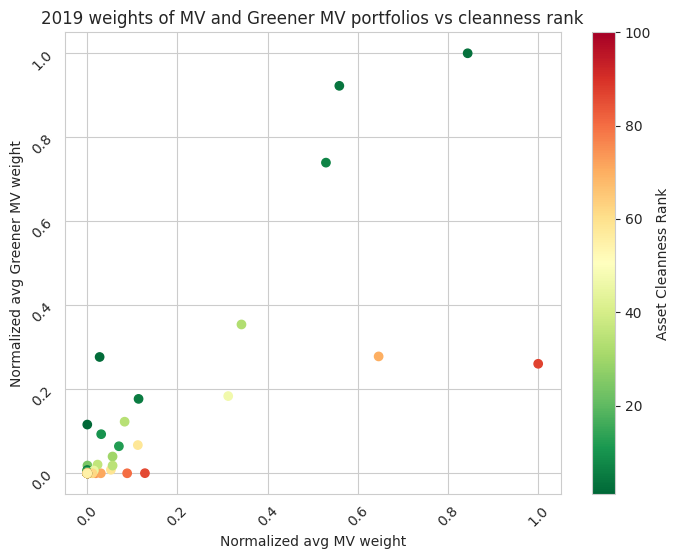

In [ ]:
# Take x and y columns
x = df_5_2019_weights['MV_avg_weights']
y = df_5_2019_weights['Greener_MV_avg_weights']

# Normalize the x and y columns between 0 and 1
norm_x = (x - x.min()) / (x.max() - x.min())
norm_y = (y - y.min()) / (y.max() - y.min())

# Set the size of the points based on the asset_cleanness_rank column
sizes = df_5_2019_weights['asset_cleanness_rank'].values

# Set the figure size
plt.figure(figsize=(8, 6))

# Use the scatter function to make a scatterplot
plt.scatter(x=norm_x, y=norm_y, c=sizes, alpha=1, cmap='RdYlGn_r')

# Add a title and axis labels
plt.title('2019 weights of MV and Greener MV portfolios vs cleanness rank')
plt.xlabel('Normalized avg MV weight')
plt.ylabel('Normalized avg Greener MV weight')

# Define the color map
cmap = plt.cm.get_cmap('RdYlGn')

# Add a colorbar
cbar = plt.colorbar()

# Set the colorbar label
cbar.ax.set_ylabel('Asset Cleanness Rank')

# Customize the tick marks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

<ipython-input-247-d1a88e83588a>:34: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



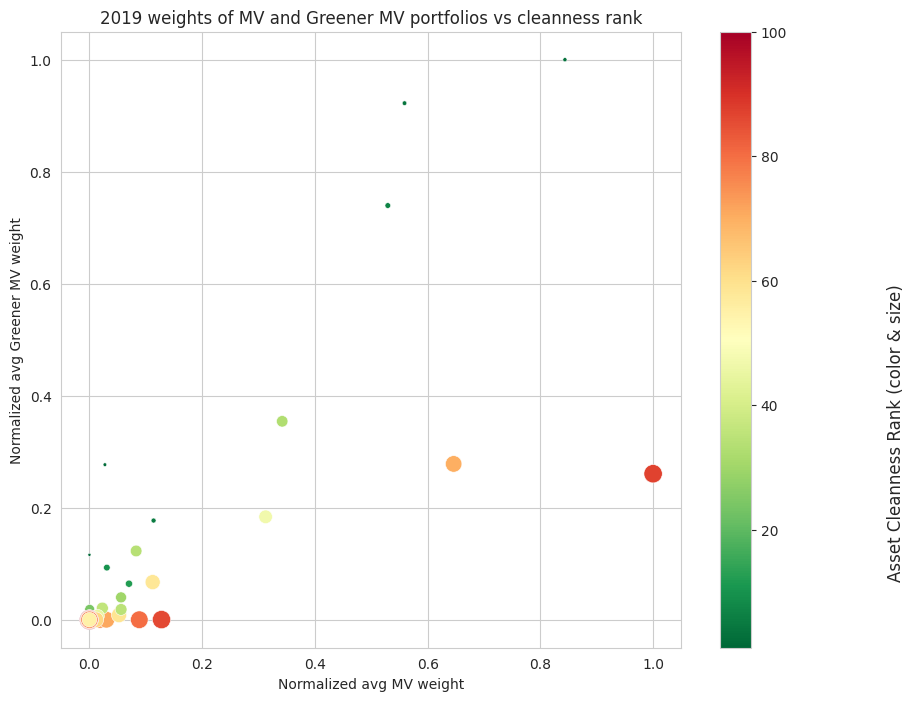

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))

x = df_5_2019_weights['MV_avg_weights']
y = df_5_2019_weights['Greener_MV_avg_weights']
# Normalize the x and y columns between 0 and 1
norm_x = (x - x.min()) / (x.max() - x.min())
norm_y = (y - y.min()) / (y.max() - y.min())

# Set the size of the points based on the asset_cleanness_rank column
sizes = df_5_2019_weights['asset_cleanness_rank'].values

# Create a scatter plot with the required parameters
scatterplot = sns.scatterplot(
    x=norm_x,
    y=norm_y,
    hue=sizes,
    size=sizes,
    palette='RdYlGn_r',
    sizes=(5, 200),
    #data=data,
    ax=ax
)

# Set the title and axis labels
ax.set_title('2019 weights of MV and Greener MV portfolios vs cleanness rank')
ax.set_xlabel('Normalized avg MV weight')
ax.set_ylabel('Normalized avg Greener MV weight')
ax.get_legend().remove()

# Add a colorbar to the plot
norm = plt.Normalize(sizes.min(), sizes.max())
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([]) # set an empty array to ensure that the scaling corresponds to the data
cbar = plt.colorbar(sm)
cbar.ax.set_title('Asset Cleanness Rank (color & size)',rotation=90, loc='right', y=0.1, x= 6)
# Set the limits for the colorbar
cbar.ax.set_ylim(sizes.min(), sizes.max())

# Show the plot
plt.show()

In [ ]:
mv_but_not_in_greener_2019 = {k: v for k, v in mv_in_portfolio_2019.items() if k not in greener_mv_in_portfolio_2019}
greener_but_not_in_mv_2019 = {k: v for k, v in greener_mv_in_portfolio_2019.items() if k not in mv_in_portfolio_2019}

print(f'In MV but not in Greener MV: {mv_but_not_in_greener_2019}')
print(f'In Greener MV but not in MV: {greener_but_not_in_mv_2019}')

In MV but not in Greener MV: {}
In Greener MV but not in MV: {}


###### 2015-2019

In [ ]:
mv_weights_all, mv_not_in_portfolio_all, mv_in_portfolio_all = create_weight_CI_df_in_period(df_5_mv_portfolio, period_all)
mv_weights_all

Period: 2015-01-31 to 2019-12-31


ISIN                       NAME  asset_cleanness_rank  \
0   US30231G1022                EXXON MOBIL                    70   
1   MYL5681OO001          PETRONAS DAGANGAN                     3   
2   MYL4324OO009  HENGYUAN REFINING COMPANY                    59   
3   QA000A0KD6L1      QATAR GS.TRAN.NAKILAT                    87   
4   INE196A01026                     MARICO                     7   
..           ...                        ...                   ...   
95  US6752321025                OCEANEERING                    14   
96  NO0005052605                NORSK HYDRO                    89   
97  US42809H1077                       HESS                    64   
98  RU0009062467               GAZPROM NEFT                    78   
99  US4234521015          HELMERICH & PAYNE                    28   

    Avg_weight_in_period (descending)  Scope1_CI  Scope2_CI  Scope3_CI  \
0                              0.2348  2370.4372   165.0111  2259.1183   
1                              0.1632    89.0543   110.0174   311.8904   
2                              0.1134  1559.3118   206.8042  2436.4350   
3                              0.1036  6243.9068    92.5633   587.5072   
4                              0.0891     8.4575    64.7779   863.9650   
..                                ...        ...        ...        ...   
95                             0.0000    82.7705    92.1279  1412.1398   
96                             0.0000  3305.1360  1412.2716  2663.2430   
97                             0.0000  3492.0369   388.1551   534.9647   
98                             0.0000  2360.7724   674.4842  2303.2037   
99                             0.0000   647.8329    71.5264  1809.1054   

    Total_CI  
0  4794.5666  
1   510.9621  
2  4202.5510  
3  6923.9773  
4   937.2004  
..       ...  
95 1587.0382  
96 7380.6506  
97 4415.1566  
98 5338.4603  
99 2528.4646  

[100 rows x 8 columns]

In [ ]:
greener_mv_weights_all, greener_mv_not_in_portfolio_all, greener_mv_in_portfolio_all = create_weight_CI_df_in_period(df_5_greener_mv_portfolio, period_all)
greener_mv_weights_all

Period: 2015-01-31 to 2019-12-31


ISIN                           NAME  asset_cleanness_rank  \
0   MYL5681OO001              PETRONAS DAGANGAN                     3   
1   INE196A01026                         MARICO                     7   
2   US9026531049                            UDR                     4   
3   US30231G1022                    EXXON MOBIL                    70   
4   PK0080201012  OIL & GAS DEVELOPMENT COMPANY                    33   
..           ...                            ...                   ...   
95  RU0009033591                        TATNEFT                    43   
96  US42809H1077                           HESS                    64   
97  RU0009062467                   GAZPROM NEFT                    78   
98  US20825C1045                 CONOCOPHILLIPS                    65   
99  US91913Y1001                  VALERO ENERGY                    55   

    Avg_weight_in_period (descending)  Scope1_CI  Scope2_CI  Scope3_CI  \
0                              0.2213    89.0543   110.0174   311.8904   
1                              0.1414     8.4575    64.7779   863.9650   
2                              0.1274    67.4791   301.0190   158.6620   
3                              0.0792  2370.4372   165.0111  2259.1183   
4                              0.0683  1928.5805   263.0575   529.8273   
..                                ...        ...        ...        ...   
95                             0.0000  1617.9355   224.5900  1390.7037   
96                             0.0000  3492.0369   388.1551   534.9647   
97                             0.0000  2360.7724   674.4842  2303.2037   
98                             0.0000  3684.9488   208.1308   530.0639   
99                             0.0000  1375.1381   164.0212  2370.8714   

    Total_CI  
0   510.9621  
1   937.2004  
2   527.1601  
3  4794.5666  
4  2721.4652  
..       ...  
95 3233.2291  
96 4415.1566  
97 5338.4603  
98 4423.1435  
99 3910.0307  

[100 rows x 8 columns]

In [ ]:
mv_but_not_in_greener_all = {k: v for k, v in mv_in_portfolio_all.items() if k not in greener_mv_in_portfolio_all}
greener_but_not_in_mv_all = {k: v for k, v in greener_mv_in_portfolio_all.items() if k not in mv_in_portfolio_all}

print(f'In MV but not in Greener MV: {mv_but_not_in_greener_all}')
print(f'Dict size: {len(mv_but_not_in_greener_all)}')
print(f'In Greener MV but not in MV: {greener_but_not_in_mv_all}')
print(f'Dict size: {len(greener_but_not_in_mv_all)}')

In MV but not in Greener MV: {}
Dict size: 0
In Greener MV but not in MV: {}
Dict size: 0


In [ ]:
mv_weights_last_month, mv_not_in_portfolio_last_month, mv_in_portfolio_last_month = create_weight_CI_df_in_period(df_5_mv_portfolio, period_last_month)
mv_weights_last_month

Period: 2019-12-31 to 2019-12-31


ISIN                     NAME  asset_cleanness_rank  \
0   QA000A0KD6L1    QATAR GS.TRAN.NAKILAT                    87   
1   US9026531049                      UDR                     4   
2   MYL5681OO001        PETRONAS DAGANGAN                     3   
3   INE196A01026                   MARICO                     7   
4   US30231G1022              EXXON MOBIL                    70   
..           ...                      ...                   ...   
95  TH0796010005                 THAI OIL                    60   
96  CNE1000003W8           PETROCHINA 'H'                    16   
97  CNE1000002R0  CHINA SHENHUA EN.CO.'H'                   100   
98  MYL7164OO006                KNM GROUP                    23   
99  AN8068571086             SCHLUMBERGER                    15   

    Avg_weight_in_period (descending)  Scope1_CI  Scope2_CI  Scope3_CI  \
0                              0.2109    97.6295     1.4654     9.1429   
1                              0.1566     1.0734     4.7654     2.5347   
2                              0.1494     1.1288     2.3964     6.0068   
3                              0.1059     0.2298     1.1290    13.7800   
4                              0.1006    36.1917     2.9345    34.9798   
..                                ...        ...        ...        ...   
95                             0.0000    23.6949     2.7796    37.0188   
96                             0.0000    30.2300     9.5857     8.8947   
97                             0.0000   443.4666     3.2395    27.4371   
98                             0.0000     1.1133     2.2202    30.1633   
99                             0.0000     4.1240     1.4911    20.5521   

    Total_CI  
0   108.2378  
1     8.3735  
2     9.5320  
3    15.1388  
4    74.1060  
..       ...  
95   63.4933  
96   48.7104  
97  474.1432  
98   33.4969  
99   26.1673  

[100 rows x 8 columns]

In [ ]:
mv_not_in_portfolio_last_month

{'BAYTEX ENERGY': 91,
 'CONOCOPHILLIPS': 65,
 'TRANSOCEAN': 42,
 'ENERPLUS': 83,
 'EOG RES.': 40,
 'BONAVISTA ENERGY DEAD - DELIST.14/08/20': 96,
 'OCCIDENTAL PTL.': 84,
 'MURPHY OIL': 81,
 'CHEVRON': 62,
 'SEADRILL (OTC)': 53,
 'WHITEHAVEN COAL': 76,
 'PIONEER NTRL.RES.': 61,
 'RANGE RES.': 38,
 'SOUTHWESTERN ENERGY': 77,
 'ENERGY RES.OF AUS.': 39,
 'CONCHO RESOURCES DEAD - DELIST.19/01/21': 31,
 'DNO': 51,
 'CHENIERE EN.': 44,
 "OFFS.OIL ENGR. 'A'": 1,
 'SUBSEA 7': 26,
 'S-OIL': 67,
 'OIL & NATURAL GAS': 69,
 'CGG': 20,
 'GAZPROM': 97,
 'NK LUKOIL': 50,
 'NESTE': 37,
 'GAZPROM NEFT': 78,
 'TRANSNEFT PREF.': 11,
 'TMK OAO': 85,
 'REPSOL YPF': 68,
 'BILLERUDKORSNAS': 18,
 "SINOPEC OILFIELD SERVICE 'H'": 17,
 'THAI OIL': 60,
 "PETROCHINA 'H'": 16,
 "CHINA SHENHUA EN.CO.'H'": 100,
 'KNM GROUP': 23,
 'SCHLUMBERGER': 15}

In [ ]:
mv_in_portfolio_last_month

{'QATAR GS.TRAN.NAKILAT': 87,
 'UDR': 4,
 'PETRONAS DAGANGAN': 3,
 'MARICO': 7,
 'EXXON MOBIL': 70,
 'OIL & GAS DEVELOPMENT COMPANY': 33,
 'INDIAN OIL': 47,
 'PETRONET L N G': 30,
 'ULTRAPAR PARTICIPOES ON': 5,
 'INPEX': 10,
 "CHINA MRCH.EN.SHIP. 'A'": 86,
 'HENGYUAN REFINING COMPANY': 59,
 'SARAS': 80,
 'PAKISTAN STATE OIL COMPANY': 2,
 "GUANGHUI ENERGY 'A'": 71,
 "CABOT OIL & GAS 'A'": 34,
 'PAKISTAN PETROLEUM': 35,
 'CHINESE ESTATES HDG.': 12,
 'PEMBINA PIPELINE': 27,
 'TUPRAS TKI.PEL.RFNE.': 66,
 'PALADIN ENERGY': 95,
 'IMPERIAL OIL': 74,
 'PETRON': 45,
 "CHINA PTL.& CHM. 'H'": 24,
 'BHARAT PETROLEUM': 54,
 'GRUPA LOTOS': 46,
 'YPF': 88,
 'IRPC': 73,
 'KUNLUN ENERGY': 25,
 'ARCHROCK': 8,
 'SUNCOR ENERGY': 82,
 'BUKIT ASAM': 32,
 'HINDUSTAN PETROLEUM': 36,
 'ECOPETROL': 56,
 'CNOOC': 21,
 'CRESCENT POINT ENERGY': 90,
 'HOLLYFRONTIER': 52,
 'WOOD GROUP (JOHN)': 6,
 "CHINA COAL ENERGY 'H'": 98,
 'CANADIAN NATURAL RES.': 94,
 'RASPADSKAYA': 99,
 'VALARIS A': 29,
 'TATNEFT': 43,
 'DEVON

In [ ]:
greener_mv_weights_last_month, greener_mv_not_in_portfolio_last_month, greener_mv_in_portfolio_last_month = create_weight_CI_df_in_period(df_5_greener_mv_portfolio, period_last_month)
greener_mv_weights_last_month

Period: 2019-12-31 to 2019-12-31


ISIN                           NAME  asset_cleanness_rank  \
0   US9026531049                            UDR                     4   
1   MYL5681OO001              PETRONAS DAGANGAN                     3   
2   INE196A01026                         MARICO                     7   
3   QA000A0KD6L1          QATAR GS.TRAN.NAKILAT                    87   
4   PK0080201012  OIL & GAS DEVELOPMENT COMPANY                    33   
..           ...                            ...                   ...   
95  NO0005052605                    NORSK HYDRO                    89   
96  NO0010096985                        EQUINOR                    49   
97  PHY6885F1067                         PETRON                    45   
98  PK0081801018             PAKISTAN PETROLEUM                    35   
99  LU0156801721                        TENARIS                    93   

    Avg_weight_in_period (descending)  Scope1_CI  Scope2_CI  Scope3_CI  \
0                              0.2539     1.0734     4.7654     2.5347   
1                              0.1946     1.1288     2.3964     6.0068   
2                              0.1585     0.2298     1.1290    13.7800   
3                              0.0751    97.6295     1.4654     9.1429   
4                              0.0737    29.5537     4.1644     8.2552   
..                                ...        ...        ...        ...   
95                             0.0000    45.8306    16.7523    41.8062   
96                             0.0000    19.1461     0.2797    35.8356   
97                             0.0000    12.2176     0.8347    37.5078   
98                             0.0000    29.5538     4.1644     8.2555   
99                             0.0000    20.4607    10.0538    81.2724   

    Total_CI  
0     8.3735  
1     9.5320  
2    15.1388  
3   108.2378  
4    41.9733  
..       ...  
95  104.3891  
96   55.2614  
97   50.5601  
98   41.9737  
99  111.7869  

[100 rows x 8 columns]

In [ ]:
greener_mv_not_in_portfolio_last_month

{'CHEVRON': 62,
 'THAI OIL': 60,
 'SOUTHWESTERN ENERGY': 77,
 'RANGE RES.': 38,
 'PATTERSON UTI ENERGY': 22,
 'OVINTIV (NYS)': 75,
 'RASPADSKAYA': 99,
 'HOLLYFRONTIER': 52,
 'HELMERICH & PAYNE': 28,
 'LUNDIN ENERGY': 9,
 'CHENIERE EN.': 44,
 'TUPRAS TKI.PEL.RFNE.': 66,
 'TRANSNEFT PREF.': 11,
 'IRPC': 73,
 'CONTINENTAL RESOURCES': 41,
 'CONOCOPHILLIPS': 65,
 'CONCHO RESOURCES DEAD - DELIST.19/01/21': 31,
 'PTT EXPLORATION & PRDN.': 72,
 'SCHLUMBERGER': 15,
 'GAZPROM NEFT': 78,
 'CNOOC': 21,
 'ENERGY RES.OF AUS.': 39,
 'KUNLUN ENERGY': 25,
 'SEADRILL (OTC)': 53,
 'ARC RESOURCES': 79,
 'BONAVISTA ENERGY DEAD - DELIST.14/08/20': 96,
 'CRESCENT POINT ENERGY': 90,
 'ENERPLUS': 83,
 'PEMBINA PIPELINE': 27,
 'TRANSOCEAN': 42,
 "CHINA SHENHUA EN.CO.'H'": 100,
 'ECOPETROL': 56,
 'REPSOL YPF': 68,
 'NESTE': 37,
 'VALARIS A': 29,
 'MOL MAGYAR OLAJ-ES GAZIPARI': 57,
 'GAZPROM': 97,
 'BUKIT ASAM': 32,
 'BHARAT PETROLEUM': 54,
 "HAVELL'S INDIA": 13,
 'OIL & NATURAL GAS': 69,
 'SARAS': 80,
 'ENI': 63

In [ ]:
greener_mv_in_portfolio_last_month

{'UDR': 4,
 'PETRONAS DAGANGAN': 3,
 'MARICO': 7,
 'QATAR GS.TRAN.NAKILAT': 87,
 'OIL & GAS DEVELOPMENT COMPANY': 33,
 'PAKISTAN STATE OIL COMPANY': 2,
 'EXXON MOBIL': 70,
 'INDIAN OIL': 47,
 'INPEX': 10,
 'ULTRAPAR PARTICIPOES ON': 5,
 "CABOT OIL & GAS 'A'": 34,
 "OFFS.OIL ENGR. 'A'": 1,
 'PETRONET L N G': 30,
 "CHINA PTL.& CHM. 'H'": 24,
 'HENGYUAN REFINING COMPANY': 59,
 'CHINESE ESTATES HDG.': 12,
 'WOOD GROUP (JOHN)': 6,
 'BILLERUDKORSNAS': 18,
 'HINDUSTAN PETROLEUM': 36,
 "CHINA COAL ENERGY 'H'": 98,
 'YPF': 88,
 "CHINA MRCH.EN.SHIP. 'A'": 86,
 'WHITEHAVEN COAL': 76,
 'BAYTEX ENERGY': 91,
 'ARCHROCK': 8,
 'CGG': 20,
 'PALADIN ENERGY': 95,
 'SUNCOR ENERGY': 82,
 "PETROCHINA 'H'": 16,
 "SINOPEC OILFIELD SERVICE 'H'": 17,
 'PIONEER NTRL.RES.': 61,
 'TMK OAO': 85,
 'HESS': 64,
 'OCCIDENTAL PTL.': 84,
 'IMPERIAL OIL': 74,
 'DNO': 51,
 'S-OIL': 67,
 'GRUPA LOTOS': 46,
 'MURPHY OIL': 81,
 'DEVON ENERGY': 48,
 'CANADIAN NATURAL RES.': 94,
 "GUANGHUI ENERGY 'A'": 71,
 'OCEANEERING': 14,
 

In [ ]:
dec19_mv_but_not_in_greener = {k: v for k, v in mv_in_portfolio_last_month.items() if k not in greener_mv_in_portfolio_last_month}
dec19_greener_but_not_in_mv = {k: v for k, v in greener_mv_in_portfolio_last_month.items() if k not in mv_in_portfolio_last_month}

print(f'In MV but not in Greener MV: {dec19_mv_but_not_in_greener}')
print(f'Dict size: {len(dec19_mv_but_not_in_greener)}')
print(f'Mean cleanness rank: {np.mean(list(dec19_mv_but_not_in_greener.values()))}\n')

print(f'In Greener MV but not in MV: {dec19_greener_but_not_in_mv}')
print(f'Dict size: {len(dec19_greener_but_not_in_mv)}')
print(f'Mean cleanness rank: {np.mean(list(dec19_greener_but_not_in_mv.values()))}\n')

In MV but not in Greener MV: {'SARAS': 80, 'PAKISTAN PETROLEUM': 35, 'PEMBINA PIPELINE': 27, 'TUPRAS TKI.PEL.RFNE.': 66, 'PETRON': 45, 'BHARAT PETROLEUM': 54, 'IRPC': 73, 'KUNLUN ENERGY': 25, 'BUKIT ASAM': 32, 'ECOPETROL': 56, 'CNOOC': 21, 'CRESCENT POINT ENERGY': 90, 'HOLLYFRONTIER': 52, 'RASPADSKAYA': 99, 'VALARIS A': 29, 'NORSK HYDRO': 89, 'CONTINENTAL RESOURCES': 41, 'MOL MAGYAR OLAJ-ES GAZIPARI': 57, 'OVINTIV (NYS)': 75, 'EQUINOR': 49, "HAVELL'S INDIA": 13, 'TENARIS': 93, 'LUNDIN ENERGY': 9, 'ARC RESOURCES': 79, 'PATTERSON UTI ENERGY': 22, 'SAIPEM': 19, 'PTT EXPLORATION & PRDN.': 72, 'IDEMITSU KOSAN': 58, 'ENI': 63, 'HELMERICH & PAYNE': 28}
Dict size: 30
Mean cleanness rank: 51.7

In Greener MV but not in MV: {"OFFS.OIL ENGR. 'A'": 1, 'BILLERUDKORSNAS': 18, 'WHITEHAVEN COAL': 76, 'BAYTEX ENERGY': 91, 'CGG': 20, "PETROCHINA 'H'": 16, "SINOPEC OILFIELD SERVICE 'H'": 17, 'PIONEER NTRL.RES.': 61, 'TMK OAO': 85, 'OCCIDENTAL PTL.': 84, 'DNO': 51, 'S-OIL': 67, 'MURPHY OIL': 81, 'NK LUKOI

###### Correlation between carbon rank and portfolio weight

In [ ]:
mv_carbon_rank = mv_weights_all.asset_cleanness_rank.values.tolist()
mv_weight_rank = mv_weights_all['Avg_weight_in_period (descending)'].values.tolist()

In [ ]:
greener_mv_carbon_rank = greener_mv_weights_all.asset_cleanness_rank.values.tolist()
greener_mv_weight_rank = greener_mv_weights_all['Avg_weight_in_period (descending)'].values.tolist()

In [ ]:
def carbon_rank_portfolio_weight_correlation (list1, list2, portfolio_name):

  corr, p_value = pearsonr(list1, list2)

  # Set the figure size
  plt.figure(figsize=(8, 6))

  # Use the function regplot to make a scatterplot
  sns.regplot(x=list1, y=list2, color='#4A90E2', seed=0)

  # Add a title and axis labels
  plt.title(f'Correlation between asset cleanness rank and portfolio weight ({portfolio_name} portfolio)')
  plt.xlabel('Cleanness rank')
  plt.ylabel('Avg portfolio weight (2015-2019)')

  # Customize the tick marks
  plt.xticks(rotation=45)
  plt.yticks(rotation=45)

  plt.legend(labels=[f'Correlation: {round(corr, 4)}'])

  # Change the background color
  sns.set_style("whitegrid")

  plt.show()

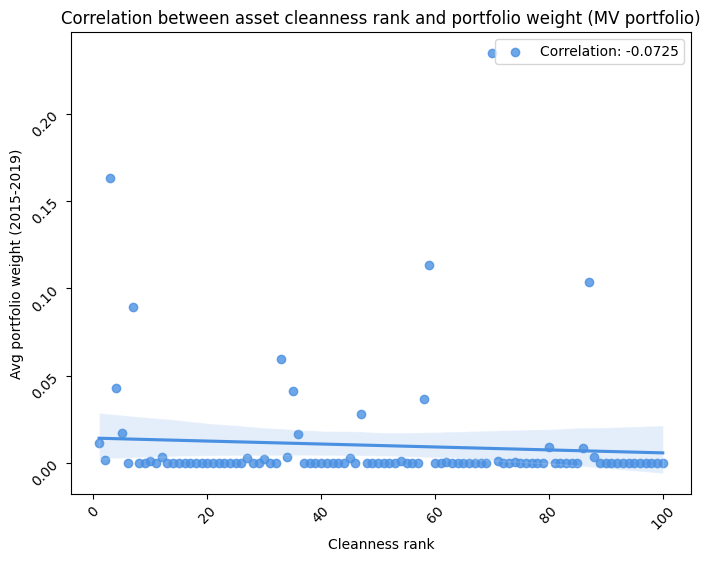

In [ ]:
carbon_rank_portfolio_weight_correlation(mv_carbon_rank, mv_weight_rank, 'MV')

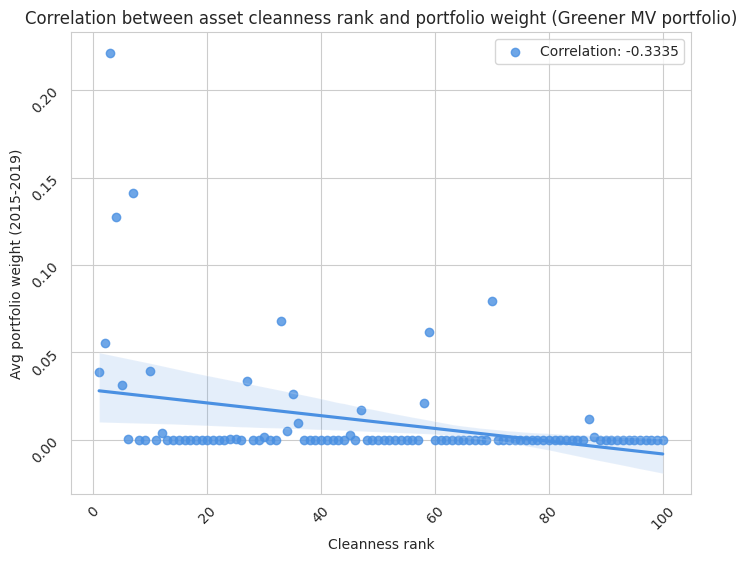

In [ ]:
carbon_rank_portfolio_weight_correlation(greener_mv_carbon_rank, greener_mv_weight_rank, 'Greener MV')

###### 2019 weight percentage changes

In [ ]:
df_5_firms

ISIN                 NAME  asset_cleanness_rank
0   AN8068571086         SCHLUMBERGER                    15
1   ARP9897X1319                  YPF                    88
2   AU000000ERA9   ENERGY RES.OF AUS.                    39
3   AU000000PDN8       PALADIN ENERGY                    95
4   AU000000WHC8      WHITEHAVEN COAL                    76
..           ...                  ...                   ...
95  US7237871071    PIONEER NTRL.RES.                    61
96  US75281A1097           RANGE RES.                    38
97  US8454671095  SOUTHWESTERN ENERGY                    77
98  US9026531049                  UDR                     4
99  US91913Y1001        VALERO ENERGY                    55

[100 rows x 3 columns]

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
df_5_2019_change = df_5_firms.copy()
df_5_2019_change = pd.merge(df_5_2019_change, mv_weights_2019[['ISIN', 'Avg_weight_in_period (descending)']], on='ISIN', how='left')
df_5_2019_change.rename(columns={"Avg_weight_in_period (descending)": "MV_avg_weights"}, inplace=True)
df_5_2019_change = pd.merge(df_5_2019_change, greener_mv_weights_2019[['ISIN', 'Avg_weight_in_period (descending)']], on='ISIN', how='left')
df_5_2019_change.rename(columns={"Avg_weight_in_period (descending)": "Greener_MV_avg_weights"}, inplace=True)
df_5_2019_change['%_change_to_decarbonize'] = round((df_5_2019_change['Greener_MV_avg_weights'] - df_5_2019_change['MV_avg_weights']) / df_5_2019_change['MV_avg_weights']*100, 2)
# Convert scientific notation to standard notation
df_5_2019_change = df_5_2019_change.sort_values(by=['%_change_to_decarbonize'], ascending=False)
df_5_2019_change.reset_index(drop=True, inplace=True)
df_5_2019_change['%_change_to_decarbonize'] = df_5_2019_change['%_change_to_decarbonize'].apply(lambda x: "500+" if x > 500 else x)
df_5_2019_change

ISIN                  NAME  asset_cleanness_rank  MV_avg_weights  \
0   CNE0000019T2    OFFS.OIL ENGR. 'A'                     1          0.0000   
1   BMG5320C1082         KUNLUN ENERGY                    25          0.0000   
2   GB00B5N0P849     WOOD GROUP (JOHN)                     6          0.0000   
3   SE0000862997       BILLERUDKORSNAS                    18          0.0000   
4   FI0009013296                 NESTE                    37          0.0000   
..           ...                   ...                   ...             ...   
95  AU000000PDN8        PALADIN ENERGY                    95          0.0002   
96  US1667641005               CHEVRON                    62          0.0022   
97  INE029A01011      BHARAT PETROLEUM                    54          0.0009   
98  TRATUPRS91E8  TUPRAS TKI.PEL.RFNE.                    66          0.0004   
99  CNE0000012G4   GUANGHUI ENERGY 'A'                    71          0.0058   

    Greener_MV_avg_weights %_change_to_decarbonize  
0                   0.0242                    500+  
1                   0.0015                    500+  
2                   0.0016                    500+  
3                   0.0008                    500+  
4                   0.0000                    500+  
..                     ...                     ...  
95                  0.0000               -100.0000  
96                  0.0000               -100.0000  
97                  0.0000               -100.0000  
98                  0.0000               -100.0000  
99                  0.0000               -100.0000  

[100 rows x 6 columns]

In [ ]:
df_5_2019_change[:10]

ISIN                        NAME  asset_cleanness_rank  \
0  CNE0000019T2          OFFS.OIL ENGR. 'A'                     1   
1  BMG5320C1082               KUNLUN ENERGY                    25   
2  GB00B5N0P849           WOOD GROUP (JOHN)                     6   
3  SE0000862997             BILLERUDKORSNAS                    18   
4  FI0009013296                       NESTE                    37   
5  CNE1000002Q2        CHINA PTL.& CHM. 'H'                    24   
6  PK0022501016  PAKISTAN STATE OIL COMPANY                     2   
7  CA07317Q1054               BAYTEX ENERGY                    91   
8  JP3294460005                       INPEX                    10   
9  ARP9897X1319                         YPF                    88   

   MV_avg_weights  Greener_MV_avg_weights %_change_to_decarbonize  
0          0.0000                  0.0242                    500+  
1          0.0000                  0.0015                    500+  
2          0.0000                  0.0016                    500+  
3          0.0000                  0.0008                    500+  
4          0.0000                  0.0000                    500+  
5          0.0001                  0.0039                    500+  
6          0.0053                  0.0578                    500+  
7          0.0000                  0.0000                420.2200  
8          0.0060                  0.0194                225.0400  
9          0.0000                  0.0000                224.5000

In [ ]:
df_5_2019_change[-10:]

ISIN                     NAME  asset_cleanness_rank  \
90  US4361061082            HOLLYFRONTIER                    52   
91  CNE000001PQ8  CHINA MRCH.EN.SHIP. 'A'                    86   
92  CA7063271034         PEMBINA PIPELINE                    27   
93  CA4530384086             IMPERIAL OIL                    74   
94  IT0000433307                    SARAS                    80   
95  AU000000PDN8           PALADIN ENERGY                    95   
96  US1667641005                  CHEVRON                    62   
97  INE029A01011         BHARAT PETROLEUM                    54   
98  TRATUPRS91E8     TUPRAS TKI.PEL.RFNE.                    66   
99  CNE0000012G4      GUANGHUI ENERGY 'A'                    71   

    MV_avg_weights  Greener_MV_avg_weights %_change_to_decarbonize  
90          0.0000                  0.0000                -89.0200  
91          0.0248                  0.0000                -99.8000  
92          0.0005                  0.0000               -100.0000  
93          0.0036                  0.0000               -100.0000  
94          0.0171                  0.0000               -100.0000  
95          0.0002                  0.0000               -100.0000  
96          0.0022                  0.0000               -100.0000  
97          0.0009                  0.0000               -100.0000  
98          0.0004                  0.0000               -100.0000  
99          0.0058                  0.0000               -100.0000

In [ ]:
df_5_2019_change_nonzero = df_5_2019_change.loc[df_5_2019_change['Greener_MV_avg_weights'] + df_5_2019_change['MV_avg_weights'] >= 0.00001]

In [ ]:
df_5_2019_change_nonzero[:10]

ISIN                        NAME  asset_cleanness_rank  \
0   CNE0000019T2          OFFS.OIL ENGR. 'A'                     1   
1   BMG5320C1082               KUNLUN ENERGY                    25   
2   GB00B5N0P849           WOOD GROUP (JOHN)                     6   
3   SE0000862997             BILLERUDKORSNAS                    18   
5   CNE1000002Q2        CHINA PTL.& CHM. 'H'                    24   
6   PK0022501016  PAKISTAN STATE OIL COMPANY                     2   
8   JP3294460005                       INPEX                    10   
15  US9026531049                         UDR                     4   
18  BRUGPAACNOR8     ULTRAPAR PARTICIPOES ON                     5   
21  US1270971039         CABOT OIL & GAS 'A'                    34   

    MV_avg_weights  Greener_MV_avg_weights %_change_to_decarbonize  
0           0.0000                  0.0242                    500+  
1           0.0000                  0.0015                    500+  
2           0.0000                  0.0016                    500+  
3           0.0000                  0.0008                    500+  
5           0.0001                  0.0039                    500+  
6           0.0053                  0.0578                    500+  
8           0.0060                  0.0194                225.0400  
15          0.1084                  0.1927                 77.8300  
18          0.0220                  0.0370                 67.8000  
21          0.0161                  0.0256                 59.7500

In [ ]:
df_5_2019_change_nonzero[:10]['asset_cleanness_rank'].mean()

12.9

In [ ]:
df_5_2019_change_nonzero[-10:]

ISIN                       NAME  asset_cleanness_rank  \
88  MYL4324OO009  HENGYUAN REFINING COMPANY                    59   
91  CNE000001PQ8    CHINA MRCH.EN.SHIP. 'A'                    86   
92  CA7063271034           PEMBINA PIPELINE                    27   
93  CA4530384086               IMPERIAL OIL                    74   
94  IT0000433307                      SARAS                    80   
95  AU000000PDN8             PALADIN ENERGY                    95   
96  US1667641005                    CHEVRON                    62   
97  INE029A01011           BHARAT PETROLEUM                    54   
98  TRATUPRS91E8       TUPRAS TKI.PEL.RFNE.                    66   
99  CNE0000012G4        GUANGHUI ENERGY 'A'                    71   

    MV_avg_weights  Greener_MV_avg_weights %_change_to_decarbonize  
88          0.0102                  0.0017                -82.8700  
91          0.0248                  0.0000                -99.8000  
92          0.0005                  0.0000               -100.0000  
93          0.0036                  0.0000               -100.0000  
94          0.0171                  0.0000               -100.0000  
95          0.0002                  0.0000               -100.0000  
96          0.0022                  0.0000               -100.0000  
97          0.0009                  0.0000               -100.0000  
98          0.0004                  0.0000               -100.0000  
99          0.0058                  0.0000               -100.0000

In [ ]:
df_5_2019_change_nonzero[-10:]['asset_cleanness_rank'].mean()

67.4